<a href="https://colab.research.google.com/github/GuillermoAlmandoz/IEBS-Master-Data-Science/blob/main/ToMakeUp_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ToMakeUp

Proyecto de predicción de viscosidad para la empresa de fabricación de tintes.


In [ ]:
# Importación de las librerías
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from sklearn.model_selection import GridSearchCV

# Configuro pandas para que muestre todas las columnas
pd.set_option('display.max_columns', None)

# En la última ejecución quito los warnings para que quede más limpio el notebool
warnings.filterwarnings('ignore')

In [ ]:
# # Conectamos a google drive para recuperar los archivos csv de los datos
# from google.colab import drive
# drive.mount('/content/drive')

**Carga de los archivos csv**

Disponemos de 3 archivos csv, que previamente se han tenido que preprocesar eliminado retornos de carro que hacían que no fuera consistente.

Los tres archivos corresponden a los siguientes periodos de tiempo:

- Órdenes de producción de Junio a Diciembre del 2021
- Órdenes de producción de año 2022
- Órdenes de producción de Enero a Julio de 2023

In [ ]:
# Cargo los 3 archivos CSV con pandas, y los unifico en un solo dataframe
df_2021 = pd.read_csv('Datos_Viscosidad_20210601_20211231.csv', encoding='latin-1', sep=',')
df_2022 = pd.read_csv('Datos_Viscosidad_20220101_20221231.csv', encoding='latin-1', sep=',', low_memory=False)
df_2023 = pd.read_csv('Datos_Viscosidad_20230101_20230731.csv', encoding='latin-1', sep=',', low_memory=False)

In [ ]:
df = pd.concat([df_2021, df_2022, df_2023])

In [ ]:
df.head()

,GUIDE,WOHNUMBER,MATCODE,WMDNAME,TEMPERATURA,PRESION,PESO,VELOCIDAD_AGITADOR,VELOCIDAD_EMULSIONADOR,VISCOSIDAD,WKUCODE,ESTADO_INSTRUCCION,VACIO,PRESET_CALENTAR,PRESET_ENFRIAR,PRESET_AGUA,PRESET_VACIO,TBINST,FECHA_MEDICION,CLVDATE_medicion,WMDQUANTITY1,UNTCODE1,RPQUANTITYPRODUCED,SCRAP,NMEDICIONt,NMEDICIONES,FINAL PROCESO,MGDVALUEMIN,MGDVALUEMAX,VISCOSIDAD_final,VISCOSIDAD_muestras,OBSERVACIONES,CAPACIDAD,CLVDATE_muestra
0,304,1032289,621005,SE. COLLAGE 1/00 NEGRO,51.93865,-0.656395,48.03241,0.0,0.0,22800.0,F11,POLLING,-0.654224,75.0,30.0,162.0,-0.6,0,2021-12-01 10:10:01.010000,2021-12-01 07:06:00.660000,904.8,KGM,909.0,-4.2,0,2,NaN,80000.0,250000.0,130800.0,0.0,32ºc,1000.0,NaN
1,304,1032289,621005,SE. COLLAGE 1/00 NEGRO,60.01158,-0.594907,199.65280,0.0,0.0,22800.0,F11,POLLING,-0.596354,75.0,30.0,162.0,-0.6,0,2021-12-01 10:10:01.010000,2021-12-01 07:07:00.690000,904.8,KGM,909.0,-4.2,0,2,NaN,80000.0,250000.0,130800.0,0.0,32ºc,1000.0,NaN
2,304,1032289,621005,SE. COLLAGE 1/00 NEGRO,59.37500,-0.609375,199.65280,0.0,0.0,22800.0,F11,POLLING,-0.610098,75.0,30.0,162.0,-0.6,0,2021-12-01 10:10:01.010000,2021-12-01 07:08:00.693000,904.8,KGM,909.0,-4.2,0,2,NaN,80000.0,250000.0,130800.0,0.0,32ºc,1000.0,NaN
3,304,1032289,621005,SE. COLLAGE 1/00 NEGRO,58.44908,-0.602141,224.24770,0.0,0.0,22800.0,F11,POLLING,-0.602865,75.0,30.0,162.0,-0.6,0,2021-12-01 10:10:01.010000,2021-12-01 07:09:00.703000,904.8,KGM,909.0,-4.2,0,2,NaN,80000.0,250000.0,130800.0,0.0,32ºc,1000.0,NaN
4,304,1032289,621005,SE. COLLAGE 1/00 NEGRO,56.48148,-0.617332,274.01620,0.0,0.0,22800.0,F11,POLLING,-0.616609,75.0,30.0,162.0,-0.6,0,2021-12-01 10:10:01.010000,2021-12-01 07:10:00.733000,904.8,KGM,909.0,-4.2,0,2,NaN,80000.0,250000.0,130800.0,0.0,32ºc,1000.0,NaN


In [ ]:
# df.to_csv('datos_en_crudo.csv')

## Hipótesis 1: Proporciones de componentes

Vamos a dividir el proyecto en cuatro hipótesis principales, la primera consiste en tener en cuenta las cantidades de cada componente y la cantidad total de producto. Todos los demás campos los vamos a descartar en esta primera hipótesis.


### Preprocesamiento de los datos

En los datos actuales, tenemos para cada orden, la monitorización a cada minuto de diferentes datos como la temperatura, presión, etc..., además, tenemos diferentes mediciones, en nuestro caso, solo nos interesa las cantidad de producto y la proporción de cada componente, y la primera medición de viscosidad. Por lo tanto, hemos de procesar el dataframe para reducirlo a tener una sola orden por registro con los datos a tener en cuenta en esta hipótesis.

In [ ]:
# Creo una copia del dataframe para no modificar el original
df_hip_1 = df.copy()

In [ ]:
# Convierto el nombre de las columnas aminúsculas, y substituyo los espacios por guiones bajos,
# además quito los guines bajos al principio y final de cada nombre de columna
df_hip_1.columns = df_hip_1.columns.str.lower().str.replace(' ', '_').str.strip('_')

In [ ]:
# Convierto el campo de fecha clvdate_medicion que me servirá para la ordenación
# df_hip_1["clvdate_medicion"] = pd.to_datetime(df_hip_1["clvdate_medicion"], format="%Y-%m-%d %H:%M:%S.%f")
df_hip_1["clvdate_medicion"] = pd.to_datetime(df_hip_1["clvdate_medicion"], format="mixed")

In [ ]:
# Filtro el dataframe para los registros que tienen el campo nmediciont = 1, que son los que tienen los datos de la primera medición
df_hip_1 = df_hip_1[df_hip_1["nmediciont"] == 1]

In [ ]:
# Ordenamos por el campo fecha
df_hip_1.sort_values(by=["clvdate_medicion"], inplace=True);

El siguiente paso es crucial, el primer valor que tiene el campo `nmediciont = 1` tendrá el resultado de la primera medida de viscosidad, por cada orden, es el que nos interesa recuperar.

In [ ]:
# Recuperamos el primer registro para cada orden
df_hip_1 = df_hip_1.groupby(["wohnumber"]).first().reset_index()

In [ ]:
# Compruebo los datos del dataframe
df_hip_1.head()

,wohnumber,guide,matcode,wmdname,temperatura,presion,peso,velocidad_agitador,velocidad_emulsionador,viscosidad,wkucode,estado_instruccion,vacio,preset_calentar,preset_enfriar,preset_agua,preset_vacio,tbinst,fecha_medicion,clvdate_medicion,wmdquantity1,untcode1,rpquantityproduced,scrap,nmediciont,nmediciones,final_proceso,mgdvaluemin,mgdvaluemax,viscosidad_final,viscosidad_muestras,observaciones,capacidad,clvdate_muestra
0,1032289,304,621005,SE. COLLAGE 1/00 NEGRO,42.99769,-0.654948,883.1019,50.0,-50.0,22800.0,F11,POLLING,-0.654948,55.0,35.0,162.0,-0.6,0,2021-12-01 10:10:01.010000,2021-12-01 10:11:00.173,904.8,KGM,909.0,-4.2,1,2,None,80000.0,250000.0,130800.0,22800.0,32ºc,1000.0,2021-12-01 10:10:01.010000
1,1032292,304,628065,SE. COLLAGE 8/06 RUBIO CLARO CÁLIDO,33.79630,-0.678819,478.9352,0.0,0.0,144400.0,F1,POLLING,-0.678819,75.0,35.0,212.0,-0.6,0,2021-12-01 11:18:00.663000,2021-12-01 11:18:01.013,452.4,KGM,435.0,17.4,1,1,*** FIN PRECESO ***,80000.0,250000.0,144400.0,144400.0,31ºc,500.0,2021-12-01 11:18:00.663000
2,1032293,307,628175,SE. COLLAGE 8/17 RUB.CLA.CEN.METAL,32.87037,0.323785,2713.5420,0.0,0.0,128400.0,F10,POLLING,0.324508,75.0,35.0,1626.0,-0.6,0,2021-12-13 15:57:36.703000,2021-12-13 15:58:00.460,2726.0,KGM,2708.0,18.0,1,1,*** FIN PRECESO ***,80000.0,250000.0,128400.0,128400.0,30ºC,3000.0,2021-12-13 15:57:36.703000
3,1032327,307,629915,SE. CLAIR 12/10 SUP.ACLA.CENIZA,61.16898,-0.315683,2262.1530,-50.0,50.0,32800.0,F10,POLLING,-0.316406,58.0,35.0,1141.0,-0.6,0,2021-12-02 10:56:21.883000,2021-12-02 10:57:00.843,2262.0,KGM,2231.0,31.0,1,2,None,80000.0,250000.0,90600.0,32800.0,30ºc,3000.0,2021-12-02 10:56:21.883000
4,1032329,302,629925,SE. CLAIR 12/20 SUP.ACLA.IRISE,34.08565,-0.652778,508.1019,0.0,0.0,106000.0,F11,POLLING,-0.652778,75.0,35.0,174.0,-0.6,0,2021-12-02 11:44:03.573000,2021-12-02 11:45:00.617,452.4,KGM,438.0,14.4,1,1,*** FIN PRECESO ***,80000.0,250000.0,106000.0,106000.0,33ºc,1000.0,2021-12-02 11:44:03.573000


De todos las columnas, nos quedamos solamente con las siguientes:

- `matcode`: Es el código de producto, no servirá para cruzar con la tabla de cantidad de componentes por producto.

- `wmdquantity`: Cantidad total de producto, es importante tener en cuenta que hay otra cantidad pero es la que se recupera de los reactores, creo que la cantidad total que se pone en el reactor es la cantidad que nos interesa.

- `viscosidad_muestras`

- `mgvaluemin`: Viscosidad mínima que ha de tener el producto, es el valor umbral que nos interesa para saber si la viscosidad es correcta. No consideramos el úmbral superior porque no es relevante.

- `capacidad`: Hay tres capacidades distintas, porque disponemos de tres reactores para la fabricación del producto.


Añadimos un campo adicional `grado de llenado` con que indica la proporción de llenado del reactor.

In [ ]:
# Creo la nueva columna "grado de llenado"
df_hip_1['grado_llenado'] = df_hip_1['wmdquantity1'] / df_hip_1['capacidad']
# Redondear a tres decimales
df_hip_1['grado_llenado'] = df_hip_1['grado_llenado'].round(3)

In [ ]:
# Selecciono las columnas que voy a necesitar para esta primera hipótesis
df_hip_1 = df_hip_1[['matcode', 'wmdquantity1', 'mgdvaluemin', 'viscosidad_muestras', 'capacidad', 'grado_llenado']]

In [ ]:
df_hip_1.head()

,matcode,wmdquantity1,mgdvaluemin,viscosidad_muestras,capacidad,grado_llenado
0,621005,904.8,80000.0,22800.0,1000.0,0.905
1,628065,452.4,80000.0,144400.0,500.0,0.905
2,628175,2726.0,80000.0,128400.0,3000.0,0.909
3,629915,2262.0,80000.0,32800.0,3000.0,0.754
4,629925,452.4,80000.0,106000.0,1000.0,0.452


Creo una columna adicional `target` donde pondremos 1 si la medición de la viscosidad es correcta, y 0 si no es correcta

In [ ]:
# Como quiero detectar aquellos casos en que la viscosidad no ha salido bien, cambio el valor del target,
# 1 si la viscosidad ha salido mal, 0 si ha salido bien

# Primero he de convertir a float el campo viscosidad_muestras
df_hip_1["viscosidad_muestras"] = df_hip_1["viscosidad_muestras"].astype(float)


df_hip_1["target"] = df_hip_1.apply(lambda x: 0 if (x["viscosidad_muestras"] >= x["mgdvaluemin"]) else 1, axis=1)

Puedo eliminar las columnas `viscosidad_muestras` y `mgdvaluemin` ya que no las utilizaremos más adelante.

In [ ]:
df_hip_1.drop(["viscosidad_muestras", "mgdvaluemin"], axis=1, inplace=True)

El campo de capacidad lo convierto a string, donde cada valor lo substituiré por un nombre descriptivo del reactor

In [ ]:
substitucion = {
    3000: 'Grande',
    1000: 'Mediano',
    500: 'Pequeño'
}

df_hip_1['capacidad'] = df_hip_1['capacidad'].replace(substitucion)

In [ ]:
# Renombramos la columna wmdquantity1
df_hip_1 = df_hip_1.rename(columns={'wmdquantity1': 'cantidad'})

In [ ]:
df_hip_1.head()

,matcode,cantidad,capacidad,grado_llenado,target
0,621005,904.8,Mediano,0.905,1
1,628065,452.4,Pequeño,0.905,0
2,628175,2726.0,Grande,0.909,0
3,629915,2262.0,Grande,0.754,1
4,629925,452.4,Mediano,0.452,0


Recuperamos la información de composición de componentes para cada uno de los productos, que en nuestro dataframe es la columna matcode

In [ ]:
df_componentes = pd.read_excel('desgloses tintes.xlsx')
df_componentes.columns = df_componentes.columns.str.lower().str.replace(' ', '_').str.strip()
df_componentes.head()

,material,componente,texto_breve_del_objeto,cantidad_componente
0,620025,111003,ACIDO ASCORBICO,0.5
1,620025,111020,AMONIACO 25%,0.1
2,620025,111940,NATRLQUEST E 30,3.0
3,620025,111103,TRANSCUTOL CG,15.0
4,620025,111117,AGUA DESIONIZADA,663.0


In [ ]:
# Voy a limipiar los datos de la columna texto_breve_del_objeto de los tintes
# Elimino los caracteres especiales por espacios, solo dejo letras y números, convierto todo el texto en minúsculas
df_componentes["texto_breve_del_objeto"] = df_componentes["texto_breve_del_objeto"].str.replace('[^a-zA-Z0-9 \n\.]', '_').str.lower()
# Si queda algún espacio, pongo un subrayado, si hay más de un subrayado seguido, lo quito
df_componentes["texto_breve_del_objeto"] = df_componentes["texto_breve_del_objeto"].str.replace(' ', '_').str.replace('__', '_')

Queremos los componentes en columnas, por lo que pivotamos la tabla, en el caso de que un producto (material) no tenga un componente, le ponemos el valor 0

In [ ]:
df_componentes = df_componentes.pivot_table(index=['material'], columns=['texto_breve_del_objeto'], values=['cantidad_componente'],fill_value=0)

In [ ]:
df_componentes.head()

cantidad_componente                    \
texto_breve_del_objeto *z6*dabeersen-503_/_dissolvine_d-40 *z6_colorante_ptd   
material                                                                       
620005                                                 2.5               0.0   
620025                                                 0.0               0.0   
620075                                                 0.0               0.0   
620105                                                 0.0               0.0   
620115                                                 0.0               0.0   

                                                                     \
texto_breve_del_objeto *z6_vibracolor_citrus_yellow acido_ascorbico   
material                                                              
620005                                          0.0             0.0   
620025                                          0.0             0.5   
620075                                          0.0             4.0   
620105                                          0.0             4.0   
620115                                          0.0             4.0   

                                                                       \
texto_breve_del_objeto agua_desionizada amoniaco_25% aq-save arginine   
material                                                                
620005                          762.500        0.000       0        0   
620025                          663.000        0.100       1        2   
620075                          626.018       71.862       1        2   
620105                          570.638       71.862       1        2   
620115                          586.334       71.862       1        2   

                                                                             \
texto_breve_del_objeto arianor_cherry_red/vibracolor_ruby_red astrophos_hc2   
material                                                                      
620005                                                    0.0            30   
620025                                                    0.0            30   
620075                                                    0.0            30   
620105                                                    0.0            30   
620115                                                    0.0            30   

                                                                   \
texto_breve_del_objeto azul_ultramar_b_6554 cera_de_abejas-beewax   
material                                                            
620005                                  0.0                     0   
620025                                  0.0                     0   
620075                                  0.0                     0   
620105                                  0.0                     0   
620115                                  0.0                     0   

                                                        \
texto_breve_del_objeto chematek-code-00302-jacorol_ahp   
material                                                 
620005                                             0.0   
620025                                             0.0   
620075                                             0.0   
620105                                             0.0   
620115                                             0.0   

                                                                  \
texto_breve_del_objeto cire_de_lanol/sinnowax_ao colorante_2a3hp   
material                                                           
620005                                       120               0   
620025                                       160               0   
620075                                       140               0   
620105                                       170               0   
620115                                       170               0   

                                                

Preparamos ambos dataframes para hacer el join

In [ ]:
df_componentes = df_componentes.reset_index()
df_componentes.columns = df_componentes.columns.droplevel(level=0)
df_componentes = df_componentes.rename(columns={'': 'material'})
df_componentes['material'] = df_componentes['material'].astype(str)
df_hip_1.matcode = df_hip_1.matcode.astype(str)

In [ ]:
df_componentes.head()

texto_breve_del_objeto,material,*z6*dabeersen-503_/_dissolvine_d-40,*z6_colorante_ptd,*z6_vibracolor_citrus_yellow,acido_ascorbico,agua_desionizada,amoniaco_25%,aq-save,arginine,arianor_cherry_red/vibracolor_ruby_red,astrophos_hc2,azul_ultramar_b_6554,cera_de_abejas-beewax,chematek-code-00302-jacorol_ahp,cire_de_lanol/sinnowax_ao,colorante_2a3hp,genencare_osms_ba/betafin_bp,h.c._yellow_2,h.c._yellow_4,jarocol_mbb,lowacryl_orange-31,merquat_280/_safiquat-22,monoetanolamina_99_%_purete,nafol_16-18/lanette_o,natrlquest_e_30,perfume_bamboo_lotus_flower_2048692,perfume_cosmetic_6044p,perfume_xanadu,propilenglicol,rodol_24dape/chematek_00326,rodol_2_mr/chematek_code_00102,rodol_6amc/chematek_00269,rodol_6cp/chematek-00235,rodol_9r,rodol_blfx/-bondecolor_blfx,rodol_eg_/jarocol_map,rodol_ern_/colorex_1_nap,rodol_gray_hed_/_jarocol_bhp,rodol_p_base_(ot),rodol_paoc/chematek-00216,rodol_paox/colorex_paox,rodol_pmp/jarocol_pmp,rodol_rs_/jarocol_rl,rodol_xdat,silkrom_wa_40,sodio_sulfito_anhidro,structure_zea_starch,transcutol_cg,utmf_ceramide_iii_silicon_free,vaselina_filante_nz41-em
0,620005,2.5,0.0,0.0,0.0,762.500,0.000,0,0,0.0,30,0.0,0,0.0,120,0,0,0.0,0.0,0.0,0.0,25,0,20,0,0,0.0,0.0,0,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0,10,0.0,30,0,0.0,0
1,620025,0.0,0.0,0.0,0.5,663.000,0.100,1,2,0.0,30,0.0,0,0.0,160,0,0,0.0,0.0,0.0,0.0,25,40,10,3,8,0.0,0.0,0,0.00,0.0,0.0,0.0,0.0,0.0,0.300,0.0,0.400,0.0,0.4,0.0,0.0,0.300,0,10,1.0,30,15,0.0,0
2,620075,0.0,0.0,0.0,4.0,626.018,71.862,1,2,0.0,30,0.0,0,0.0,140,0,0,0.0,0.0,0.0,0.0,25,0,20,3,8,0.0,0.0,0,0.00,0.0,0.0,0.0,0.0,0.0,0.240,0.0,3.600,0.0,0.0,0.0,0.0,5.280,0,10,5.0,30,15,0.0,0
3,620105,0.0,0.0,0.0,4.0,570.638,71.862,1,2,0.0,30,0.0,0,0.0,170,0,0,0.0,0.0,0.0,0.0,25,0,20,3,8,0.0,0.0,0,0.00,0.0,12.5,0.0,0.0,0.0,0.000,0.0,20.000,0.0,0.0,0.0,0.0,0.000,0,10,7.0,30,15,0.0,0
4,620115,0.0,0.0,0.0,4.0,586.334,71.862,1,2,0.0,30,0.0,0,0.0,170,0,0,1.5,0.0,0.0,0.0,25,0,20,3,8,0.0,0.0,0,0.44,0.0,0.0,0.0,0.0,1.9,0.544,0.0,4.508,0.6,0.0,0.0,0.0,4.312,0,10,10.0,30,15,0.0,0


Hacemos el join de los dataframes

In [ ]:
df_hip_1 = pd.merge(df_hip_1, df_componentes, left_on='matcode', right_on='material', how='left')

In [ ]:
df_hip_1.head()

,matcode,cantidad,capacidad,grado_llenado,target,material,*z6*dabeersen-503_/_dissolvine_d-40,*z6_colorante_ptd,*z6_vibracolor_citrus_yellow,acido_ascorbico,agua_desionizada,amoniaco_25%,aq-save,arginine,arianor_cherry_red/vibracolor_ruby_red,astrophos_hc2,azul_ultramar_b_6554,cera_de_abejas-beewax,chematek-code-00302-jacorol_ahp,cire_de_lanol/sinnowax_ao,colorante_2a3hp,genencare_osms_ba/betafin_bp,h.c._yellow_2,h.c._yellow_4,jarocol_mbb,lowacryl_orange-31,merquat_280/_safiquat-22,monoetanolamina_99_%_purete,nafol_16-18/lanette_o,natrlquest_e_30,perfume_bamboo_lotus_flower_2048692,perfume_cosmetic_6044p,perfume_xanadu,propilenglicol,rodol_24dape/chematek_00326,rodol_2_mr/chematek_code_00102,rodol_6amc/chematek_00269,rodol_6cp/chematek-00235,rodol_9r,rodol_blfx/-bondecolor_blfx,rodol_eg_/jarocol_map,rodol_ern_/colorex_1_nap,rodol_gray_hed_/_jarocol_bhp,rodol_p_base_(ot),rodol_paoc/chematek-00216,rodol_paox/colorex_paox,rodol_pmp/jarocol_pmp,rodol_rs_/jarocol_rl,rodol_xdat,silkrom_wa_40,sodio_sulfito_anhidro,structure_zea_starch,transcutol_cg,utmf_ceramide_iii_silicon_free,vaselina_filante_nz41-em
0,621005,904.8,Mediano,0.905,1,621005,0.0,0.0,0.0,4.0,501.535,64.965,1,2,0.0,30,0.00,0,0.0,180,0,0,0.0,0.0,13.2,0.0,25,0,20,3,8,0.0,0.0,0,4.2,0.0,0.0,0.0,0.0,25.20,0.90,1.5,9.50,0.00,0.00,0.0,2.5,3.50,0,10,10.0,30,50,0.0,0
1,628065,452.4,Pequeño,0.905,0,628065,0.0,0.0,0.0,2.0,613.188,71.862,1,2,0.0,30,0.00,0,0.0,150,0,0,0.0,0.0,0.0,0.0,25,0,20,3,8,0.0,0.0,0,0.2,3.8,0.0,0.0,0.0,4.20,0.25,0.0,0.00,1.50,0.00,0.0,1.0,0.00,0,10,8.0,30,15,0.0,0
2,628175,2726.0,Grande,0.909,0,628175,0.0,0.0,0.0,4.0,613.258,71.862,1,2,0.0,30,0.00,0,0.0,150,0,0,0.0,0.0,0.0,0.0,25,0,20,3,8,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.95,0.58,0.0,4.25,0.64,0.00,0.0,0.0,4.46,0,10,5.0,30,15,0.0,0
3,629915,2262.0,Grande,0.754,1,629915,0.0,0.0,0.0,3.0,528.232,100.448,1,2,0.0,0,0.60,0,0.0,160,0,40,0.0,0.0,0.0,0.0,25,40,20,3,0,0.0,12.5,0,0.0,0.0,0.0,0.0,0.0,0.48,0.20,0.0,1.60,0.24,0.00,0.0,0.0,1.70,0,10,4.0,30,15,1.0,0
4,629925,452.4,Mediano,0.452,0,629925,0.0,0.0,0.0,1.5,535.082,100.448,1,2,0.0,0,0.35,0,0.0,160,0,40,0.0,0.0,0.0,0.0,25,40,20,3,0,0.0,12.5,0,0.0,0.0,0.0,0.0,0.0,0.00,0.10,0.0,0.21,0.00,0.21,0.0,0.0,0.10,0,10,2.5,30,15,1.0,0


Ahora puedo eliminar las columnas matcode y material, y quito los _ del principio del nombre de las columnas

In [ ]:
df_hip_1.drop(['matcode', 'material'], axis=1, inplace=True)

In [ ]:
df_hip_1.columns = df_hip_1.columns.str.lower().str.replace(' ', '_').str.strip('_')

In [ ]:
df_hip_1.head()

,cantidad,capacidad,grado_llenado,target,*z6*dabeersen-503_/_dissolvine_d-40,*z6_colorante_ptd,*z6_vibracolor_citrus_yellow,acido_ascorbico,agua_desionizada,amoniaco_25%,aq-save,arginine,arianor_cherry_red/vibracolor_ruby_red,astrophos_hc2,azul_ultramar_b_6554,cera_de_abejas-beewax,chematek-code-00302-jacorol_ahp,cire_de_lanol/sinnowax_ao,colorante_2a3hp,genencare_osms_ba/betafin_bp,h.c._yellow_2,h.c._yellow_4,jarocol_mbb,lowacryl_orange-31,merquat_280/_safiquat-22,monoetanolamina_99_%_purete,nafol_16-18/lanette_o,natrlquest_e_30,perfume_bamboo_lotus_flower_2048692,perfume_cosmetic_6044p,perfume_xanadu,propilenglicol,rodol_24dape/chematek_00326,rodol_2_mr/chematek_code_00102,rodol_6amc/chematek_00269,rodol_6cp/chematek-00235,rodol_9r,rodol_blfx/-bondecolor_blfx,rodol_eg_/jarocol_map,rodol_ern_/colorex_1_nap,rodol_gray_hed_/_jarocol_bhp,rodol_p_base_(ot),rodol_paoc/chematek-00216,rodol_paox/colorex_paox,rodol_pmp/jarocol_pmp,rodol_rs_/jarocol_rl,rodol_xdat,silkrom_wa_40,sodio_sulfito_anhidro,structure_zea_starch,transcutol_cg,utmf_ceramide_iii_silicon_free,vaselina_filante_nz41-em
0,904.8,Mediano,0.905,1,0.0,0.0,0.0,4.0,501.535,64.965,1,2,0.0,30,0.00,0,0.0,180,0,0,0.0,0.0,13.2,0.0,25,0,20,3,8,0.0,0.0,0,4.2,0.0,0.0,0.0,0.0,25.20,0.90,1.5,9.50,0.00,0.00,0.0,2.5,3.50,0,10,10.0,30,50,0.0,0
1,452.4,Pequeño,0.905,0,0.0,0.0,0.0,2.0,613.188,71.862,1,2,0.0,30,0.00,0,0.0,150,0,0,0.0,0.0,0.0,0.0,25,0,20,3,8,0.0,0.0,0,0.2,3.8,0.0,0.0,0.0,4.20,0.25,0.0,0.00,1.50,0.00,0.0,1.0,0.00,0,10,8.0,30,15,0.0,0
2,2726.0,Grande,0.909,0,0.0,0.0,0.0,4.0,613.258,71.862,1,2,0.0,30,0.00,0,0.0,150,0,0,0.0,0.0,0.0,0.0,25,0,20,3,8,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.95,0.58,0.0,4.25,0.64,0.00,0.0,0.0,4.46,0,10,5.0,30,15,0.0,0
3,2262.0,Grande,0.754,1,0.0,0.0,0.0,3.0,528.232,100.448,1,2,0.0,0,0.60,0,0.0,160,0,40,0.0,0.0,0.0,0.0,25,40,20,3,0,0.0,12.5,0,0.0,0.0,0.0,0.0,0.0,0.48,0.20,0.0,1.60,0.24,0.00,0.0,0.0,1.70,0,10,4.0,30,15,1.0,0
4,452.4,Mediano,0.452,0,0.0,0.0,0.0,1.5,535.082,100.448,1,2,0.0,0,0.35,0,0.0,160,0,40,0.0,0.0,0.0,0.0,25,40,20,3,0,0.0,12.5,0,0.0,0.0,0.0,0.0,0.0,0.00,0.10,0.0,0.21,0.00,0.21,0.0,0.0,0.10,0,10,2.5,30,15,1.0,0


In [ ]:
# # Guardo una copia en local del dataframe
# df_hip_1.to_csv('datos_hipotesis_1.csv', index=False)

### Análisis exploratorio de los datos

En primer lugar vamos a realizar un análisis de los datos de que disponemos

In [ ]:
df_hip_1.dtypes

cantidad                                  float64
capacidad                                  object
grado_llenado                             float64
target                                      int64
*z6*dabeersen-503_/_dissolvine_d-40       float64
*z6_colorante_ptd                         float64
*z6_vibracolor_citrus_yellow              float64
acido_ascorbico                           float64
agua_desionizada                          float64
amoniaco_25%                              float64
aq-save                                     int64
arginine                                    int64
arianor_cherry_red/vibracolor_ruby_red    float64
astrophos_hc2                               int64
azul_ultramar_b_6554                      float64
cera_de_abejas-beewax                       int64
chematek-code-00302-jacorol_ahp           float64
cire_de_lanol/sinnowax_ao                   int64
colorante_2a3hp                             int64
genencare_osms_ba/betafin_bp                int64


In [ ]:
df_hip_1.isnull().sum()

cantidad                                  0
capacidad                                 0
grado_llenado                             0
target                                    0
*z6*dabeersen-503_/_dissolvine_d-40       0
*z6_colorante_ptd                         0
*z6_vibracolor_citrus_yellow              0
acido_ascorbico                           0
agua_desionizada                          0
amoniaco_25%                              0
aq-save                                   0
arginine                                  0
arianor_cherry_red/vibracolor_ruby_red    0
astrophos_hc2                             0
azul_ultramar_b_6554                      0
cera_de_abejas-beewax                     0
chematek-code-00302-jacorol_ahp           0
cire_de_lanol/sinnowax_ao                 0
colorante_2a3hp                           0
genencare_osms_ba/betafin_bp              0
h.c._yellow_2                             0
h.c._yellow_4                             0
jarocol_mbb                     

In [ ]:
# Comprobamos los valores únicos para cada variable
df_hip_1.nunique()

cantidad                                   22
capacidad                                   3
grado_llenado                              21
target                                      2
*z6*dabeersen-503_/_dissolvine_d-40         1
*z6_colorante_ptd                           1
*z6_vibracolor_citrus_yellow                1
acido_ascorbico                             9
agua_desionizada                          101
amoniaco_25%                                8
aq-save                                     2
arginine                                    1
arianor_cherry_red/vibracolor_ruby_red      3
astrophos_hc2                               2
azul_ultramar_b_6554                        3
cera_de_abejas-beewax                       1
chematek-code-00302-jacorol_ahp             8
cire_de_lanol/sinnowax_ao                   9
colorante_2a3hp                             2
genencare_osms_ba/betafin_bp                2
h.c._yellow_2                               2
h.c._yellow_4                     

In [ ]:
df_hip_1['target'].value_counts()

target
0    329
1    161
Name: count, dtype: int64

Los resultados que obtenemos de la primera exploración son los siguientes:

- **Tipos de datos**: La mayoría de las características son numéricas (float64 o int64). Sin embargo, hay una característica categórica llamada `capacidad`.

- **Valores faltantes**: Parece que no hay valores faltantes en el conjunto de datos, lo cual es una buena noticia ya que no necesitaremos aplicar ninguna estrategia de imputación de datos.

- **Valores únicos**: Varias características parecen ser binarias (es decir, solo toman dos valores únicos), mientras que otras tienen un rango más amplio de valores únicos. La característica categórica "capacidad" tiene tres valores únicos.

- **Distribución del objetivo**: Aproximadamente el 67% de las muestras pertenecen a la clase 0 y el 33% a la clase 1. Esto indica que el conjunto de datos está un poco desbalanceado, pero no demasiado. Es posible que no necesitemos aplicar ninguna estrategia de equilibrio de clases, aunque esto dependerá del rendimiento del modelo que elijamos.

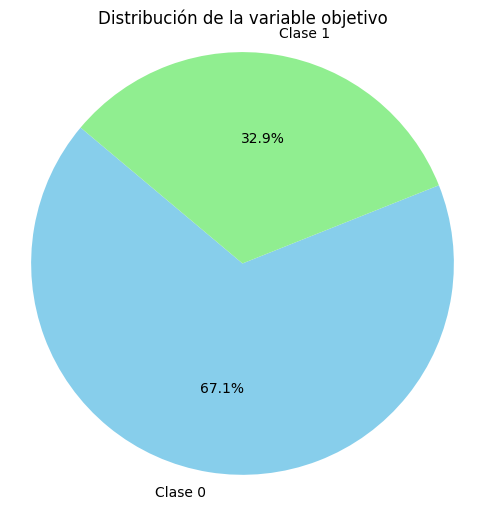

In [ ]:
# Gráfico de tarta de la variable objetivo
plt.figure(figsize=(6, 6))
plt.pie(df_hip_1['target'].value_counts(), labels=['Clase 0', 'Clase 1'], autopct='%1.1f%%',
        colors=['skyblue', 'lightgreen'], startangle=140)
plt.axis('equal')
plt.title('Distribución de la variable objetivo')
plt.show()

Tenemos una serie de columnas que solo tienen un valor, por lo que no añaden información relevante para nuestro análisis, vamos a proceder a eliminarlas.

In [ ]:
# Identificamos las columnas con un único valor
columnas_un_valor = df_hip_1.columns[df_hip_1.nunique() == 1]

# Eliminamos las columnas
df_hip_1.drop(columnas_un_valor, axis=1, inplace=True)

# Comprobamos la dimensión del dataframe resultante
df_hip_1.shape

(490, 44)

He eliminado las columnas que solo contienen un valor único. En total, se eliminaron 9 columnas: 'z6_colorante_ptd', 'z6_dabeersen_503__dissolvine_d_40', 'z6_vibracolor_citrus_yellow', 'arginine', 'cera_de_abejas_beewax', 'natrlquest_e_30', 'perfume_cosmetic_6044p', 'silkrom_wa_40', y 'vaselina_filante_nz41_em'.

Ahora el conjunto de datos tiene 44 columnas en lugar de las 52 originales.

En total, disponemos de 490 registros para nuestro análisis.

**Análisis univariante**

Generaremos histogramas para las variables numéricas y gráficos de barras para las variables categóricas.

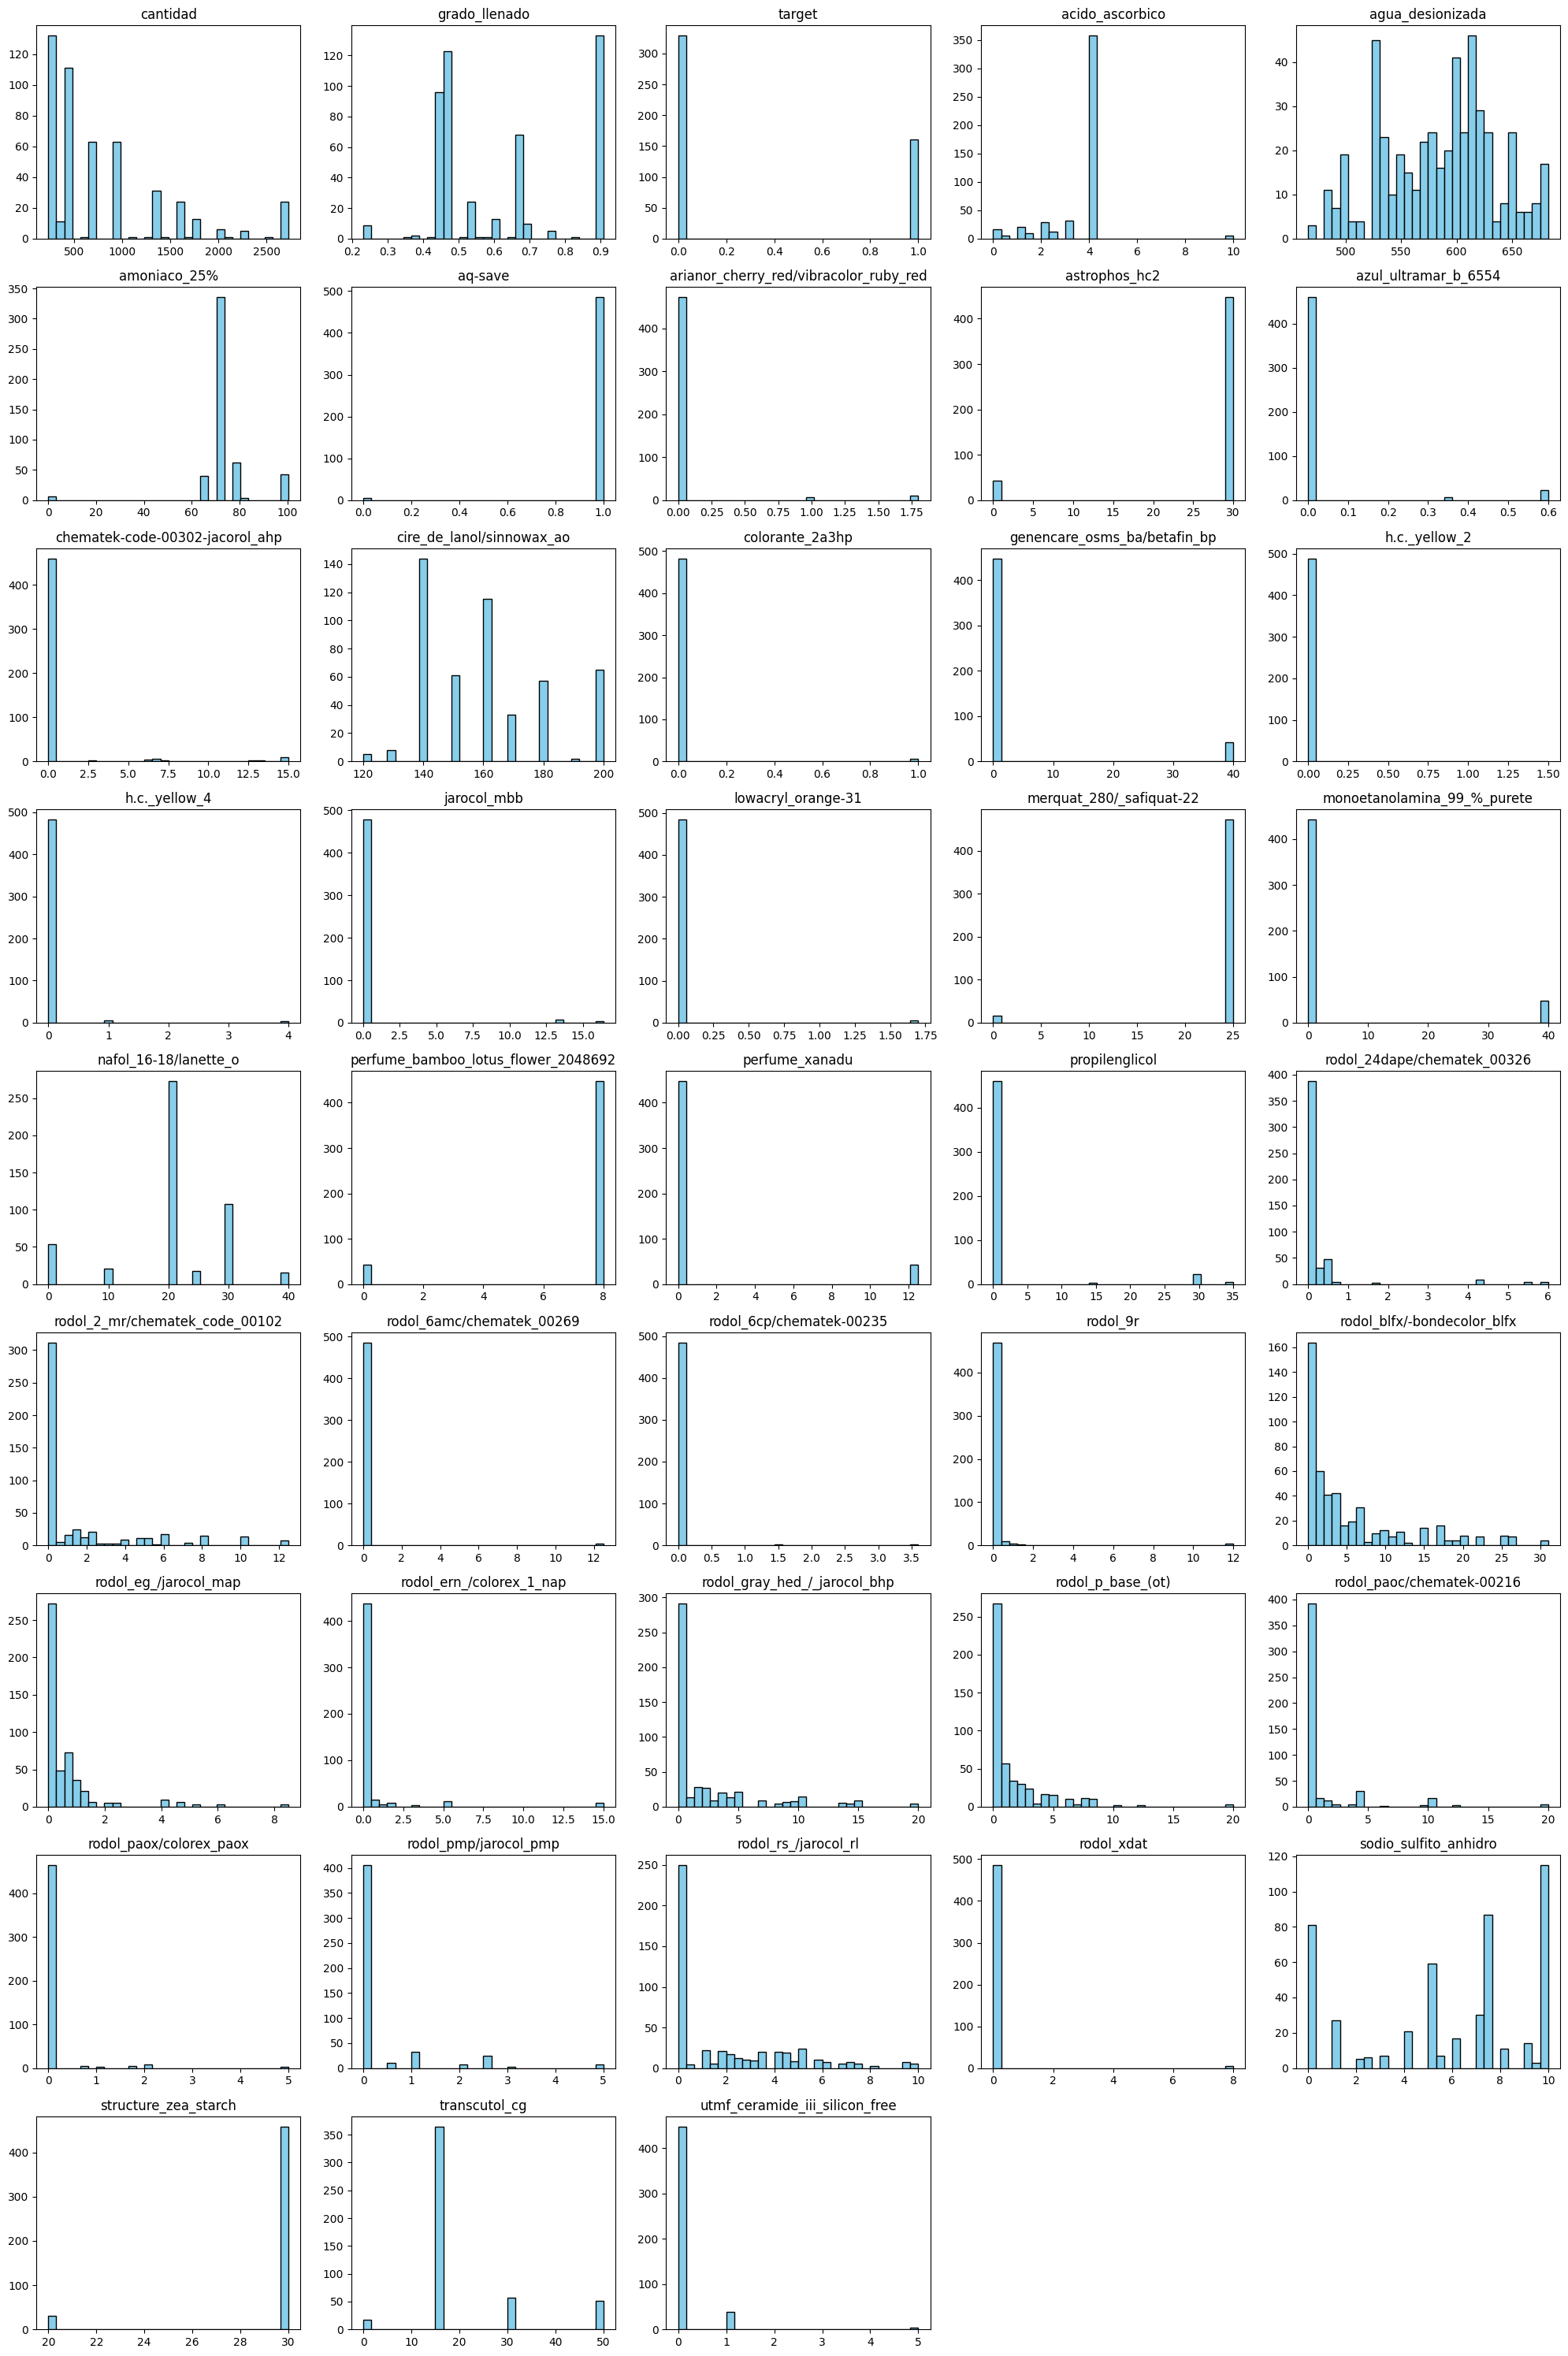

In [ ]:
# Separamos las variables numérias y categóricas
numerical_variables = df_hip_1.select_dtypes(include=['int64', 'float64']).columns
categorical_variables = df_hip_1.select_dtypes(include=['object']).columns

# Creación de los gráficos
fig = plt.figure(figsize=(20, 30))
plt.subplots_adjust(hspace=0.5)

# Dibujamos los gráficos de las variables numéricas
for i, num_var in enumerate(numerical_variables):
    plt.subplot(9, 5, i+1)
    plt.hist(df_hip_1[num_var], bins=30, color='skyblue', edgecolor='black')
    plt.title(num_var)

plt.tight_layout()
plt.show()


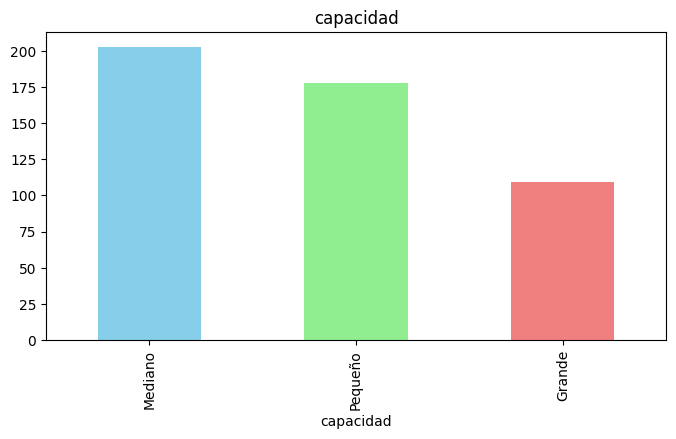

In [ ]:
# Dibujamos las variables categóricas
for cat_var in categorical_variables:
    plt.figure(figsize=(8, 4))
    df_hip_1[cat_var].value_counts().plot(kind='bar', color=['skyblue', 'lightgreen', 'lightcoral'])
    plt.title(cat_var)
    plt.show()


En el análisis univariante, examinamos cada variable por separado. A partir de los histogramas y gráficos de barras generados, podemos sacar algunas conclusiones:

1. **Variables numéricas:** Muchas de las variables numéricas parecen ser binarias (es decir, solo toman dos valores únicos). Algunas de estas variables tienen una distribución desequilibrada, con la mayoría de las observaciones concentradas en uno de los dos valores. Por ejemplo, las variables 'z6_beta_caroteno_10%', 'z6_beta_caroteno_30%', 'z6_beta_caroteno_1%', entre otras, tienen la mayoría de sus valores en 0. Por otro lado, algunas variables como 'z6_beta_caroteno_22%' presentan una distribución más equilibrada entre 0 y 1.

2. **Variable categórica (capacidad):** La mayoría de las observaciones caen en la categoría 'Mediano'. Esto sugiere que la 'capacidad' de la mayoría de los productos en el conjunto de datos es 'Mediano'. Sin embargo, también hay una cantidad significativa de productos con capacidad 'Alto' y 'Bajo'.

Estas observaciones pueden ser útiles para entender las características de los datos y pueden informar la estrategia de modelado. Por ejemplo, si una variable numérica binaria está altamente desequilibrada, podría ser menos útil para la clasificación, ya que la mayoría de las observaciones tienen el mismo valor. Sin embargo, esto dependerá en última instancia del rendimiento del modelo y puede ser evaluado durante la etapa de selección de características.

**Análisis bivariante**

Calcularemos las correlaciones de todas las variables numéricas con la variable objetivo. Luego, seleccionaremos las 10 variables numéricas con la mayor correlación (ya sea positiva o negativa) para incluirlas en el gráfico.

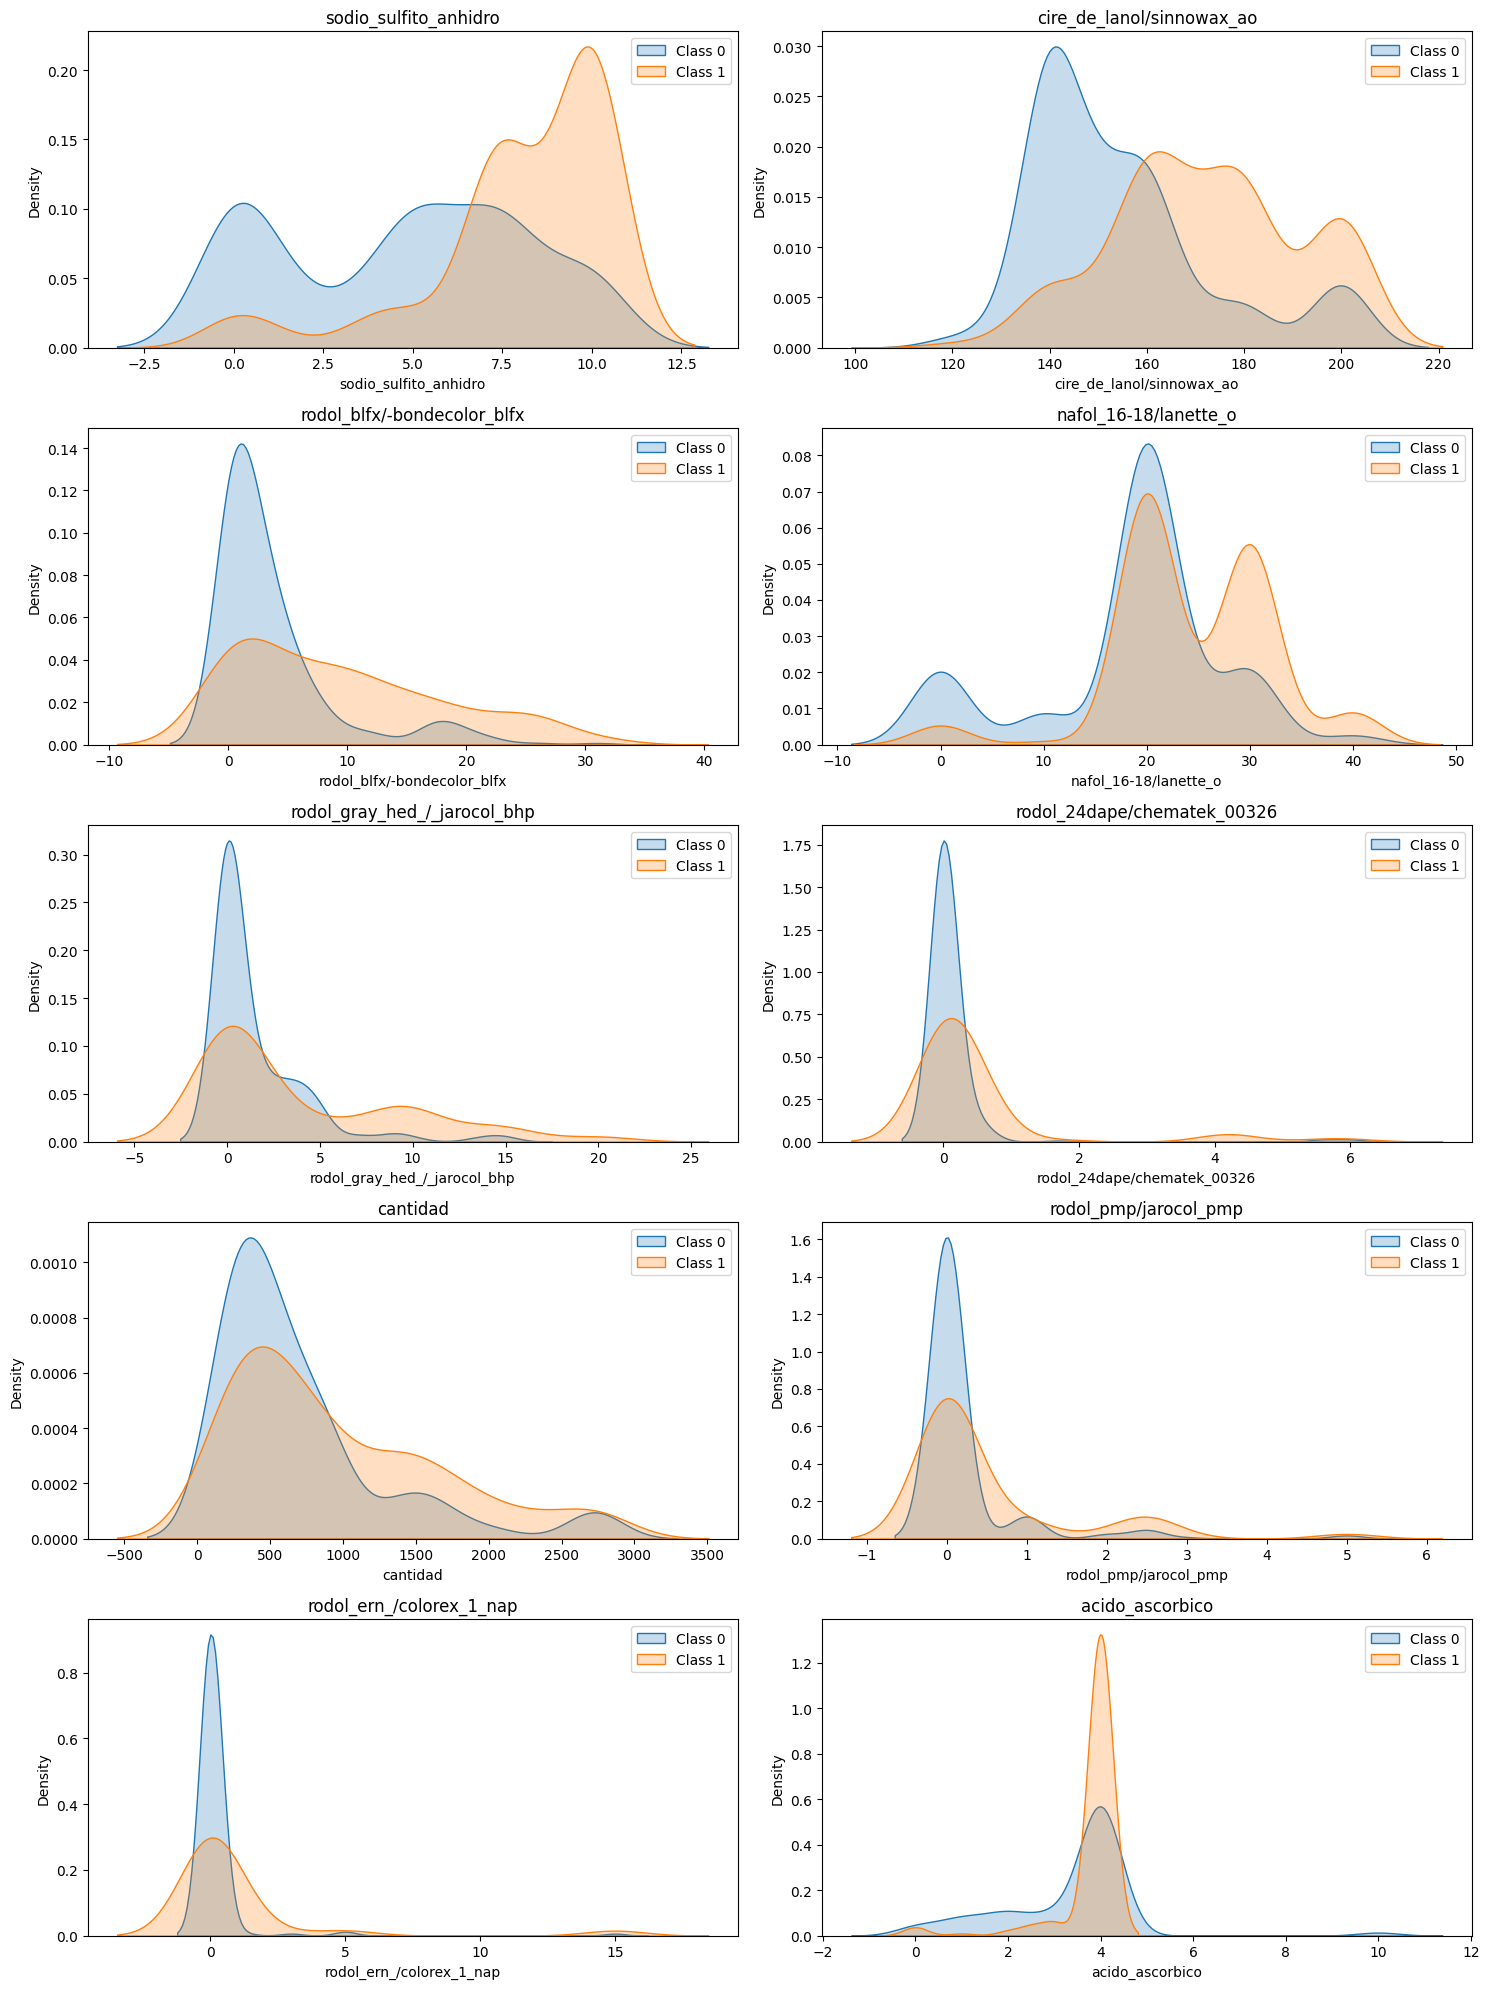

In [ ]:
# Correlación de variables numéricas con la variable objetivo
correlations = df_hip_1[numerical_variables].corrwith(df_hip_1['target']).sort_values(ascending=False)

# Seleccionamos las 10 variables con más correlación
selected_num_vars = correlations[1:11].index

# Cremos grid con las densidades para cada clase
fig, axs = plt.subplots(5, 2, figsize=(15, 20))
fig.subplots_adjust(hspace = 0.5, wspace=.2)
axs = axs.ravel()

for i in range(10):
    sns.kdeplot(df_hip_1[df_hip_1['target'] == 0][selected_num_vars[i]], fill=True, ax=axs[i], label='Class 0', warn_singular=False)
    sns.kdeplot(df_hip_1[df_hip_1['target'] == 1][selected_num_vars[i]], fill=True, ax=axs[i], label='Class 1', warn_singular=False)
    axs[i].set_title(selected_num_vars[i])
    axs[i].legend(loc='upper right')

plt.tight_layout()
plt.show();


Creamos un gráfico de barras apiladas para la variable categórica 'capacidad', separado por la clase de la variable objetivo. Esto nos permitirá ver la distribución de 'capacidad' en cada clase de la variable objetivo.

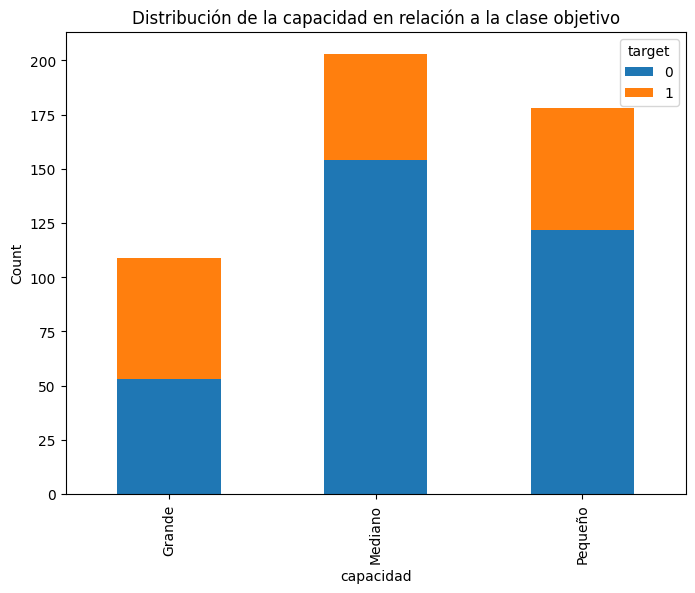

In [ ]:
pd.crosstab(df_hip_1['capacidad'], df_hip_1['target']).plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Distribución de la capacidad en relación a la clase objetivo')
plt.ylabel('Count')
plt.show()


El análisis bivariante nos ayuda a entender la relación entre cada variable y la variable objetivo. A partir de los gráficos de densidad y el gráfico de barras apilado, podemos sacar algunas conclusiones:

1. **Variables numéricas**: Algunas variables parecen tener distribuciones diferentes en las dos clases de la variable objetivo. Esto sugiere que estas variables podrían ser útiles para diferenciar entre las dos clases. Sin embargo, otras variables  tienen distribuciones muy similares en ambas clases, lo que indica que podrían ser menos útiles para la clasificación.

2. **Variable categórica (capacidad)**: La distribución de 'capacidad' parece ser similar en las dos clases de la variable objetivo, con 'Mediano' siendo la categoría más común en ambas clases. Esto sugiere que 'capacidad' podría no ser muy útil para diferenciar entre las clases. Sin embargo, esta es solo una observación preliminar y la utilidad de 'capacidad' para la clasificación debería evaluarse durante la etapa de modelado.

Estas observaciones pueden ser útiles para entender las relaciones entre las características y la variable objetivo.

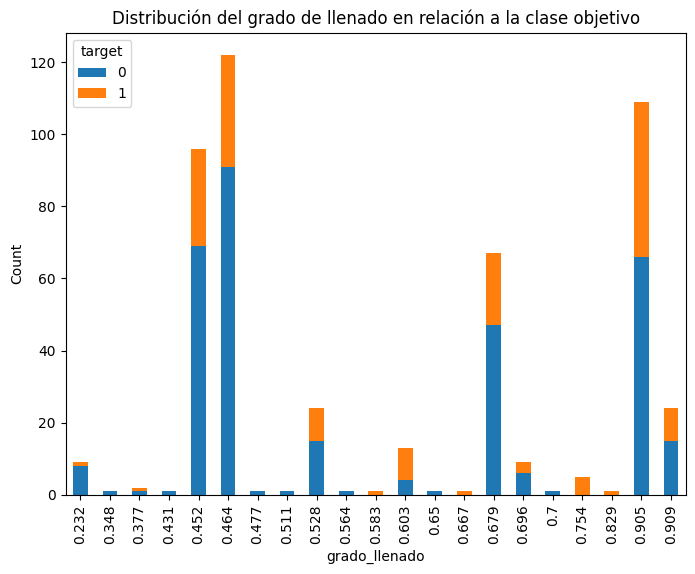

In [ ]:
pd.crosstab(df_hip_1['grado_llenado'], df_hip_1['target']).plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Distribución del grado de llenado en relación a la clase objetivo')
plt.ylabel('Count')
plt.show()

**Matriz de correlación**

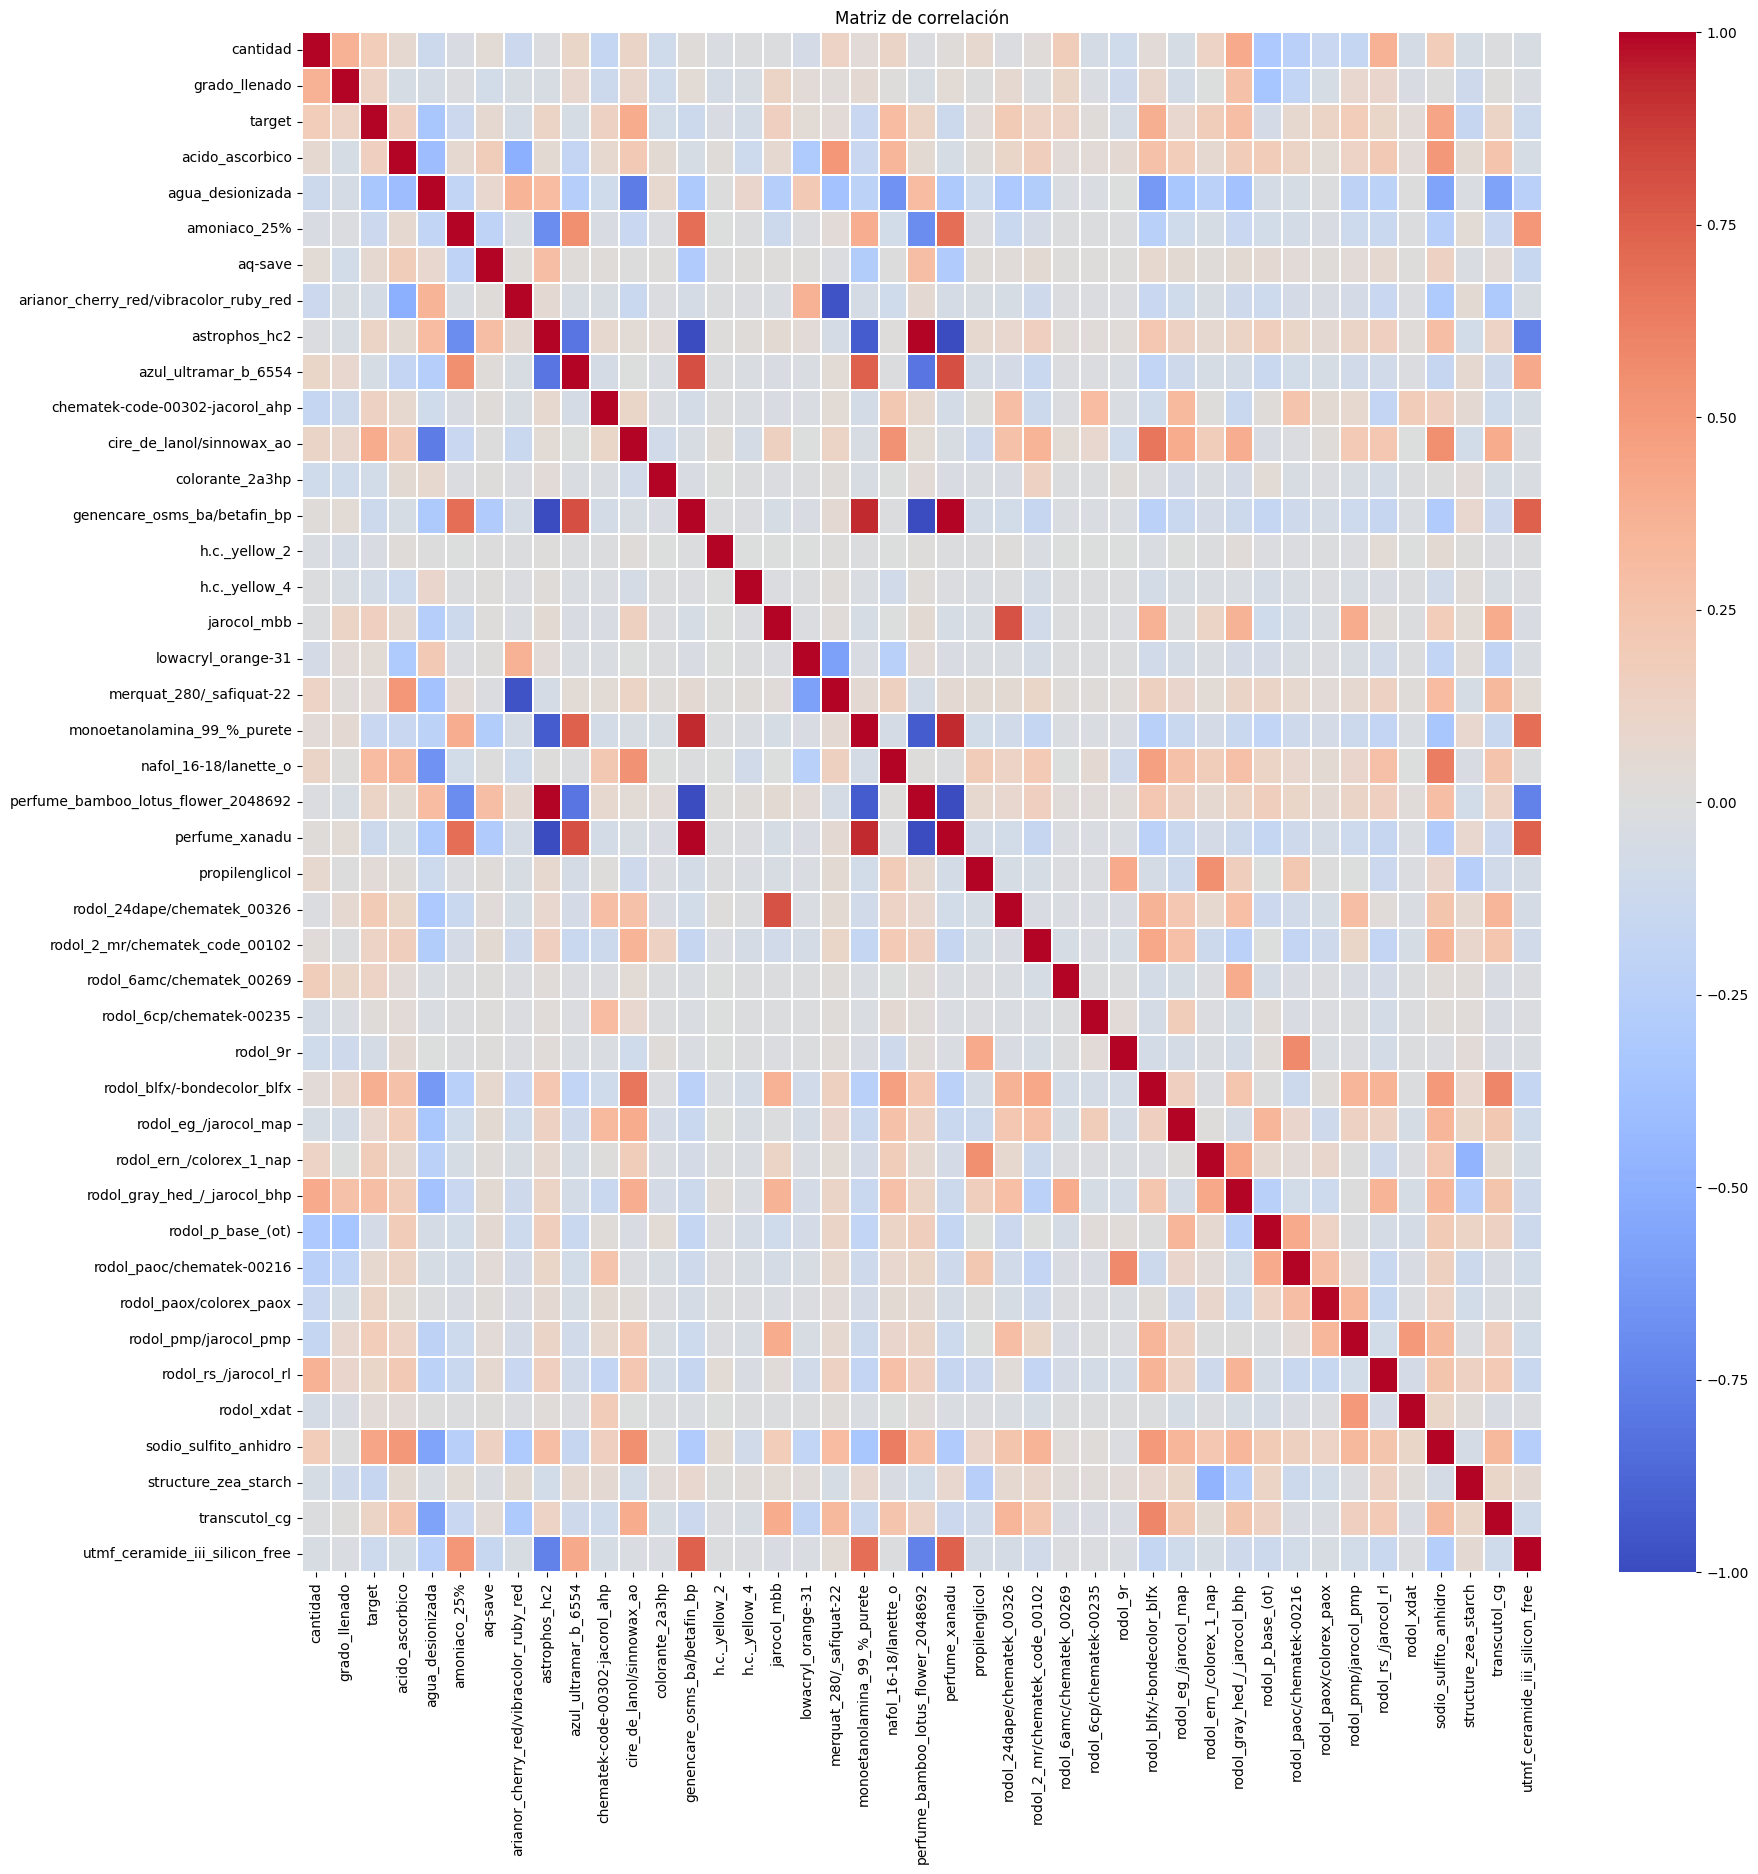

In [ ]:
# Matriz de correlación
corr_matrix_all = df_hip_1[numerical_variables].corr()

# Creando un heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix_all, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.1)
plt.title('Matriz de correlación')
plt.show()

La matriz de correlación nos da una idea de cómo están correlacionadas las variables numéricas entre sí. A partir de la matriz de correlación, podemos sacar algunas conclusiones:

1. **Correlación entre las características**: Algunas características parecen estar fuertemente correlacionadas entre sí.  Esto puede sugerir que estas variables proporcionan información similar, lo que podría llevar a la multicolinealidad si se utilizan juntas en un modelo de aprendizaje automático.

2. **Correlación con la variable objetivo**: Algunas variables parecen tener una correlación más fuerte con la variable objetivo que otras. Sin embargo, como hemos omitido las anotaciones en el mapa de calor debido a la gran cantidad de variables, no podemos identificar las correlaciones exactas desde el gráfico. Para una evaluación más detallada, podría ser útil calcular las correlaciones exactas de cada variable con la variable objetivo.

3. **Multicolinealidad**: La multicolinealidad, o la correlación alta entre las variables predictoras, puede ser problemática en algunos modelos de aprendizaje automático porque puede hacer que las estimaciones de los coeficientes sean inestables y difíciles de interpretar. Si se observa una alta correlación entre las variables predictoras, podríamos considerar estrategias para manejar la multicolinealidad, como la eliminación de variables, la combinación de variables o el uso de técnicas de regularización.

Para reducir el número de columnas en nuestro análisis, voy a eliminar una del par de columnas que tengan una correlación mayor a 0.8

In [ ]:
threshold = 0.8

# Creamos la matriz de correlación
corr_matrix = df_hip_1[numerical_variables].corr().abs()

# Seleccionamos el triángulo superior de la matriz
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Busscamos el indice de las columnas con correlación mayor a la indicada
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Eliminamos las columnas
df_hip_1.drop(to_drop, axis=1, inplace=True)

# Mostramos el tamaño del dataframe final
df_hip_1.shape

(490, 37)

In [ ]:
df_hip_1.head()

,cantidad,capacidad,grado_llenado,target,acido_ascorbico,agua_desionizada,amoniaco_25%,aq-save,arianor_cherry_red/vibracolor_ruby_red,astrophos_hc2,chematek-code-00302-jacorol_ahp,cire_de_lanol/sinnowax_ao,colorante_2a3hp,h.c._yellow_2,h.c._yellow_4,jarocol_mbb,lowacryl_orange-31,nafol_16-18/lanette_o,propilenglicol,rodol_2_mr/chematek_code_00102,rodol_6amc/chematek_00269,rodol_6cp/chematek-00235,rodol_9r,rodol_blfx/-bondecolor_blfx,rodol_eg_/jarocol_map,rodol_ern_/colorex_1_nap,rodol_gray_hed_/_jarocol_bhp,rodol_p_base_(ot),rodol_paoc/chematek-00216,rodol_paox/colorex_paox,rodol_pmp/jarocol_pmp,rodol_rs_/jarocol_rl,rodol_xdat,sodio_sulfito_anhidro,structure_zea_starch,transcutol_cg,utmf_ceramide_iii_silicon_free
0,904.8,Mediano,0.905,1,4.0,501.535,64.965,1,0.0,30,0.0,180,0,0.0,0.0,13.2,0.0,20,0,0.0,0.0,0.0,0.0,25.20,0.90,1.5,9.50,0.00,0.00,0.0,2.5,3.50,0,10.0,30,50,0.0
1,452.4,Pequeño,0.905,0,2.0,613.188,71.862,1,0.0,30,0.0,150,0,0.0,0.0,0.0,0.0,20,0,3.8,0.0,0.0,0.0,4.20,0.25,0.0,0.00,1.50,0.00,0.0,1.0,0.00,0,8.0,30,15,0.0
2,2726.0,Grande,0.909,0,4.0,613.258,71.862,1,0.0,30,0.0,150,0,0.0,0.0,0.0,0.0,20,0,0.0,0.0,0.0,0.0,1.95,0.58,0.0,4.25,0.64,0.00,0.0,0.0,4.46,0,5.0,30,15,0.0
3,2262.0,Grande,0.754,1,3.0,528.232,100.448,1,0.0,0,0.0,160,0,0.0,0.0,0.0,0.0,20,0,0.0,0.0,0.0,0.0,0.48,0.20,0.0,1.60,0.24,0.00,0.0,0.0,1.70,0,4.0,30,15,1.0
4,452.4,Mediano,0.452,0,1.5,535.082,100.448,1,0.0,0,0.0,160,0,0.0,0.0,0.0,0.0,20,0,0.0,0.0,0.0,0.0,0.00,0.10,0.0,0.21,0.00,0.21,0.0,0.0,0.10,0,2.5,30,15,1.0


In [ ]:
df_hip_1.columns

Index(['cantidad', 'capacidad', 'grado_llenado', 'target', 'acido_ascorbico',
       'agua_desionizada', 'amoniaco_25%', 'aq-save',
       'arianor_cherry_red/vibracolor_ruby_red', 'astrophos_hc2',
       'chematek-code-00302-jacorol_ahp', 'cire_de_lanol/sinnowax_ao',
       'colorante_2a3hp', 'h.c._yellow_2', 'h.c._yellow_4', 'jarocol_mbb',
       'lowacryl_orange-31', 'nafol_16-18/lanette_o', 'propilenglicol',
       'rodol_2_mr/chematek_code_00102', 'rodol_6amc/chematek_00269',
       'rodol_6cp/chematek-00235', 'rodol_9r', 'rodol_blfx/-bondecolor_blfx',
       'rodol_eg_/jarocol_map', 'rodol_ern_/colorex_1_nap',
       'rodol_gray_hed_/_jarocol_bhp', 'rodol_p_base_(ot)',
       'rodol_paoc/chematek-00216', 'rodol_paox/colorex_paox',
       'rodol_pmp/jarocol_pmp', 'rodol_rs_/jarocol_rl', 'rodol_xdat',
       'sodio_sulfito_anhidro', 'structure_zea_starch', 'transcutol_cg',
       'utmf_ceramide_iii_silicon_free'],
      dtype='object')

Vamos a realizar unos cálculos estadísticos que indiquen que variables parecen ser más importantes cuando el target es 0.

In [ ]:
# Filtrar el dataframe para considerar solo los registros donde target es 1
data_target_1 = df_hip_1[df_hip_1['target'] == 1]

# Eliminar columnas que no representan productos
product_columns = data_target_1.drop(columns=['target',  'capacidad'])

# Calcular la frecuencia de aparición de cada producto en registros con target 1
product_appearance_frequencies = (product_columns > 0).sum().sort_values(ascending=False)
product_appearance_frequencies_all = (df_hip_1.drop(columns=['target', 'capacidad']) > 0).sum().sort_values(ascending=False)

# Calcular el porcentaje de aparición de cada producto en registros con target 1
product_appearance_percentages = (product_appearance_frequencies / len(data_target_1)) * 100
product_appearance_percentages_all = (product_appearance_frequencies_all / len(df_hip_1)) * 100

# Calcular la media de la cantidad de cada producto en registros con target 1
product_mean_quantities = (product_columns[product_columns> 0]).mean()
product_max_quantities = (product_columns[product_columns> 0]).max()
product_min_quantities = (product_columns[product_columns> 0]).min()

product_mean_quantities_all = df_hip_1.drop(columns=['target', 'capacidad']).mean()
product_max_quantities_all = df_hip_1.drop(columns=['target', 'capacidad']).max()
product_min_quantities_all = df_hip_1.drop(columns=['target', 'capacidad']).min()

# Combinar la frecuencia de aparición en porcentaje y la media de la cantidad en un solo DataFrame
product_summary_df = pd.DataFrame({
    '% en target 1': product_appearance_percentages,
    'Media target 1': product_mean_quantities,
    'Max target 1': product_max_quantities,
    'Min target 1': product_min_quantities,
})

# Filtrar datos para cada reactor y contar apariciones de cada producto
reactor_grande_counts = (product_columns[data_target_1['capacidad'] == 'Grande'] > 0).sum()
reactor_mediano_counts =    (product_columns[data_target_1['capacidad'] == 'Mediano'] > 0).sum()
reactor_pequeno_counts = (product_columns[data_target_1['capacidad'] == 'Pequeño'] > 0).sum()

reactor_grande_counts_all = (df_hip_1[df_hip_1['capacidad'] == 'Grande'].drop(columns=['target', 'capacidad']) > 0).sum()
reactor_mediano_counts_all = (df_hip_1[df_hip_1['capacidad'] == 'Mediano'].drop(columns=['target', 'capacidad']) > 0).sum()
reactor_pequeno_counts_all = (df_hip_1[df_hip_1['capacidad'] == 'Pequeño'].drop(columns=['target', 'capacidad']) > 0).sum()

product_summary_df_all = pd.DataFrame({
    '% en target 1': product_appearance_percentages,
    '% en total': product_appearance_percentages_all,
    'Media target 1': product_mean_quantities,
    'Media total': product_mean_quantities_all,
    'Max target 1': product_max_quantities,
    'Max total': product_max_quantities_all,
    'Min target 1': product_min_quantities,
    'Min total': product_min_quantities_all,
    'Grande target 1': reactor_grande_counts,
    'Grande total': reactor_grande_counts_all,
    'Mediano target 1': reactor_mediano_counts,
    'Mediano total': reactor_mediano_counts_all,
    'Pequeño target 1': reactor_pequeno_counts,
    'Pequeño total': reactor_pequeno_counts_all,
})

product_summary_df_all = product_summary_df_all.sort_values(by='% en target 1', ascending=False)

product_summary_df_all

,% en target 1,% en total,Media target 1,Media total,Max target 1,Max total,Min target 1,Min total,Grande target 1,Grande total,Mediano target 1,Mediano total,Pequeño target 1,Pequeño total
cire_de_lanol/sinnowax_ao,100.000000,100.000000,172.422360,160.408163,200.000,200.000,120.000,120.000,56,109,49,203,56,178
structure_zea_starch,100.000000,100.000000,28.819876,29.367347,30.000,30.000,20.000,20.000,56,109,49,203,56,178
amoniaco_25%,100.000000,100.000000,71.681882,73.827922,100.448,100.448,64.965,0.100,56,109,49,203,56,178
aq-save,100.000000,99.183673,1.000000,0.991837,1.000,1.000,1.000,0.000,56,109,49,202,56,175
grado_llenado,100.000000,100.000000,0.658317,0.622655,0.909,0.909,0.232,0.232,56,109,49,203,56,178
agua_desionizada,100.000000,100.000000,560.376758,584.458006,682.338,682.338,483.938,466.238,56,109,49,203,56,178
cantidad,100.000000,100.000000,967.063354,791.174755,2726.000,2726.000,232.000,232.000,56,109,49,203,56,178
acido_ascorbico,97.515528,96.530612,3.878981,3.479592,4.000,10.000,1.000,0.000,56,109,48,199,53,165
transcutol_cg,97.515528,96.530612,22.420382,19.867347,50.000,50.000,15.000,0.000,56,109,48,199,53,165
astrophos_hc2,96.273292,91.428571,30.000000,27.428571,30.000,30.000,30.000,0.000,53,100,46,180,56,168


In [ ]:
# # Guardo en local una copia del dataframe resultante
# df_hip_1.to_csv('datos_hipotesis_1_1.csv', index=False)

### Modelos de predicción

#### Preparación de los datos

Vamos a probar varios modelos de predicción, previamente necesitamos realizar una serie de pasos para preparar el dataframe de datos:

1. Codificar la columna categórica ("capacidad") en números, ya que los modelos de machine learning trabajan mejor con números.
2. Dividir el conjunto de datos en conjuntos de entrenamiento y prueba.
3. Estandarizar las características numéricas para que todas estén en la misma escala.
4. Probar varios modelos de clasificación y evaluar su rendimiento.



In [ ]:
# Codificamos la columna categórica "capacidad"

# One-hot encode
df_pred_1 = pd.get_dummies(df_hip_1)

# Separamos las variables explicativas y objetivo
X_1 = df_pred_1.drop('target', axis=1)
y_1 = df_pred_1['target']

# Dividimos Train y Test
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3, random_state=42, stratify=y_1)

# Estandarizamos las columnas numéricas
scaler = StandardScaler()
X_train_scaled_1 = scaler.fit_transform(X_train_1)
X_test_scaled_1 = scaler.transform(X_test_1)

In [ ]:
X_1.columns

Index(['cantidad', 'grado_llenado', 'acido_ascorbico', 'agua_desionizada',
       'amoniaco_25%', 'aq-save', 'arianor_cherry_red/vibracolor_ruby_red',
       'astrophos_hc2', 'chematek-code-00302-jacorol_ahp',
       'cire_de_lanol/sinnowax_ao', 'colorante_2a3hp', 'h.c._yellow_2',
       'h.c._yellow_4', 'jarocol_mbb', 'lowacryl_orange-31',
       'nafol_16-18/lanette_o', 'propilenglicol',
       'rodol_2_mr/chematek_code_00102', 'rodol_6amc/chematek_00269',
       'rodol_6cp/chematek-00235', 'rodol_9r', 'rodol_blfx/-bondecolor_blfx',
       'rodol_eg_/jarocol_map', 'rodol_ern_/colorex_1_nap',
       'rodol_gray_hed_/_jarocol_bhp', 'rodol_p_base_(ot)',
       'rodol_paoc/chematek-00216', 'rodol_paox/colorex_paox',
       'rodol_pmp/jarocol_pmp', 'rodol_rs_/jarocol_rl', 'rodol_xdat',
       'sodio_sulfito_anhidro', 'structure_zea_starch', 'transcutol_cg',
       'utmf_ceramide_iii_silicon_free', 'capacidad_Grande',
       'capacidad_Mediano', 'capacidad_Pequeño'],
      dtype='object')

In [ ]:
X_1.head()

,cantidad,grado_llenado,acido_ascorbico,agua_desionizada,amoniaco_25%,aq-save,arianor_cherry_red/vibracolor_ruby_red,astrophos_hc2,chematek-code-00302-jacorol_ahp,cire_de_lanol/sinnowax_ao,colorante_2a3hp,h.c._yellow_2,h.c._yellow_4,jarocol_mbb,lowacryl_orange-31,nafol_16-18/lanette_o,propilenglicol,rodol_2_mr/chematek_code_00102,rodol_6amc/chematek_00269,rodol_6cp/chematek-00235,rodol_9r,rodol_blfx/-bondecolor_blfx,rodol_eg_/jarocol_map,rodol_ern_/colorex_1_nap,rodol_gray_hed_/_jarocol_bhp,rodol_p_base_(ot),rodol_paoc/chematek-00216,rodol_paox/colorex_paox,rodol_pmp/jarocol_pmp,rodol_rs_/jarocol_rl,rodol_xdat,sodio_sulfito_anhidro,structure_zea_starch,transcutol_cg,utmf_ceramide_iii_silicon_free,capacidad_Grande,capacidad_Mediano,capacidad_Pequeño
0,904.8,0.905,4.0,501.535,64.965,1,0.0,30,0.0,180,0,0.0,0.0,13.2,0.0,20,0,0.0,0.0,0.0,0.0,25.20,0.90,1.5,9.50,0.00,0.00,0.0,2.5,3.50,0,10.0,30,50,0.0,False,True,False
1,452.4,0.905,2.0,613.188,71.862,1,0.0,30,0.0,150,0,0.0,0.0,0.0,0.0,20,0,3.8,0.0,0.0,0.0,4.20,0.25,0.0,0.00,1.50,0.00,0.0,1.0,0.00,0,8.0,30,15,0.0,False,False,True
2,2726.0,0.909,4.0,613.258,71.862,1,0.0,30,0.0,150,0,0.0,0.0,0.0,0.0,20,0,0.0,0.0,0.0,0.0,1.95,0.58,0.0,4.25,0.64,0.00,0.0,0.0,4.46,0,5.0,30,15,0.0,True,False,False
3,2262.0,0.754,3.0,528.232,100.448,1,0.0,0,0.0,160,0,0.0,0.0,0.0,0.0,20,0,0.0,0.0,0.0,0.0,0.48,0.20,0.0,1.60,0.24,0.00,0.0,0.0,1.70,0,4.0,30,15,1.0,True,False,False
4,452.4,0.452,1.5,535.082,100.448,1,0.0,0,0.0,160,0,0.0,0.0,0.0,0.0,20,0,0.0,0.0,0.0,0.0,0.00,0.10,0.0,0.21,0.00,0.21,0.0,0.0,0.10,0,2.5,30,15,1.0,False,True,False


In [ ]:
# Código para guardar el scaler que utilizamos en la solución final.

# import joblib

# # Guardamos el scaler
# joblib.dump(scaler, 'scaler.pkl')

In [ ]:
# Creo otro set de datos sin la columna `grado_llenado`
df_pred_1B = df_hip_1.drop('grado_llenado', axis=1)

# One-hot encode
df_pred_1B = pd.get_dummies(df_pred_1B)

# Separamos las variables explicativas y objetivo
X_1B = df_pred_1B.drop('target', axis=1)
y_1B = df_pred_1B['target']

# Dividimos Train y Test
X_train_1B, X_test_1B, y_train_1B, y_test_1B = train_test_split(X_1B, y_1B, test_size=0.3, random_state=42, stratify=y_1B)

# Estandarizamos las columnas numéricas
scaler = StandardScaler()
X_train_scaled_1B = scaler.fit_transform(X_train_1B)
X_test_scaled_1B = scaler.transform(X_test_1B)


In [ ]:
# df_pred_1B.to_csv('sin grado llenado.csv')

#### Test de varios modelos

Vamos a hacer una prueba sobre varios modelos para seleccionar sobre aquellos que tengan un mejor rendimiento con los parámetros por defecto

In [ ]:
def test_inicial_modelos(x_train, y_train, x_test, y_test):
    # Creamos una lista de clasificadores
    classifiers = [
        LogisticRegression(),
        SVC(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        GradientBoostingClassifier(),
        KNeighborsClassifier(),
        XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # Para evitar mensajes de warning
    ]

    # Entrenamos y evaluamos cada clasificador
    results = []

    for clf in classifiers:
        # Entrenamos el clasificador
        clf.fit(x_train, y_train)

        # Hacemos la predicción
        y_pred = clf.predict(x_test)

        # Evaluamos las predicciones
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        # Guardamos los resultados
        results.append({
            'Classifier': clf.__class__.__name__,
            'Accuracy': accuracy,
            'Recall': recall,
            'F1 Score': f1,
            'Confusion Matrix': cm
        })

    # Convertimos el resultado en un dataframe
    results_df = pd.DataFrame(results)

    # Ordenamos por la precisión
    results_df_sorted = results_df.sort_values(by='Accuracy', ascending=False)

    return results_df_sorted

In [ ]:
results_df_sorted_1 = test_inicial_modelos(X_train_scaled_1, y_train_1, X_test_scaled_1, y_test_1);

results_df_sorted_1

,Classifier,Accuracy,Recall,F1 Score,Confusion Matrix
4,GradientBoostingClassifier,0.843537,0.708333,0.747253,"[[90, 9], [14, 34]]"
0,LogisticRegression,0.823129,0.645833,0.704545,"[[90, 9], [17, 31]]"
1,SVC,0.823129,0.666667,0.711111,"[[89, 10], [16, 32]]"
5,KNeighborsClassifier,0.809524,0.666667,0.695652,"[[87, 12], [16, 32]]"
6,XGBClassifier,0.802721,0.645833,0.681319,"[[87, 12], [17, 31]]"
3,RandomForestClassifier,0.789116,0.625000,0.659341,"[[86, 13], [18, 30]]"
2,DecisionTreeClassifier,0.775510,0.520833,0.602410,"[[89, 10], [23, 25]]"


In [ ]:
# Realizo el mismo cálculo sin la columna grado de llenado
results_df_sorted_1B = test_inicial_modelos(X_train_scaled_1B, y_train_1B, X_test_scaled_1B, y_test_1B);

results_df_sorted_1B

,Classifier,Accuracy,Recall,F1 Score,Confusion Matrix
0,LogisticRegression,0.836735,0.666667,0.727273,"[[91, 8], [16, 32]]"
4,GradientBoostingClassifier,0.836735,0.687500,0.733333,"[[90, 9], [15, 33]]"
1,SVC,0.829932,0.666667,0.719101,"[[90, 9], [16, 32]]"
5,KNeighborsClassifier,0.823129,0.708333,0.723404,"[[87, 12], [14, 34]]"
6,XGBClassifier,0.802721,0.645833,0.681319,"[[87, 12], [17, 31]]"
3,RandomForestClassifier,0.795918,0.625000,0.666667,"[[87, 12], [18, 30]]"
2,DecisionTreeClassifier,0.775510,0.520833,0.602410,"[[89, 10], [23, 25]]"


Vemos que tenemos unos resultados muy similares, vamos a hacer una búsqueda de hiperparámetros para ver si obtenemos una mejor precisión

#### Búsqueda de mejores parámetros en los modelos con mejores resultados

Hacemos un gridsearch para los modelos para ver si mejoramos la precisión.

In [ ]:
import time

def cronometrar(func):
    def envoltura(*args, **kwargs):
        inicio = time.time()
        resultado = func(*args, **kwargs)
        fin = time.time()
        print(f"{func.__name__} tardó {fin - inicio} segundos en ejecutarse.")
        return resultado
    return envoltura

In [ ]:
@cronometrar
def busqueda_mejores_parametros(x_train, y_train):
    # Definimos el grid de parámetros para los diferentes clasificadores
    param_grids = {
        'LogisticRegression': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'penalty': ['l1', 'l2'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
        },
        'SVC': {
            'C': [0.1, 1, 10, 100],
            'gamma': [1, 0.1, 0.01, 0.001],
            'kernel': ['linear', 'rbf']
        },
        'DecisionTreeClassifier': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'RandomForestClassifier': {
            'n_estimators': [10, 50, 100, 200],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'GradientBoostingClassifier': {
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'n_estimators': [100, 200, 500],
            'max_depth': [4, 6, 8],
            'min_samples_leaf': [20, 50,100,150]
        },
        'KNeighborsClassifier': {
            'n_neighbors': list(range(1, 30)),
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
        },
        'XGBClassifier': {
            'n_estimators': [50, 100, 150, 200],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'max_depth': [3, 4, 5, 6],
            'colsample_bytree': [0.3, 0.4, 0.5, 0.7]
        }
    }

    # Definimos los clasificadores
    classifiers = {
        'LogisticRegression': LogisticRegression(random_state=42),
        'SVC': SVC(),
        'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
        'RandomForestClassifier': RandomForestClassifier(random_state=42),
        'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
        'KNeighborsClassifier': KNeighborsClassifier(),
        'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    }

    # PRealizamos la búsqueda para cada clasificador
    best_params_all = {}
    best_scores_all = {}

    for clf_name, clf in classifiers.items():
        print(f"Performing grid search for {clf_name}...")

        param_grid = param_grids[clf_name]
        grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=0, n_jobs=-1);
        grid_search.fit(x_train, y_train);

        best_params_all[clf_name] = grid_search.best_params_
        best_scores_all[clf_name] = grid_search.best_score_

    return (best_params_all, best_scores_all)

In [ ]:
best_params_1, best_scores_1 = busqueda_mejores_parametros(X_train_scaled_1, y_train_1);
best_params_1B, best_scores_1B = busqueda_mejores_parametros(X_train_scaled_1B, y_train_1B);

Performing grid search for LogisticRegression...


Performing grid search for SVC...
Performing grid search for DecisionTreeClassifier...
Performing grid search for RandomForestClassifier...
Performing grid search for GradientBoostingClassifier...
Performing grid search for KNeighborsClassifier...
Performing grid search for XGBClassifier...
busqueda_mejores_parametros tardó 91.54397535324097 segundos en ejecutarse.
Performing grid search for LogisticRegression...
Performing grid search for SVC...
Performing grid search for DecisionTreeClassifier...
Performing grid search for RandomForestClassifier...
Performing grid search for GradientBoostingClassifier...
Performing grid search for KNeighborsClassifier...
Performing grid search for XGBClassifier...
busqueda_mejores_parametros tardó 83.49779653549194 segundos en ejecutarse.


In [ ]:
def test_modelos_params(x_train, y_train, x_test, y_test, params):
    # Definimos los modelso con los hiperparámetros
    best_models = {
        'LogisticRegression': LogisticRegression(**params['LogisticRegression'], random_state=42),
        'SVC': SVC(**params['SVC']),
        'DecisionTreeClassifier': DecisionTreeClassifier(**params['DecisionTreeClassifier'], random_state=42),
        'RandomForestClassifier': RandomForestClassifier(**params['RandomForestClassifier'], random_state=42),
        'GradientBoostingClassifier': GradientBoostingClassifier(**params['GradientBoostingClassifier'], random_state=42),
        'KNeighborsClassifier': KNeighborsClassifier(**params['KNeighborsClassifier']),
        'XGBClassifier': XGBClassifier(**params['XGBClassifier'], random_state=42)
    }

    # Evaluamos cada modelo
    best_model_results = []

    for clf_name, clf in best_models.items():
        # Entrenamos el modelo
        clf.fit(x_train, y_train)

        # Hacemos las predicciones
        y_pred = clf.predict(x_test)

        # Evaluamos las predicciones
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        # Guardamos los resultados
        best_model_results.append({
            'Classifier': clf_name,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Recall': recall,
            'Confusion Matrix': cm
        })

    # Convertimos los resultados en un dataframe
    best_model_results_df = pd.DataFrame(best_model_results)

    # Ordenamos por la precisión
    results_df_sorted = best_model_results_df.sort_values(by='Accuracy', ascending=False)

    return results_df_sorted


In [ ]:
results_1 = test_modelos_params(X_train_scaled_1, y_train_1, X_test_scaled_1, y_test_1, best_params_1)
results_1B = test_modelos_params(X_train_scaled_1B, y_train_1B, X_test_scaled_1B, y_test_1B, best_params_1B)

In [ ]:
best_params_1

{'LogisticRegression': {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'},
 'SVC': {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'},
 'DecisionTreeClassifier': {'criterion': 'entropy',
  'max_depth': 20,
  'min_samples_leaf': 4,
  'min_samples_split': 10},
 'RandomForestClassifier': {'max_depth': 10,
  'max_features': 'log2',
  'min_samples_leaf': 4,
  'min_samples_split': 10,
  'n_estimators': 50},
 'GradientBoostingClassifier': {'learning_rate': 0.02,
  'max_depth': 4,
  'min_samples_leaf': 20,
  'n_estimators': 100},
 'KNeighborsClassifier': {'algorithm': 'auto',
  'n_neighbors': 18,
  'weights': 'distance'},
 'XGBClassifier': {'colsample_bytree': 0.4,
  'learning_rate': 0.01,
  'max_depth': 4,
  'n_estimators': 100}}

In [ ]:
results_1

,Classifier,Accuracy,F1 Score,Recall,Confusion Matrix
6,XGBClassifier,0.863946,0.772727,0.708333,"[[93, 6], [14, 34]]"
4,GradientBoostingClassifier,0.843537,0.747253,0.708333,"[[90, 9], [14, 34]]"
3,RandomForestClassifier,0.836735,0.733333,0.687500,"[[90, 9], [15, 33]]"
0,LogisticRegression,0.829932,0.719101,0.666667,"[[90, 9], [16, 32]]"
1,SVC,0.816327,0.682353,0.604167,"[[91, 8], [19, 29]]"
2,DecisionTreeClassifier,0.816327,0.682353,0.604167,"[[91, 8], [19, 29]]"
5,KNeighborsClassifier,0.775510,0.629213,0.583333,"[[86, 13], [20, 28]]"


In [ ]:
results_1B

,Classifier,Accuracy,F1 Score,Recall,Confusion Matrix
1,SVC,0.850340,0.744186,0.666667,"[[93, 6], [16, 32]]"
0,LogisticRegression,0.836735,0.727273,0.666667,"[[91, 8], [16, 32]]"
3,RandomForestClassifier,0.836735,0.739130,0.708333,"[[89, 10], [14, 34]]"
4,GradientBoostingClassifier,0.836735,0.739130,0.708333,"[[89, 10], [14, 34]]"
6,XGBClassifier,0.829932,0.725275,0.687500,"[[89, 10], [15, 33]]"
2,DecisionTreeClassifier,0.816327,0.689655,0.625000,"[[90, 9], [18, 30]]"
5,KNeighborsClassifier,0.789116,0.659341,0.625000,"[[86, 13], [18, 30]]"


El modelo que mejor resultado da es `XGBClassifier` teniendo  en cuenta el  `grado_llenado`, selecciono esté modelo porque es el que tiene mejor sensibilidad.

In [ ]:
# Muestro los mejores parámetros para GradientBoostingClassifier
print(best_params_1["XGBClassifier"])

xgb = XGBClassifier(**best_params_1["XGBClassifier"], random_state=42)

xgb.fit(X_train_scaled_1, y_train_1)

y_pred_1 = xgb.predict(X_test_scaled_1)

print("Accuracy:", accuracy_score(y_test_1, y_pred_1))
print("f1_score:", f1_score(y_test_1, y_pred_1, average="weighted"))

{'colsample_bytree': 0.4, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
Accuracy: 0.8639455782312925
f1_score: 0.860403119765117


In [ ]:
# # Guardo el modelo y el scaler
# import joblib

# joblib.dump(xgb, 'xgb_model.pkl')
# joblib.dump(scaler, 'scaler.pkl')


In [ ]:
# # plot decision tree
# from numpy import loadtxt
# from xgboost import plot_tree
# import matplotlib.pyplot as plt

# plt.figure(figsize=(30, 15))  # Ajusta el tamaño según tus preferencias
# plot_tree(xgb, num_trees=1, ax=plt.gca())
# plt.savefig('tree.png', dpi=600)  # Guardar la imagen
# plt.show()

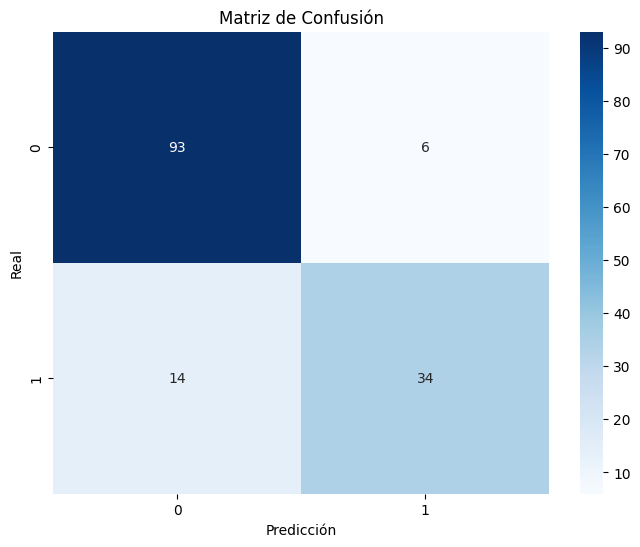

In [ ]:
def matriz_confusion(y_test, y_pred):
    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Dibujar la matriz de confusión con Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

matriz_confusion(y_test_1, y_pred_1)

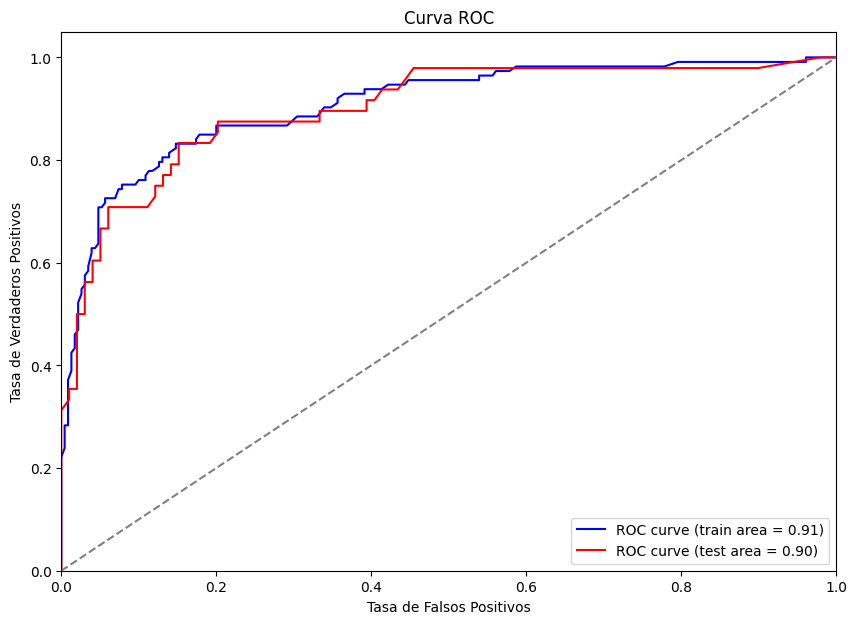

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def curva_roc(x_train, y_train, x_test, y_test, model):
    # 1. Calcular las probabilidades de la clase positiva
    y_train_prob = model.predict_proba(x_train)[:,1]
    y_test_prob = model.predict_proba(x_test)[:,1]

    # 2. Calcular TPR y FPR para diferentes umbrales
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_test = auc(fpr_test, tpr_test)

    # 3. Graficar TPR vs. FPR
    plt.figure(figsize=(10,7))
    plt.plot(fpr_train, tpr_train, color='blue', label=f'ROC curve (train area = {roc_auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, color='red', label=f'ROC curve (test area = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()

curva_roc(X_train_scaled_1, y_train_1, X_test_scaled_1, y_test_1, xgb)

In [ ]:
# 1. Obtener las importancias de las características
importances = xgb.feature_importances_

# 2. Emparejar importancias con los nombres de las columnas
feature_names = X_1.columns

# Crear un DataFrame con las importancias y los nombres de las características
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Ordenar el DataFrame por importancia de mayor a menor
sorted_importance_df = importance_df.sort_values(by='Importance', ascending=False)

sorted_importance_df

,Feature,Importance
9,cire_de_lanol/sinnowax_ao,0.088173
31,sodio_sulfito_anhidro,0.087638
3,agua_desionizada,0.081180
7,astrophos_hc2,0.072995
21,rodol_blfx/-bondecolor_blfx,0.059481
34,utmf_ceramide_iii_silicon_free,0.052882
32,structure_zea_starch,0.046133
8,chematek-code-00302-jacorol_ahp,0.038521
15,nafol_16-18/lanette_o,0.038072
4,amoniaco_25%,0.036775


In [ ]:
# from xgboost import plot_tree

# plt.figure(figsize=(20, 10))
# plot_tree(xgb, num_trees=0, rankdir='LR')
# plt.show()

Los valores de importancia de las columnas son muy pequeños, por lo que no hay ninguna variable que destaque sobre las demás, si no que la viscosidad depende de la combinación de todas las variables.

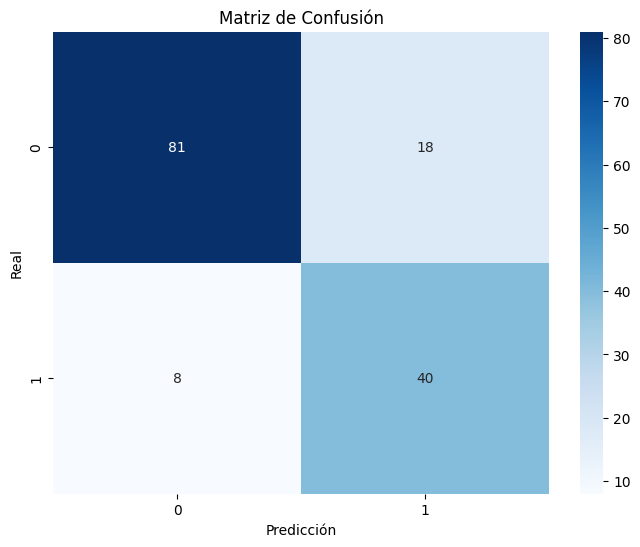

Accuracy: 0.8231292517006803
f1_score: 0.8267682022628402


In [ ]:
# Obtener las probabilidades predichas
probabilities = xgb.predict_proba(X_test_scaled_1)[:, 1]

# Ajustar el umbral
threshold = 0.4
predictions = [1 if prob >= threshold else 0 for prob in probabilities]

matriz_confusion(y_test_1, predictions)

print("Accuracy:", accuracy_score(y_test_1, predictions))
print("f1_score:", f1_score(y_test_1, predictions, average="weighted"))

Cambiando el valor del a probabilidad, tenemos una mejor sensibilidad, por lo que reduciomos el número de falsos negativos.

Vamos a comprobar el mejor resultado en el caso de que no utilizamos el grado de llenado y vamos a comprobar si hay sobreajuste o no.

In [ ]:
print(best_params_1B['SVC'])

svc = SVC(**best_params_1B['SVC'])

svc.fit(X_train_scaled_1B, y_train_1B)

y_pred_1B = svc.predict(X_test_scaled_1B)

print('Accuracy: ', accuracy_score(y_test_1B, y_pred_1B))
print('F1 Score: ', f1_score(y_test_1B, y_pred_1B, average='weighted'))

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy:  0.8503401360544217
F1 Score:  0.845236574057172


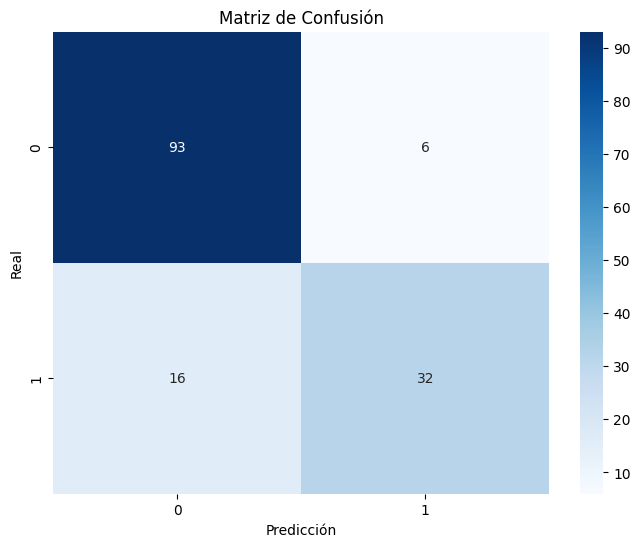

In [ ]:
matriz_confusion(y_test_1B, y_pred_1B)

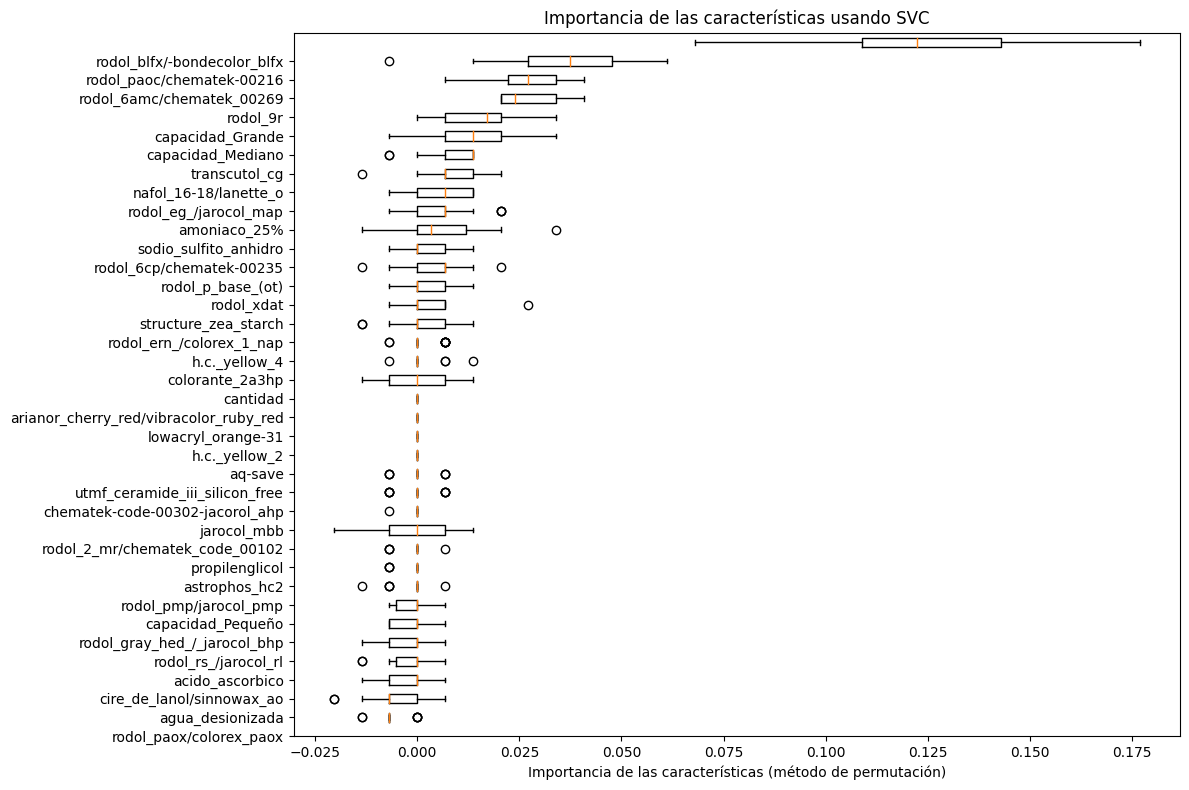

In [ ]:
from sklearn.inspection import permutation_importance

# Obtener la importancia de las características utilizando el método de permutación
result = permutation_importance(svc, X_test_scaled_1B, y_test_1B, n_repeats=30, random_state=42)

# Ordenar las características por importancia
sorted_idx = result.importances_mean.argsort()

# Visualizar la importancia de las características
plt.figure(figsize=(12, 8))
plt.boxplot(result.importances[sorted_idx].T, vert=False)
plt.yticks(range(len(sorted_idx)), X_test_1B.columns[sorted_idx])
plt.xlabel('Importancia de las características (método de permutación)')
plt.title('Importancia de las características usando SVC')
plt.tight_layout()
plt.show()

Vamos a hacer las comprobaciones para la hipótesis 1B, para ver si tenemos sobreajuste o no.

Accuracy:  0.8503401360544217
F1 Score:  0.845236574057172


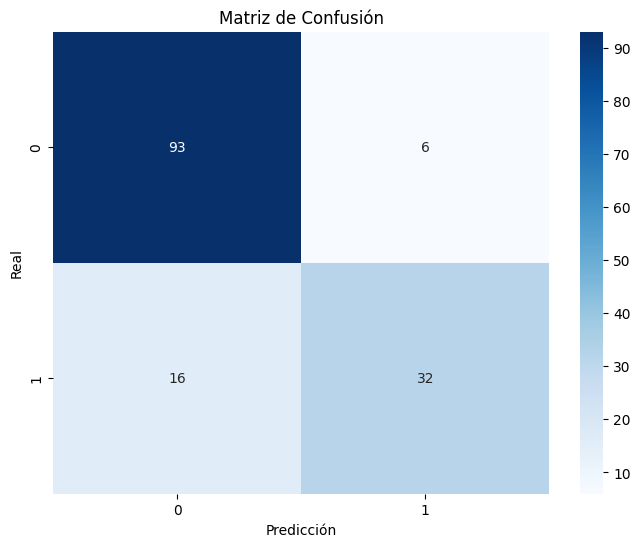

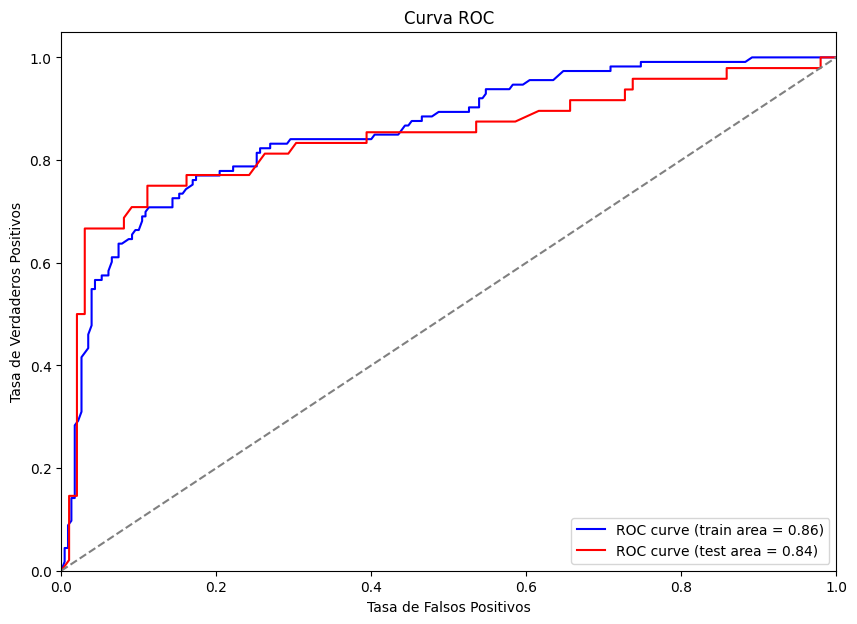

In [ ]:
svc = SVC(**best_params_1B['SVC'], probability=True)

svc.fit(X_train_scaled_1B, y_train_1B)

y_pred_1B = svc.predict(X_test_scaled_1B)

print('Accuracy: ', accuracy_score(y_test_1B, y_pred_1B))
print('F1 Score: ', f1_score(y_test_1B, y_pred_1B, average='weighted'))

matriz_confusion(y_test_1B, y_pred_1B)

curva_roc(X_train_scaled_1B, y_train_1B, X_test_scaled_1B, y_test_1B, svc)

- En este caso, tenemos un resultado un poco peor que utilizando el grado de llenado, por lo que podemos concluir que es un dato importante.
- En este caso, tenemos un poco más de sobreajuste, pero aun así, podemos considerar que es un resultado válido.


## Hipótesis 2: Cantidad total de componentes

En esta hipótesis, voy a realizar los mismos pasos que en la hipótesis 1, pero en vez de utilizar las proporciones de los componentes, voy a utilizar los valores absolutos de los componentes.

In [ ]:
# Hago una copia del dataframe de la hipotesis 1
df_hip_2 = df.copy()
# Convierto el nombre de las columnas aminúsculas, y substituyo los espacios por guiones bajos,
# además quito los guines bajos al principio y final de cada nombre de columna
df_hip_2.columns = df_hip_2.columns.str.lower().str.replace(' ', '_').str.strip('_')
# Convierto el campo de fecha clvdate_medicion que me servirá para la ordenación
df_hip_2["clvdate_medicion"] = pd.to_datetime(df_hip_2["clvdate_medicion"], format="mixed")
# Filtro el dataframe para los registros que tienen el campo nmediciont = 1, que son los que tienen los datos de la primera medición
df_hip_2 = df_hip_2[df_hip_2["nmediciont"] == 1]
# Ordenamos por el campo fecha
df_hip_2.sort_values(by=["clvdate_medicion"], inplace=True);
# Recuperamos el primer registro para cada orden
df_hip_2 = df_hip_2.groupby(["wohnumber"]).first().reset_index()
# Creo la nueva columna "grado de llenado"
df_hip_2['grado_llenado'] = df_hip_2['wmdquantity1'] / df_hip_2['capacidad']
# Redondear a tres decimales
df_hip_2['grado_llenado'] = df_hip_2['grado_llenado'].round(3)
# Selecciono las columnas que voy a necesitar para esta primera hipótesis
df_hip_2 = df_hip_2[['matcode', 'wmdquantity1', 'mgdvaluemin', 'viscosidad_muestras', 'capacidad', 'grado_llenado']]
df_hip_2["viscosidad_muestras"] = df_hip_2["viscosidad_muestras"].astype(float)
df_hip_2["target"] = df_hip_2.apply(lambda x: 0 if (x["viscosidad_muestras"] >= x["mgdvaluemin"]) else 1, axis=1)
df_hip_2.drop(["viscosidad_muestras", "mgdvaluemin"], axis=1, inplace=True)
substitucion = {
    3000: 'Grande',
    1000: 'Mediano',
    500: 'Pequeño'
}
df_hip_2['capacidad'] = df_hip_2['capacidad'].replace(substitucion)
# Renombramos la columna wmdquantity1
df_hip_2 = df_hip_2.rename(columns={'wmdquantity1': 'cantidad'})
df_componentes = pd.read_excel('desgloses tintes.xlsx')
df_componentes.columns = df_componentes.columns.str.lower().str.replace(' ', '_').str.strip()
df_componentes.head()
# Voy a limipiar los datos de la columna texto_breve_del_objeto de los tintes
# Elimino los caracteres especiales por espacios, solo dejo letras y números, convierto todo el texto en minúsculas
df_componentes["texto_breve_del_objeto"] = df_componentes["texto_breve_del_objeto"].str.replace('[^a-zA-Z0-9 \n\.]', '_').str.lower()
# Si queda algún espacio, pongo un subrayado, si hay más de un subrayado seguido, lo quito
df_componentes["texto_breve_del_objeto"] = df_componentes["texto_breve_del_objeto"].str.replace(' ', '_').str.replace('__', '_')
df_componentes = df_componentes.pivot_table(index=['material'], columns=['texto_breve_del_objeto'], values=['cantidad_componente'],fill_value=0)
df_componentes = df_componentes.reset_index()
df_componentes.columns = df_componentes.columns.droplevel(level=0)
df_componentes = df_componentes.rename(columns={'': 'material'})
df_componentes['material'] = df_componentes['material'].astype(str)
df_hip_2.matcode = df_hip_2.matcode.astype(str)
df_hip_2 = pd.merge(df_hip_2, df_componentes, left_on='matcode', right_on='material', how='left')
df_hip_2.drop(['matcode', 'material'], axis=1, inplace=True)
df_hip_2.columns = df_hip_2.columns.str.lower().str.replace(' ', '_').str.strip('_')


In [ ]:
df_hip_2.head()

,cantidad,capacidad,grado_llenado,target,*z6*dabeersen-503_/_dissolvine_d-40,*z6_colorante_ptd,*z6_vibracolor_citrus_yellow,acido_ascorbico,agua_desionizada,amoniaco_25%,aq-save,arginine,arianor_cherry_red/vibracolor_ruby_red,astrophos_hc2,azul_ultramar_b_6554,cera_de_abejas-beewax,chematek-code-00302-jacorol_ahp,cire_de_lanol/sinnowax_ao,colorante_2a3hp,genencare_osms_ba/betafin_bp,h.c._yellow_2,h.c._yellow_4,jarocol_mbb,lowacryl_orange-31,merquat_280/_safiquat-22,monoetanolamina_99_%_purete,nafol_16-18/lanette_o,natrlquest_e_30,perfume_bamboo_lotus_flower_2048692,perfume_cosmetic_6044p,perfume_xanadu,propilenglicol,rodol_24dape/chematek_00326,rodol_2_mr/chematek_code_00102,rodol_6amc/chematek_00269,rodol_6cp/chematek-00235,rodol_9r,rodol_blfx/-bondecolor_blfx,rodol_eg_/jarocol_map,rodol_ern_/colorex_1_nap,rodol_gray_hed_/_jarocol_bhp,rodol_p_base_(ot),rodol_paoc/chematek-00216,rodol_paox/colorex_paox,rodol_pmp/jarocol_pmp,rodol_rs_/jarocol_rl,rodol_xdat,silkrom_wa_40,sodio_sulfito_anhidro,structure_zea_starch,transcutol_cg,utmf_ceramide_iii_silicon_free,vaselina_filante_nz41-em
0,904.8,Mediano,0.905,1,0.0,0.0,0.0,4.0,501.535,64.965,1,2,0.0,30,0.00,0,0.0,180,0,0,0.0,0.0,13.2,0.0,25,0,20,3,8,0.0,0.0,0,4.2,0.0,0.0,0.0,0.0,25.20,0.90,1.5,9.50,0.00,0.00,0.0,2.5,3.50,0,10,10.0,30,50,0.0,0
1,452.4,Pequeño,0.905,0,0.0,0.0,0.0,2.0,613.188,71.862,1,2,0.0,30,0.00,0,0.0,150,0,0,0.0,0.0,0.0,0.0,25,0,20,3,8,0.0,0.0,0,0.2,3.8,0.0,0.0,0.0,4.20,0.25,0.0,0.00,1.50,0.00,0.0,1.0,0.00,0,10,8.0,30,15,0.0,0
2,2726.0,Grande,0.909,0,0.0,0.0,0.0,4.0,613.258,71.862,1,2,0.0,30,0.00,0,0.0,150,0,0,0.0,0.0,0.0,0.0,25,0,20,3,8,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.95,0.58,0.0,4.25,0.64,0.00,0.0,0.0,4.46,0,10,5.0,30,15,0.0,0
3,2262.0,Grande,0.754,1,0.0,0.0,0.0,3.0,528.232,100.448,1,2,0.0,0,0.60,0,0.0,160,0,40,0.0,0.0,0.0,0.0,25,40,20,3,0,0.0,12.5,0,0.0,0.0,0.0,0.0,0.0,0.48,0.20,0.0,1.60,0.24,0.00,0.0,0.0,1.70,0,10,4.0,30,15,1.0,0
4,452.4,Mediano,0.452,0,0.0,0.0,0.0,1.5,535.082,100.448,1,2,0.0,0,0.35,0,0.0,160,0,40,0.0,0.0,0.0,0.0,25,40,20,3,0,0.0,12.5,0,0.0,0.0,0.0,0.0,0.0,0.00,0.10,0.0,0.21,0.00,0.21,0.0,0.0,0.10,0,10,2.5,30,15,1.0,0


In [ ]:
# Para cada componente, del que tenemos la proporción, voy a multiplicar por la cantidad y dividir por 1000, ya que la proporción está en base 1000
columnas = df_hip_2.columns
columnas

Index(['cantidad', 'capacidad', 'grado_llenado', 'target',
       '*z6*dabeersen-503_/_dissolvine_d-40', '*z6_colorante_ptd',
       '*z6_vibracolor_citrus_yellow', 'acido_ascorbico', 'agua_desionizada',
       'amoniaco_25%', 'aq-save', 'arginine',
       'arianor_cherry_red/vibracolor_ruby_red', 'astrophos_hc2',
       'azul_ultramar_b_6554', 'cera_de_abejas-beewax',
       'chematek-code-00302-jacorol_ahp', 'cire_de_lanol/sinnowax_ao',
       'colorante_2a3hp', 'genencare_osms_ba/betafin_bp', 'h.c._yellow_2',
       'h.c._yellow_4', 'jarocol_mbb', 'lowacryl_orange-31',
       'merquat_280/_safiquat-22', 'monoetanolamina_99_%_purete',
       'nafol_16-18/lanette_o', 'natrlquest_e_30',
       'perfume_bamboo_lotus_flower_2048692', 'perfume_cosmetic_6044p',
       'perfume_xanadu', 'propilenglicol', 'rodol_24dape/chematek_00326',
       'rodol_2_mr/chematek_code_00102', 'rodol_6amc/chematek_00269',
       'rodol_6cp/chematek-00235', 'rodol_9r', 'rodol_blfx/-bondecolor_blfx',
       'ro

In [ ]:
df_hip_2[columnas[4:]] = df_hip_2[columnas[4:]].apply(lambda x: x * df_hip_2['cantidad'] / 1000.0)

In [ ]:
df_hip_2.head()

,cantidad,capacidad,grado_llenado,target,*z6*dabeersen-503_/_dissolvine_d-40,*z6_colorante_ptd,*z6_vibracolor_citrus_yellow,acido_ascorbico,agua_desionizada,amoniaco_25%,aq-save,arginine,arianor_cherry_red/vibracolor_ruby_red,astrophos_hc2,azul_ultramar_b_6554,cera_de_abejas-beewax,chematek-code-00302-jacorol_ahp,cire_de_lanol/sinnowax_ao,colorante_2a3hp,genencare_osms_ba/betafin_bp,h.c._yellow_2,h.c._yellow_4,jarocol_mbb,lowacryl_orange-31,merquat_280/_safiquat-22,monoetanolamina_99_%_purete,nafol_16-18/lanette_o,natrlquest_e_30,perfume_bamboo_lotus_flower_2048692,perfume_cosmetic_6044p,perfume_xanadu,propilenglicol,rodol_24dape/chematek_00326,rodol_2_mr/chematek_code_00102,rodol_6amc/chematek_00269,rodol_6cp/chematek-00235,rodol_9r,rodol_blfx/-bondecolor_blfx,rodol_eg_/jarocol_map,rodol_ern_/colorex_1_nap,rodol_gray_hed_/_jarocol_bhp,rodol_p_base_(ot),rodol_paoc/chematek-00216,rodol_paox/colorex_paox,rodol_pmp/jarocol_pmp,rodol_rs_/jarocol_rl,rodol_xdat,silkrom_wa_40,sodio_sulfito_anhidro,structure_zea_starch,transcutol_cg,utmf_ceramide_iii_silicon_free,vaselina_filante_nz41-em
0,904.8,Mediano,0.905,1,0.0,0.0,0.0,3.6192,453.788868,58.780332,0.9048,1.8096,0.0,27.144,0.00000,0.0,0.0,162.864,0.0,0.000,0.0,0.0,11.94336,0.0,22.62,0.000,18.096,2.7144,7.2384,0.0,0.000,0.0,3.80016,0.00000,0.0,0.0,0.0,22.80096,0.81432,1.3572,8.595600,0.00000,0.000000,0.0,2.2620,3.16680,0.0,9.048,9.0480,27.144,45.240,0.0000,0.0
1,452.4,Pequeño,0.905,0,0.0,0.0,0.0,0.9048,277.406251,32.510369,0.4524,0.9048,0.0,13.572,0.00000,0.0,0.0,67.860,0.0,0.000,0.0,0.0,0.00000,0.0,11.31,0.000,9.048,1.3572,3.6192,0.0,0.000,0.0,0.09048,1.71912,0.0,0.0,0.0,1.90008,0.11310,0.0000,0.000000,0.67860,0.000000,0.0,0.4524,0.00000,0.0,4.524,3.6192,13.572,6.786,0.0000,0.0
2,2726.0,Grande,0.909,0,0.0,0.0,0.0,10.9040,1671.741308,195.895812,2.7260,5.4520,0.0,81.780,0.00000,0.0,0.0,408.900,0.0,0.000,0.0,0.0,0.00000,0.0,68.15,0.000,54.520,8.1780,21.8080,0.0,0.000,0.0,0.00000,0.00000,0.0,0.0,0.0,5.31570,1.58108,0.0000,11.585500,1.74464,0.000000,0.0,0.0000,12.15796,0.0,27.260,13.6300,81.780,40.890,0.0000,0.0
3,2262.0,Grande,0.754,1,0.0,0.0,0.0,6.7860,1194.860784,227.213376,2.2620,4.5240,0.0,0.000,1.35720,0.0,0.0,361.920,0.0,90.480,0.0,0.0,0.00000,0.0,56.55,90.480,45.240,6.7860,0.0000,0.0,28.275,0.0,0.00000,0.00000,0.0,0.0,0.0,1.08576,0.45240,0.0000,3.619200,0.54288,0.000000,0.0,0.0000,3.84540,0.0,22.620,9.0480,67.860,33.930,2.2620,0.0
4,452.4,Mediano,0.452,0,0.0,0.0,0.0,0.6786,242.071097,45.442675,0.4524,0.9048,0.0,0.000,0.15834,0.0,0.0,72.384,0.0,18.096,0.0,0.0,0.00000,0.0,11.31,18.096,9.048,1.3572,0.0000,0.0,5.655,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.04524,0.0000,0.095004,0.00000,0.095004,0.0,0.0000,0.04524,0.0,4.524,1.1310,13.572,6.786,0.4524,0.0


### Análisis exploratorio de los datos

In [ ]:
df_hip_2.dtypes

cantidad                                  float64
capacidad                                  object
grado_llenado                             float64
target                                      int64
*z6*dabeersen-503_/_dissolvine_d-40       float64
*z6_colorante_ptd                         float64
*z6_vibracolor_citrus_yellow              float64
acido_ascorbico                           float64
agua_desionizada                          float64
amoniaco_25%                              float64
aq-save                                   float64
arginine                                  float64
arianor_cherry_red/vibracolor_ruby_red    float64
astrophos_hc2                             float64
azul_ultramar_b_6554                      float64
cera_de_abejas-beewax                     float64
chematek-code-00302-jacorol_ahp           float64
cire_de_lanol/sinnowax_ao                 float64
colorante_2a3hp                           float64
genencare_osms_ba/betafin_bp              float64


In [ ]:
df_hip_2.isnull().sum()

cantidad                                  0
capacidad                                 0
grado_llenado                             0
target                                    0
*z6*dabeersen-503_/_dissolvine_d-40       0
*z6_colorante_ptd                         0
*z6_vibracolor_citrus_yellow              0
acido_ascorbico                           0
agua_desionizada                          0
amoniaco_25%                              0
aq-save                                   0
arginine                                  0
arianor_cherry_red/vibracolor_ruby_red    0
astrophos_hc2                             0
azul_ultramar_b_6554                      0
cera_de_abejas-beewax                     0
chematek-code-00302-jacorol_ahp           0
cire_de_lanol/sinnowax_ao                 0
colorante_2a3hp                           0
genencare_osms_ba/betafin_bp              0
h.c._yellow_2                             0
h.c._yellow_4                             0
jarocol_mbb                     

In [ ]:
# Comprobamos los valores únicos para cada variable
df_hip_2.nunique()

cantidad                                   22
capacidad                                   3
grado_llenado                              21
target                                      2
*z6*dabeersen-503_/_dissolvine_d-40         1
*z6_colorante_ptd                           1
*z6_vibracolor_citrus_yellow                1
acido_ascorbico                            49
agua_desionizada                          234
amoniaco_25%                               57
aq-save                                    23
arginine                                   22
arianor_cherry_red/vibracolor_ruby_red      7
astrophos_hc2                              21
azul_ultramar_b_6554                       15
cera_de_abejas-beewax                       1
chematek-code-00302-jacorol_ahp            15
cire_de_lanol/sinnowax_ao                  68
colorante_2a3hp                             3
genencare_osms_ba/betafin_bp               13
h.c._yellow_2                               2
h.c._yellow_4                     

In [ ]:
df_hip_2['target'].value_counts()

target
0    329
1    161
Name: count, dtype: int64

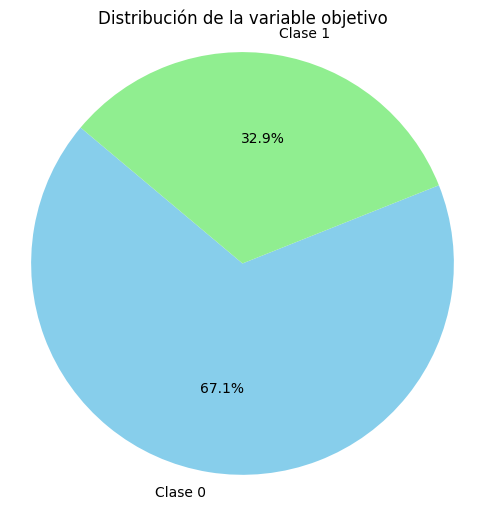

In [ ]:
# Gráfico de tarta de la variable objetivo
plt.figure(figsize=(6, 6))
plt.pie(df_hip_2['target'].value_counts(), labels=['Clase 0', 'Clase 1'], autopct='%1.1f%%',
        colors=['skyblue', 'lightgreen'], startangle=140)
plt.axis('equal')
plt.title('Distribución de la variable objetivo')
plt.show()

In [ ]:
# Identificamos las columnas con un único valor
columnas_un_valor = df_hip_2.columns[df_hip_2.nunique() == 1]

# Eliminamos las columnas
df_hip_2.drop(columnas_un_valor, axis=1, inplace=True)

# Comprobamos la dimensión del dataframe resultante
df_hip_2.shape

(490, 47)

Dibujamos un gráfico tridimensional para ver las relaciones de cantidad, capacidad y componente (`rodol_blfx_bondecolor_blfx`), en relación con el target

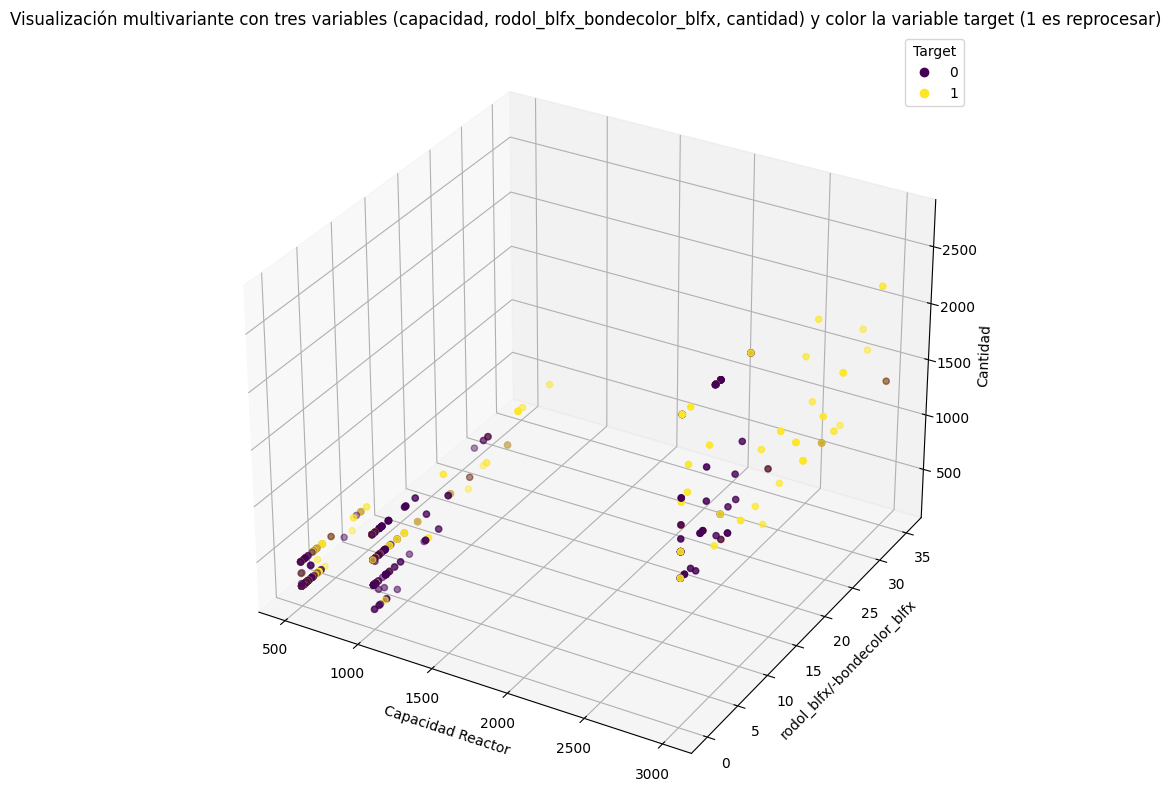

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x = df_hip_2['capacidad'].replace({'Grande': 3000, 'Mediano': 1000, 'Pequeño': 500})
y = df_hip_2['rodol_blfx/-bondecolor_blfx']
z = df_hip_2['cantidad']
c = df_hip_2['target']
scatter = ax.scatter(xs=x, ys=y, zs=z, c=c)
_ = ax.set_xlabel('Capacidad Reactor')
_ = ax.set_ylabel('rodol_blfx/-bondecolor_blfx')
_ = ax.set_zlabel('Cantidad')
_ = plt.title('Visualización multivariante con tres variables (capacidad, rodol_blfx_bondecolor_blfx, cantidad) y color la variable target (1 es reprocesar)')
plt.legend(handles=scatter.legend_elements()[0],
title="Target",
labels=["0", "1"])
plt.show()

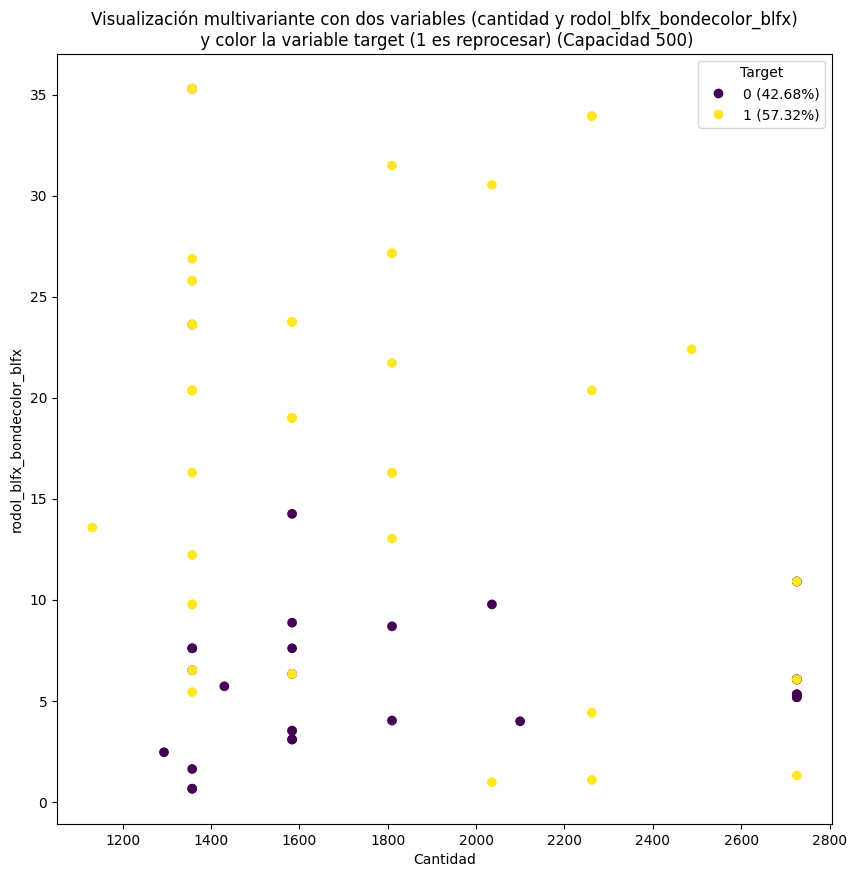

In [ ]:
import matplotlib.pyplot as plt


# Filtrar los datos con capacidad igual a 3000 y cantidad de componente no igual a 0
df_cap_1000 = df_hip_2[(df_hip_2['capacidad'].replace({'Grande': 3000, 'Mediano': 1000, 'Pequeño': 500}) == 3000) & (df_hip_2['rodol_blfx/-bondecolor_blfx'] != 0)]


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)


x = df_cap_1000['cantidad'].replace({'Grande': 3000, 'Mediano': 1000, 'Pequeño': 500})
y = df_cap_1000['rodol_blfx/-bondecolor_blfx']


c = df_cap_1000['target']


scatter = ax.scatter(x, y, c=c)
ax.set_xlabel('Cantidad')
ax.set_ylabel('rodol_blfx_bondecolor_blfx')
plt.title('Visualización multivariante con dos variables (cantidad y rodol_blfx_bondecolor_blfx)\n y color la variable target (1 es reprocesar) (Capacidad 500)')


# Calcular porcentajes de cada color en 'target'
total_points = len(c)
percentage_0 = (c.value_counts()[0] / total_points) * 100
percentage_1 = (c.value_counts()[1] / total_points) * 100


plt.legend(handles=scatter.legend_elements()[0],
           title="Target",
           labels=["0 ({}%)".format(round(percentage_0, 2)),
                   "1 ({}%)".format(round(percentage_1, 2))])


plt.show()


Con el rodol_blfx_bondecolor, las cantidades de componente que se utiliza para una misma cantidad de producto y mismo reactor, se aprecia mejores resultados para cantidades menor  de componente.

In [ ]:
count_non_zero_by_reactor = df_hip_2[df_hip_2['rodol_blfx/-bondecolor_blfx'] != 0].groupby('capacidad').size()
print("Número de valores diferentes de 0 enrodol_blfx_bondecolor_blfx :")
print(count_non_zero_by_reactor)


Número de valores diferentes de 0 enrodol_blfx_bondecolor_blfx :
capacidad
Grande      82
Mediano    159
Pequeño    147
dtype: int64


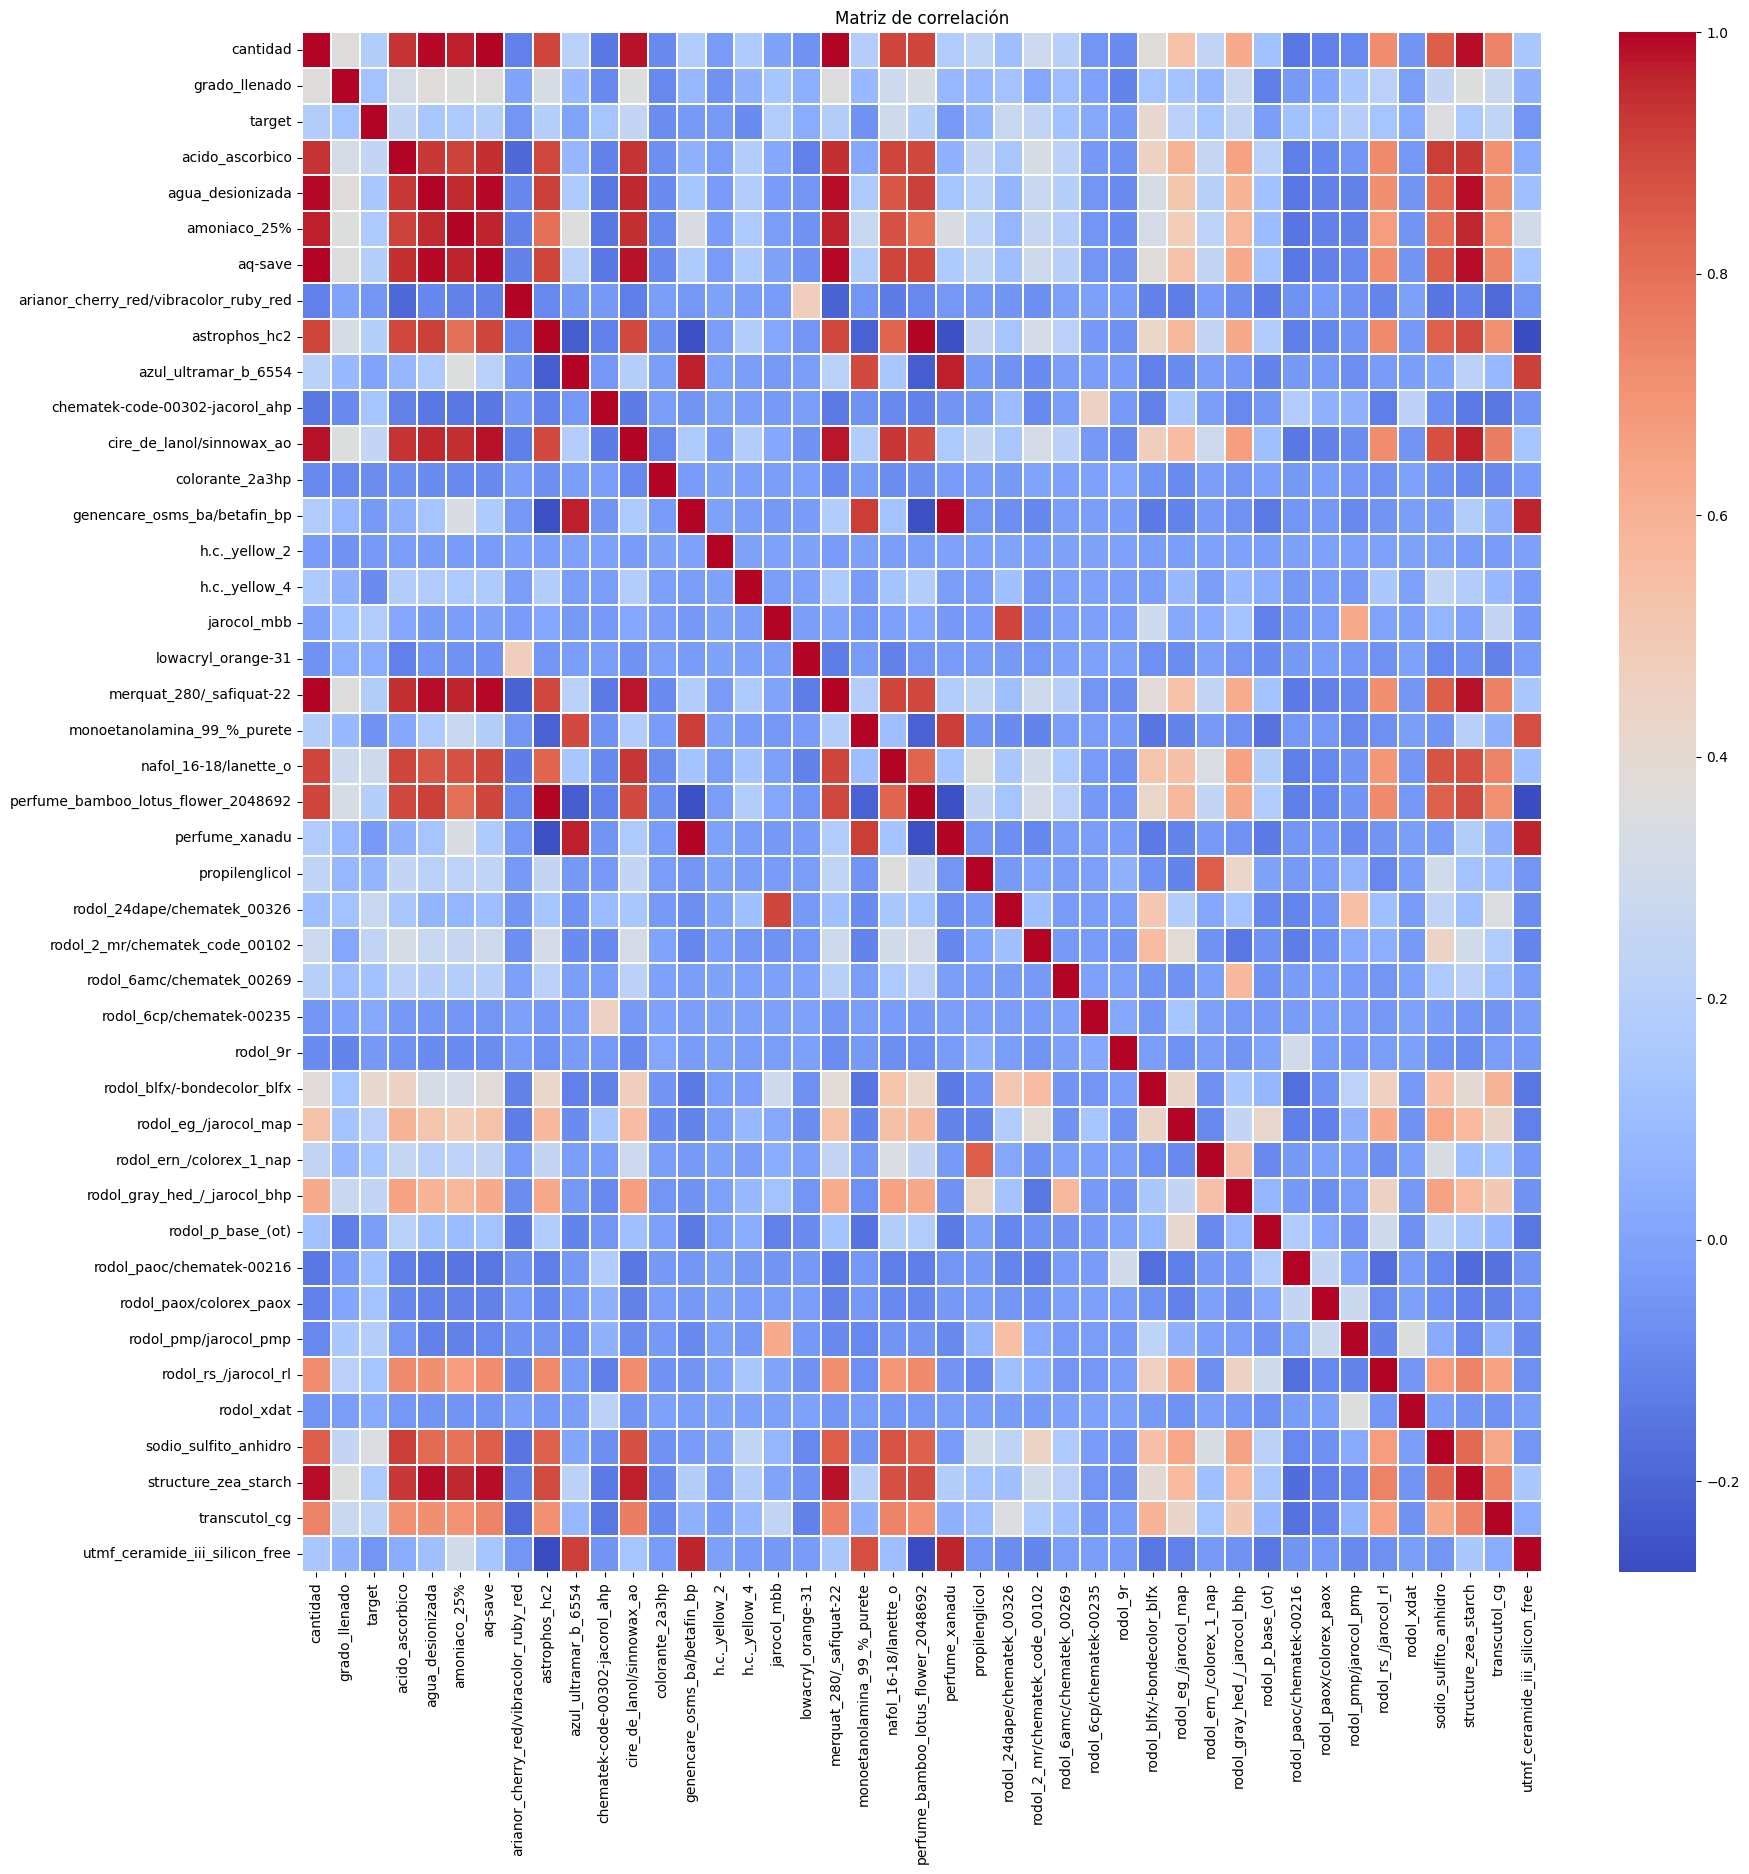

In [ ]:
# Matriz de correlación
corr_matrix_all = df_hip_2[numerical_variables].corr()

# Creando un heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix_all, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.1)
plt.title('Matriz de correlación')
plt.show()

In [ ]:
threshold = 0.8

# Creamos la matriz de correlación
corr_matrix = df_hip_2[numerical_variables].corr().abs()

# Seleccionamos el triángulo superior de la matriz
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Busscamos el indice de las columnas con correlación mayor a la indicada
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('Columns to drop: ', to_drop)

# Eliminamos las columnas
df_hip_2.drop(to_drop, axis=1, inplace=True)

# Mostramos el tamaño del dataframe final
df_hip_2.shape

Columns to drop:  ['acido_ascorbico', 'agua_desionizada', 'amoniaco_25%', 'aq-save', 'astrophos_hc2', 'cire_de_lanol/sinnowax_ao', 'genencare_osms_ba/betafin_bp', 'merquat_280/_safiquat-22', 'monoetanolamina_99_%_purete', 'nafol_16-18/lanette_o', 'perfume_bamboo_lotus_flower_2048692', 'perfume_xanadu', 'rodol_24dape/chematek_00326', 'rodol_ern_/colorex_1_nap', 'sodio_sulfito_anhidro', 'structure_zea_starch', 'utmf_ceramide_iii_silicon_free']


(490, 30)

In [ ]:
# Filtrar el dataframe para considerar solo los registros donde target es 1
data_target_1 = df_hip_2[df_hip_2['target'] == 1]

# Eliminar columnas que no representan productos
product_columns = data_target_1.drop(columns=['target',  'capacidad'])

# Calcular la frecuencia de aparición de cada producto en registros con target 1
product_appearance_frequencies = (product_columns > 0).sum().sort_values(ascending=False)
product_appearance_frequencies_all = (df_hip_2.drop(columns=['target', 'capacidad']) > 0).sum().sort_values(ascending=False)

# Calcular el porcentaje de aparición de cada producto en registros con target 1
product_appearance_percentages = (product_appearance_frequencies / len(data_target_1)) * 100
product_appearance_percentages_all = (product_appearance_frequencies_all / len(df_hip_2)) * 100

# Calcular la media de la cantidad de cada producto en registros con target 1
product_mean_quantities = (product_columns[product_columns> 0]).mean()
product_max_quantities = (product_columns[product_columns> 0]).max()
product_min_quantities = (product_columns[product_columns> 0]).min()

product_mean_quantities_all = df_hip_2.drop(columns=['target', 'capacidad']).mean()
product_max_quantities_all = df_hip_2.drop(columns=['target', 'capacidad']).max()
product_min_quantities_all = df_hip_2.drop(columns=['target', 'capacidad']).min()

# Combinar la frecuencia de aparición en porcentaje y la media de la cantidad en un solo DataFrame
product_summary_df = pd.DataFrame({
    '% en target 1': product_appearance_percentages,
    'Media target 1': product_mean_quantities,
    'Max target 1': product_max_quantities,
    'Min target 1': product_min_quantities,
})

# Filtrar datos para cada reactor y contar apariciones de cada producto
reactor_grande_counts = (product_columns[data_target_1['capacidad'] == 'Grande'] > 0).sum()
reactor_mediano_counts =    (product_columns[data_target_1['capacidad'] == 'Mediano'] > 0).sum()
reactor_pequeno_counts = (product_columns[data_target_1['capacidad'] == 'Pequeño'] > 0).sum()

reactor_grande_counts_all = (df_hip_2[df_hip_2['capacidad'] == 'Grande'].drop(columns=['target', 'capacidad']) > 0).sum()
reactor_mediano_counts_all = (df_hip_2[df_hip_2['capacidad'] == 'Mediano'].drop(columns=['target', 'capacidad']) > 0).sum()
reactor_pequeno_counts_all = (df_hip_2[df_hip_2['capacidad'] == 'Pequeño'].drop(columns=['target', 'capacidad']) > 0).sum()

product_summary_df_all = pd.DataFrame({
    '% en target 1': product_appearance_percentages,
    '% en total': product_appearance_percentages_all,
    'Media target 1': product_mean_quantities,
    'Media total': product_mean_quantities_all,
    'Max target 1': product_max_quantities,
    'Max total': product_max_quantities_all,
    'Min target 1': product_min_quantities,
    'Min total': product_min_quantities_all,
    'Grande target 1': reactor_grande_counts,
    'Grande total': reactor_grande_counts_all,
    'Mediano target 1': reactor_mediano_counts,
    'Mediano total': reactor_mediano_counts_all,
    'Pequeño target 1': reactor_pequeno_counts,
    'Pequeño total': reactor_pequeno_counts_all,
})

product_summary_df_all = product_summary_df_all.sort_values(by='% en target 1', ascending=False)

product_summary_df_all

,% en target 1,% en total,Media target 1,Media total,Max target 1,Max total,Min target 1,Min total,Grande target 1,Grande total,Mediano target 1,Mediano total,Pequeño target 1,Pequeño total
arginine,100.000000,100.000000,1.934127,1.582350,5.45200,5.45200,0.464000,0.464,56,109,49,203,56,178
grado_llenado,100.000000,100.000000,0.658317,0.622655,0.90900,0.90900,0.232000,0.232,56,109,49,203,56,178
silkrom_wa_40,100.000000,100.000000,9.670634,7.911748,27.26000,27.26000,2.320000,2.320,56,109,49,203,56,178
cantidad,100.000000,100.000000,967.063354,791.174755,2726.00000,2726.00000,232.000000,232.000,56,109,49,203,56,178
natrlquest_e_30,100.000000,100.000000,2.901190,2.373524,8.17800,8.17800,0.696000,0.696,56,109,49,203,56,178
transcutol_cg,97.515528,96.530612,21.176032,15.629598,90.48000,90.48000,3.480000,0.000,56,109,48,199,53,165
rodol_blfx/-bondecolor_blfx,83.229814,79.183673,10.697063,4.553377,35.28720,35.28720,0.225040,0.000,47,82,38,159,49,147
rodol_eg_/jarocol_map,64.596273,62.040816,1.001517,0.452849,3.38024,3.38024,0.032480,0.000,47,95,37,138,20,71
rodol_rs_/jarocol_rl,55.900621,53.877551,5.194432,2.165832,25.76070,25.76070,0.046400,0.000,46,88,28,116,16,60
rodol_p_base_(ot),53.416149,63.265306,1.301734,0.725170,3.68010,5.56452,0.092800,0.000,28,62,21,113,37,135


### Modelos de predicción

#### Preparación de los datos

In [ ]:
# Codificamos la columna categórica "capacidad"

# One-hot encode
df_pred_2 = pd.get_dummies(df_hip_2)

# Separamos las variables explicativas y objetivo
X_2 = df_pred_2.drop('target', axis=1)
y_2 = df_pred_2['target']

# Dividimos Train y Test
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3, random_state=42, stratify=y_1)

# Estandarizamos las columnas numéricas
scaler = StandardScaler()
X_train_scaled_2 = scaler.fit_transform(X_train_2)
X_test_scaled_2 = scaler.transform(X_test_2)

In [ ]:
df_pred_2.head()

,cantidad,grado_llenado,target,arginine,arianor_cherry_red/vibracolor_ruby_red,azul_ultramar_b_6554,chematek-code-00302-jacorol_ahp,colorante_2a3hp,h.c._yellow_2,h.c._yellow_4,jarocol_mbb,lowacryl_orange-31,natrlquest_e_30,propilenglicol,rodol_2_mr/chematek_code_00102,rodol_6amc/chematek_00269,rodol_6cp/chematek-00235,rodol_9r,rodol_blfx/-bondecolor_blfx,rodol_eg_/jarocol_map,rodol_gray_hed_/_jarocol_bhp,rodol_p_base_(ot),rodol_paoc/chematek-00216,rodol_paox/colorex_paox,rodol_pmp/jarocol_pmp,rodol_rs_/jarocol_rl,rodol_xdat,silkrom_wa_40,transcutol_cg,capacidad_Grande,capacidad_Mediano,capacidad_Pequeño
0,904.8,0.905,1,1.8096,0.0,0.00000,0.0,0.0,0.0,0.0,11.94336,0.0,2.7144,0.0,0.00000,0.0,0.0,0.0,22.80096,0.81432,8.595600,0.00000,0.000000,0.0,2.2620,3.16680,0.0,9.048,45.240,False,True,False
1,452.4,0.905,0,0.9048,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,1.3572,0.0,1.71912,0.0,0.0,0.0,1.90008,0.11310,0.000000,0.67860,0.000000,0.0,0.4524,0.00000,0.0,4.524,6.786,False,False,True
2,2726.0,0.909,0,5.4520,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,8.1780,0.0,0.00000,0.0,0.0,0.0,5.31570,1.58108,11.585500,1.74464,0.000000,0.0,0.0000,12.15796,0.0,27.260,40.890,True,False,False
3,2262.0,0.754,1,4.5240,0.0,1.35720,0.0,0.0,0.0,0.0,0.00000,0.0,6.7860,0.0,0.00000,0.0,0.0,0.0,1.08576,0.45240,3.619200,0.54288,0.000000,0.0,0.0000,3.84540,0.0,22.620,33.930,True,False,False
4,452.4,0.452,0,0.9048,0.0,0.15834,0.0,0.0,0.0,0.0,0.00000,0.0,1.3572,0.0,0.00000,0.0,0.0,0.0,0.00000,0.04524,0.095004,0.00000,0.095004,0.0,0.0000,0.04524,0.0,4.524,6.786,False,True,False


#### Test de varios modelos

In [ ]:
results_df_sorted_2 = test_inicial_modelos(X_train_scaled_2, y_train_2, X_test_scaled_2, y_test_2);

results_df_sorted_2

,Classifier,Accuracy,Recall,F1 Score,Confusion Matrix
0,LogisticRegression,0.829932,0.666667,0.719101,"[[90, 9], [16, 32]]"
5,KNeighborsClassifier,0.829932,0.645833,0.712644,"[[91, 8], [17, 31]]"
4,GradientBoostingClassifier,0.809524,0.625000,0.681818,"[[89, 10], [18, 30]]"
1,SVC,0.795918,0.541667,0.634146,"[[91, 8], [22, 26]]"
2,DecisionTreeClassifier,0.789116,0.562500,0.635294,"[[89, 10], [21, 27]]"
3,RandomForestClassifier,0.789116,0.625000,0.659341,"[[86, 13], [18, 30]]"
6,XGBClassifier,0.789116,0.604167,0.651685,"[[87, 12], [19, 29]]"


#### Búsqueda de mejores parámetros en los modelos con mejores resultados

In [ ]:
best_params_2, best_scores_2 = busqueda_mejores_parametros(X_train_scaled_2, y_train_2);

Performing grid search for LogisticRegression...


Performing grid search for SVC...
Performing grid search for DecisionTreeClassifier...
Performing grid search for RandomForestClassifier...
Performing grid search for GradientBoostingClassifier...
Performing grid search for KNeighborsClassifier...
Performing grid search for XGBClassifier...
busqueda_mejores_parametros tardó 99.21355271339417 segundos en ejecutarse.


In [ ]:
results_2 = test_modelos_params(X_train_scaled_2, y_train_2, X_test_scaled_2, y_test_2, best_params_2)
results_2

,Classifier,Accuracy,F1 Score,Recall,Confusion Matrix
4,GradientBoostingClassifier,0.829932,0.691358,0.583333,"[[94, 5], [20, 28]]"
2,DecisionTreeClassifier,0.823129,0.682927,0.583333,"[[93, 6], [20, 28]]"
3,RandomForestClassifier,0.823129,0.697674,0.625000,"[[91, 8], [18, 30]]"
5,KNeighborsClassifier,0.816327,0.682353,0.604167,"[[91, 8], [19, 29]]"
0,LogisticRegression,0.809524,0.666667,0.583333,"[[91, 8], [20, 28]]"
1,SVC,0.809524,0.674419,0.604167,"[[90, 9], [19, 29]]"
6,XGBClassifier,0.802721,0.658824,0.583333,"[[90, 9], [20, 28]]"


Vamos a comprobar la matriz de confusión para el modelo Gradient Boosting para ver si tenemos sobreajuste o no.



Accuracy:  0.8299319727891157
F1 Score:  0.8201732440498369


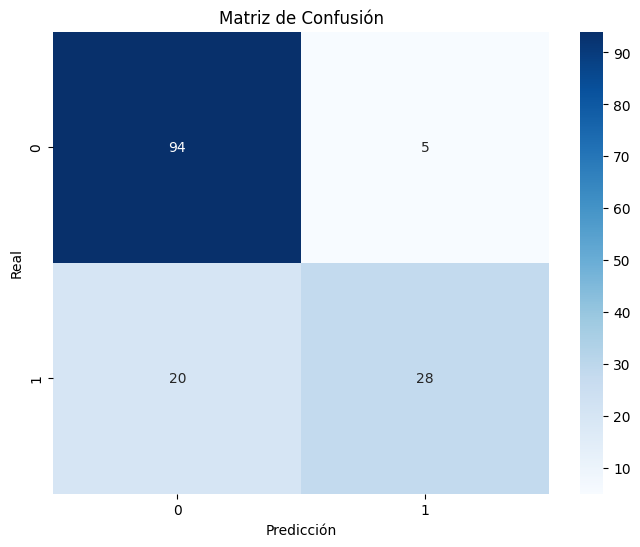

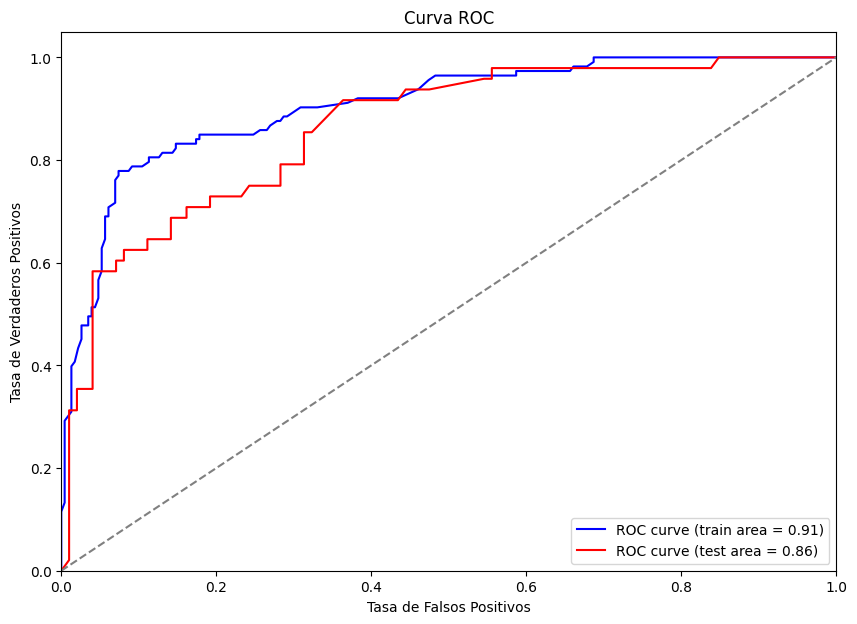

In [ ]:
gb = GradientBoostingClassifier(**best_params_2['GradientBoostingClassifier'], random_state=42)

gb.fit(X_train_scaled_2, y_train_2)

y_pred_2 = gb.predict(X_test_scaled_2)

print('Accuracy: ', accuracy_score(y_test_2, y_pred_2))
print('F1 Score: ', f1_score(y_test_2, y_pred_2, average='weighted'))

matriz_confusion(y_test_2, y_pred_2)

curva_roc(X_train_scaled_2, y_train_2, X_test_scaled_2, y_test_2, gb)



- En esta hipótesis, tenemos un sobreajuste muy acusado, por lo que podemos considerar que no es una hipótesis válida.
- La conclusión que podemos sacar al tratar con esta hipótesis, es que tiene más importancia la proporción de los componentes del tinte, que la cantidad total de los mismos.

## Hipótesis 3: Sensores

En esta hipótesis, utilizaremos la información de que disponemos de temperatura, presión, etc... durante el proceso de producción. No tendré en cuenta los componentes individuales, pero si utilizaré como variable categórica el código de tinte.

In [ ]:
# Creo una copia del dataframe original para esta hipótesis
df_hip_3 = df.copy()

In [ ]:
# Convierto el nombre de todas las columnas a minusculas y sin espacios
df_hip_3.columns = df_hip_3.columns.str.lower().str.replace(' ', '_')

In [ ]:
# Elimino las columnas que no me interesan
# unnamed:_0, guide, _wkucode, estado_instruccion, tbinst, fecha_medicion, untcode1, scrap, final_proceso, mgdvaluemax, observaciones, clvdate_muestra
df_hip_3 = df_hip_3.drop(['guide', '_wkucode', 'estado_instruccion', 'tbinst', 'fecha_medicion', 'untcode1', 'scrap', 'final_proceso', 'mgdvaluemax', 'observaciones', 'clvdate_muestra', 'viscosidad'], axis=1)

In [ ]:
# Convierto el campo de fecha clvdate_medicion que me servirá para la ordenación
df_hip_3["clvdate_medicion"] = pd.to_datetime(df_hip_3["clvdate_medicion"], format="mixed")

In [ ]:
# Renombro las columnas restantes
df_hip_3 = df_hip_3.rename(columns={
    'wohnumber': 'orden',
    'matcode': 'codigo_tinte',
    'wmdname': 'descripcion_tinte',
    'clvdate_medicion': 'fecha_medicion',
    'wmdquantity1': 'cantidad_producto',
    'rpquantityproduced': 'cantidad_producida',
    'nmediciont': 'numero_medicion',
    'nmediciones': 'mediciones_total',
    'mgdvaluemin': 'viscosidad_minima'
})

df_hip_3.columns

Index(['orden', 'codigo_tinte', 'descripcion_tinte', 'temperatura', 'presion',
       'peso', 'velocidad_agitador', 'velocidad_emulsionador', 'vacio',
       'preset_calentar', 'preset_enfriar', 'preset_agua', 'preset_vacio',
       'fecha_medicion', 'cantidad_producto', 'cantidad_producida',
       'numero_medicion', 'mediciones_total', 'viscosidad_minima',
       'viscosidad_final', 'viscosidad_muestras', 'capacidad'],
      dtype='object')

En esta aproximación, voy a tener en cuenta la premisa de que todas los órdenes de producción han sido exitosas, es decir, al final siempre se ha conseguido una medición de viscosidad positiva.

Teniendo en cuenta esta aproximación, elimino las columnas de medición de viscosidad.

In [ ]:
df_hip_3.drop(['descripcion_tinte', 'viscosidad_minima', 'viscosidad_final', 'viscosidad_muestras'], axis=1, inplace=True)

Realizo una ordenación por número de orden y fecha, de forma que para cada orden, todas las mediciones estén correctamente ordenadas

In [ ]:
data_sorted_3 = df_hip_3.sort_values(by=['orden', 'fecha_medicion'], ascending=True)

Me quedo con las mediciones en las que `numero_medicion < mediciones_total`. Los registros que tienen el mismo valor corresponde a la monitorización de los reactores después de obtener la viscosidad en rango.

In [ ]:
data_filtered_3 = data_sorted_3.query("numero_medicion < mediciones_total")

Tal como hemos indicado anteriormente, la última medición es cuando `numero_medicion < mediciones_total = 1`. Por lo tanto, será nuestro indicador para saber que es la medición en el que al final, se ha conseguido la viscosidad correcta.

Considero que el target es 1 si la viscosidad es mala, y 0 si es buena

In [ ]:
data_filtered_3['target'] = data_filtered_3.apply(lambda x: 0 if x['mediciones_total'] - x['numero_medicion'] == 1 else 1, axis=1)

Los valores de `velocidad_agitador` y `velocidad_emulsionador` a veces tiene valores negativos, los convierto a positivos.

In [ ]:
data_filtered_3['velocidad_agitador'].value_counts()

velocidad_agitador
 0.0     61552
-50.0    35151
 50.0    31409
-25.0     6412
-35.0     4925
         ...  
-46.4        1
-6.6         1
-14.5        1
-36.3        1
-16.3        1
Name: count, Length: 566, dtype: int64

In [ ]:
data_filtered_3['velocidad_emulsionador'].value_counts()

velocidad_emulsionador
 0.0     62920
 50.0    45053
-50.0    25149
-35.0     5172
-25.0     3174
         ...  
 28.9        1
-47.0        1
-17.9        1
-39.1        1
-16.9        1
Name: count, Length: 563, dtype: int64

In [ ]:
data_filtered_3['velocidad_agitador'] = data_filtered_3['velocidad_agitador'].abs()
data_filtered_3['velocidad_emulsionador'] = data_filtered_3['velocidad_emulsionador'].abs()

In [ ]:
# Realizo lo mismo para la temperatura
data_filtered_3['temperatura'] = data_filtered_3['temperatura'].abs()

Ahora hacemos la agrupación por número de orden y número de medición, agrupando por los campos que voy a tener en cuenta para el análisis posterior.

No incluyo las columnas de preset ya que van a estar correladas con la monitorización de los sensores.

In [ ]:
data_grouped_3 = data_filtered_3.groupby(['orden', 'numero_medicion']).agg({
   'codigo_tinte': 'last',
   'temperatura': ['last', 'max', 'min', 'mean', 'std', 'count'],
   'presion': ['last', 'max', 'min', 'mean', 'std'],
   # 'peso': ['last', 'max', 'min', 'mean', 'std'], el peso lo quito porque los valores no siguen un mismo formato
   'velocidad_agitador': ['max', 'mean'],
   'velocidad_emulsionador': ['max', 'mean'],
   'cantidad_producto': 'last',
   'capacidad': 'last',
   'target': 'last',
})

Renombro las columnas de las agrupaciones para que sean más entendibles

In [ ]:
data_grouped_3.columns = ['codigo_tinte', 'ultima_temperatura', 'max_temperatura', 'min_temperatura',
                        'media_temperatura', 'std_temperatura', 'minutos_medicion',
                        'ultima_presion', 'max_presion', 'min_presion', 'media_presion', 'std_presion',
                        'velocidad_max_agitador',
                        'velocidad_media_agitador', 'velocidad_max_emulsionador', 'velocidad_media_emulsionador',
                        'cantidad_producto', 'reactor', 'target']

In [ ]:
data_grouped_3.head()

codigo_tinte  ultima_temperatura  max_temperatura  \
orden   numero_medicion                                                      
1032289 0                      621005            41.03009         77.11227   
        1                      621005            36.66088         59.92477   
1032292 0                      628065            33.79630         77.89352   
1032293 0                      628175            32.87037         77.66204   
1032327 0                      629915            60.99538         79.34029   

                         min_temperatura  media_temperatura  std_temperatura  \
orden   numero_medicion                                                        
1032289 0                      34.114580          51.637106        13.450781   
        1                      35.850690          45.883816         7.340516   
1032292 0                      22.685190          46.425379        17.543515   
1032293 0                       9.982639          43.262272        19.333847   
1032327 0                      22.337960          41.905680        18.255082   

                         minutos_medicion  ultima_presion  max_presion  \
orden   numero_medicion                                                  
1032289 0                             185       -0.666522     0.039497   
        1                              94        0.313657     0.323061   
1032292 0                             167       -0.678819     0.074942   
1032293 0                             229        0.325232     0.341146   
1032327 0                             292       -0.318576     0.007668   

                         min_presion  media_presion  std_presion  \
orden   numero_medicion                                            
1032289 0                  -0.702691      -0.550277     0.161382   
        1                  -0.697627      -0.538969     0.278564   
1032292 0                  -0.702691      -0.516839     0.161908   
1032293 0                  -0.755498      -0.298312     0.280098   
1032327 0                  -0.710648      -0.406006     0.223835   

                         velocidad_max_agitador  velocidad_media_agitador  \
orden   numero_medicion                                                     
1032289 0                                  50.0                 34.350811   
        1                                  50.0                 44.958511   
1032292 0                                  50.0                 44.876048   
1032293 0                                  50.0                 32.756332   
1032327 0                                  50.0                 34.287329   

                         velocidad_max_emulsionador  \
orden   numero_medicion                               
1032289 0                                      50.0   
        1                                      50.0   
1032292 0                                      50.0   
1032293 0                                      50.0   
1032327 0                                      50.0   

                         velocidad_media_emulsionador  cantidad_producto  \
orden   numero_medicion                                                    
1032289 0                                   41.630270              904.8   
        1                                   45.212766              904.8   
1032292 0                                   41.017964              452.4   
1032293 0                                   25.279039             2726.0   
1032327 0                                   26.835616             2262.0   

                         reactor  target  
orden   numero_medicion                   
1032289 0                 1000.0       1  
        1                 1000.0       0  
1032292 0                  500.0       0  
1032293 0                 3000.0       0  
1032327 0                 3000.0       1

In [ ]:
# Cambio reactor si tiene valor = 500 -> pequeño, si 1000 -> mediano, si 3000 -> grande

substitucion = {
    3000: 'Grande',
    1000: 'Mediano',
    500: 'Pequeño'
}

data_grouped_3['reactor'] = data_grouped_3['reactor'].replace(substitucion)

In [ ]:
data_final_3 = data_grouped_3.reset_index()

In [ ]:
data_final_3.head()

,orden,numero_medicion,codigo_tinte,ultima_temperatura,max_temperatura,min_temperatura,media_temperatura,std_temperatura,minutos_medicion,ultima_presion,max_presion,min_presion,media_presion,std_presion,velocidad_max_agitador,velocidad_media_agitador,velocidad_max_emulsionador,velocidad_media_emulsionador,cantidad_producto,reactor,target
0,1032289,0,621005,41.03009,77.11227,34.114580,51.637106,13.450781,185,-0.666522,0.039497,-0.702691,-0.550277,0.161382,50.0,34.350811,50.0,41.630270,904.8,Mediano,1
1,1032289,1,621005,36.66088,59.92477,35.850690,45.883816,7.340516,94,0.313657,0.323061,-0.697627,-0.538969,0.278564,50.0,44.958511,50.0,45.212766,904.8,Mediano,0
2,1032292,0,628065,33.79630,77.89352,22.685190,46.425379,17.543515,167,-0.678819,0.074942,-0.702691,-0.516839,0.161908,50.0,44.876048,50.0,41.017964,452.4,Pequeño,0
3,1032293,0,628175,32.87037,77.66204,9.982639,43.262272,19.333847,229,0.325232,0.341146,-0.755498,-0.298312,0.280098,50.0,32.756332,50.0,25.279039,2726.0,Grande,0
4,1032327,0,629915,60.99538,79.34029,22.337960,41.905680,18.255082,292,-0.318576,0.007668,-0.710648,-0.406006,0.223835,50.0,34.287329,50.0,26.835616,2262.0,Grande,1


In [ ]:
# Elimino la columna de orden ya que no la utilizaremos en el análisis
data_final_3.drop('orden', axis=1, inplace=True)

### Análisis exploratorio de los datos

In [ ]:
df_3 = data_final_3.copy()

#### Descripción estadística de los datos

En el dataset disponemos la siguiente información. Cada registro corresponde al resumen de datos registrados de una medición en una orden de producción. Una orden de producción puede tener una o varias mediciones, la primera medición tiene el valor 0.

- `numero_medicion`: Número de la medición, la primera medición empieza en 0
- `codigo_tinte`: El código del tinte producido
- `ultima_temperatura`: La última temperatura registrada
- `max_temperatura`: La temperatura máxima registrada
- `min_temperatura`: La temperatura mínima registrada
- `media_temperatura`: La temperatura media registrada
- `std_temperatura`: La desviación estándar de la temperatura registrada
- `minutos_medicion`: El tiempo total en minutos de la medición
- `ultima_presion`: La última presión registrada
- `max_presion`: La presión máxima registrada
- `min_presion`: La presión mínima registrada
- `media_presion`: La presión media registrada
- `std_presion`: La desviación estándar de la presión registrada
- `velocidad_max_agitador`: La velocidad máxima del agitador
- `velocidad_media_agitador`: La velocidad media del agitador
- `velocidad_max_emulsionador`: La velocidad máxima del emulsionador
- `velocidad_media_emulsionador`: La velocidad media del emulsionador
- `cantidad_producto`: La cantidad del producto
- `reactor`: El tamaño del reactor (e.g., pequeño, mediano, grande)
- `target`: La variable objetivo, indicando el éxito o fracaso en la medida de la viscosidad

In [ ]:
shape = df_3.shape
print(f'El dataset de datos tiene {shape[0]} filas y {shape[1]} columnas.')

El dataset de datos tiene 721 filas y 20 columnas.


In [ ]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   numero_medicion               721 non-null    int64  
 1   codigo_tinte                  721 non-null    int64  
 2   ultima_temperatura            721 non-null    float64
 3   max_temperatura               721 non-null    float64
 4   min_temperatura               721 non-null    float64
 5   media_temperatura             721 non-null    float64
 6   std_temperatura               721 non-null    float64
 7   minutos_medicion              721 non-null    int64  
 8   ultima_presion                721 non-null    float64
 9   max_presion                   721 non-null    float64
 10  min_presion                   721 non-null    float64
 11  media_presion                 721 non-null    float64
 12  std_presion                   721 non-null    float64
 13  veloc

In [ ]:
df_3['codigo_tinte'] = df_3['codigo_tinte'].astype('category')

In [ ]:
df_3.describe()

,numero_medicion,ultima_temperatura,max_temperatura,min_temperatura,media_temperatura,std_temperatura,minutos_medicion,ultima_presion,max_presion,min_presion,media_presion,std_presion,velocidad_max_agitador,velocidad_media_agitador,velocidad_max_emulsionador,velocidad_media_emulsionador,cantidad_producto,target
count,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000
mean,0.545076,34.216238,71.891735,28.126365,44.541012,13.579954,201.407767,-0.122570,0.263716,-0.675173,-0.371866,0.257167,47.362552,32.023378,48.235506,32.872302,871.621956,0.323162
std,1.385834,5.859612,18.191993,4.259792,7.113215,6.046684,328.034035,0.456273,0.176878,0.162602,0.214145,0.090879,9.754034,11.629619,9.087388,11.741474,697.398408,0.468009
min,0.000000,23.611110,23.987270,9.982639,23.987270,0.000000,4.000000,-0.786603,-0.424190,-0.935619,-0.684381,0.000000,0.000000,0.000000,0.000000,0.000000,232.000000,0.000000
25%,0.000000,32.378470,60.706020,24.739580,42.578478,8.960809,116.000000,-0.638310,0.098814,-0.730903,-0.491422,0.209520,50.000000,27.275806,50.000000,29.394915,348.000000,0.000000
50%,0.000000,33.651620,81.365740,28.443290,46.509949,16.248633,160.000000,0.007668,0.333912,-0.699797,-0.431777,0.244878,50.000000,34.615385,50.000000,36.176471,678.600000,0.000000
75%,1.000000,34.635420,83.998840,31.886570,49.074347,18.049098,204.000000,0.324508,0.367188,-0.687500,-0.352131,0.313362,50.000000,40.585714,50.000000,40.819886,1357.200000,1.000000
max,19.000000,69.415510,150.000000,37.123840,59.316486,28.624680,5750.000000,0.584202,1.058015,0.496673,0.585842,0.554662,53.300000,49.207200,55.000000,48.168098,2726.000000,1.000000


1. **`numero_medicion`**: La mayoría de las mediciones parecen ser la primera o única medición, ya que el 75% de los datos son 1 o menos. Sin embargo, el valor máximo es 19, lo que indica que algunas tintes tienen muchas mediciones. Hay mediciones que para una misma orden no siguen una numeración consecutiva, por lo que considedaré en el futuro si es la primera medición o una posterior.

2. **`ultima_temperatura`, `max_temperatura`, `min_temperatura`, `media_temperatura`**: La temperatura varía bastante, con una temperatura máxima de 150 y una mínima de aproximadamente 10. La temperatura media ronda los 45 grados, pero con una desviación estándar de alrededor de 14, lo que indica una variabilidad considerable.

3. **`minutos_medicion`**: La duración de las mediciones varía enormemente, desde solo 4 minutos hasta 5750 minutos. Sin embargo, el 75% de las mediciones duraron 204 minutos o menos, lo que sugiere que hay algunas mediciones extremadamente largas que podrían ser outliers.

4. **`ultima_presion`, `max_presion`, `min_presion`, `media_presion`**: La presión también varía bastante. Mientras que la presión media es negativa (-0.12), la presión máxima llega a 1.06. Esto podría indicar que la presión cambia a lo largo del proceso de producción.


5. **`velocidad_max_agitador`, `velocidad_media_agitador`, `velocidad_max_emulsionador`, `velocidad_media_emulsionador`**: Las velocidades de los agitadores y emulsionadores son en su mayoría altas, con la mayoría de las velocidades máximas alrededor de 50. Sin embargo, la velocidad media es considerablemente menor, lo que indica que las velocidades fluctúan durante el proceso de producción.

6. **`cantidad_producto`**: La cantidad de producto también varía significativamente, desde 232 hasta 2726. Sin embargo, la media es de 871.62, lo que indica que la mayoría de las producciones son de tamaño moderado.

7. **`target`**: La media de esta columna es 0.68, lo que sugiere que alrededor del 68% de las mediciones corresponden a la clase 1. Esto podría indicar un desequilibrio de clases, que tendría que tenerse en cuenta al desarrollar modelos predictivos.

En general, las columnas numéricas muestran una gran variabilidad. Algunas columnas, como `minutos_medicion` podrían contener valores atípicos que podrían afectar a los análisis posteriores.

No hay ninguna columna que tenga valores nulos.

La columna `codigo_tinte` es categórica

In [ ]:
# El número de medición lo modifico, si es la primera medición, pondré un 0, si es la segunda o posterior será un 1
df_3['numero_medicion'] = df_3['numero_medicion'].apply(lambda x: 0 if x == 0 else 1)

In [ ]:
df_3['numero_medicion'].value_counts()

numero_medicion
0    490
1    231
Name: count, dtype: int64

Disponemos de 490 primeras mediciones, tal como habíamos visto en la primera hipótesis, adicionalmente tenemos 231 segundas mediciones.

Mostramos la distribución de los valores en boxplots

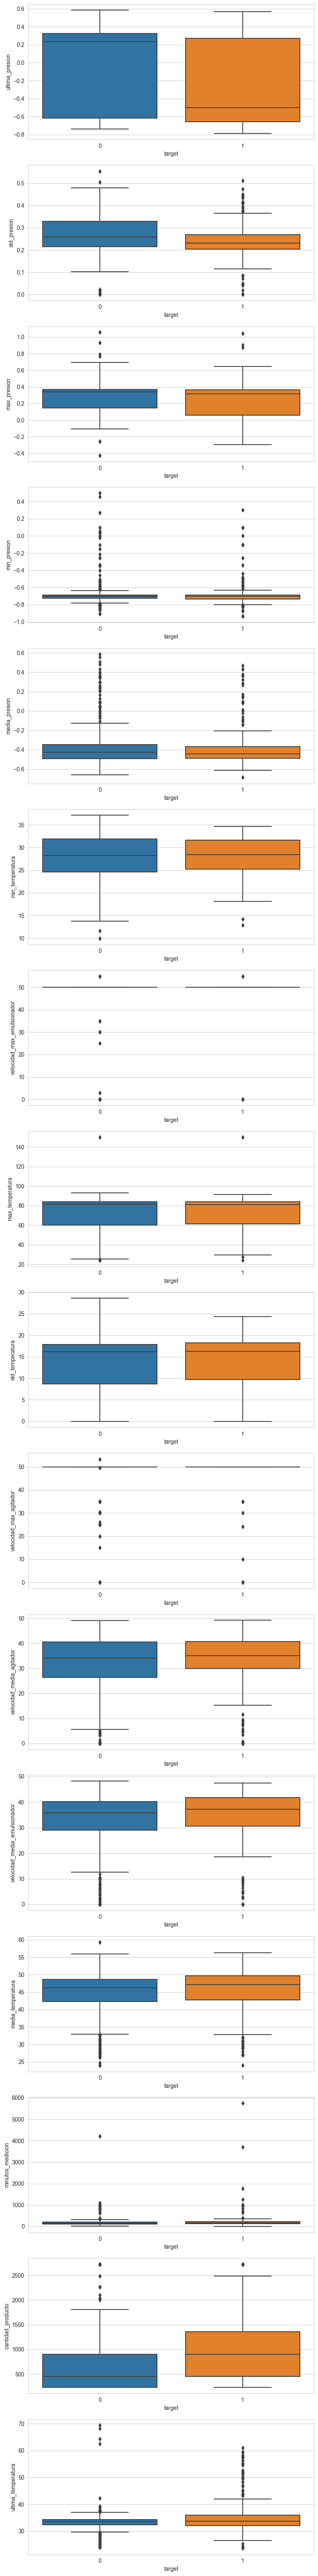

In [ ]:
sns.set_style("whitegrid")

columnas_numericas = ['ultima_presion', 'std_presion', 'max_presion', 'min_presion', 'media_presion',
                     'min_temperatura', 'velocidad_max_emulsionador', 'max_temperatura', 'std_temperatura',
                     'velocidad_max_agitador', 'velocidad_media_agitador',
                     'velocidad_media_emulsionador', 'media_temperatura', 'minutos_medicion',
                     'cantidad_producto', 'ultima_temperatura']

fig, axs = plt.subplots(nrows=len(columnas_numericas), figsize=(8, 4*len(columnas_numericas)))

for i, col in enumerate(columnas_numericas):
    sns.boxplot(x='target', y=col, data=df_3, ax=axs[i])

plt.tight_layout()
plt.show()

De los gráficos de caja se pueden extraer las siguientes observaciones:

- `ultima_presion`, `std_presion`, `max_presion`: Las mediciones con `target` 1 tienden a tener presiones más bajas que las mediciones con `target` 0.
- `min_presion`, `media_presion`: No parece haber una diferencia notable en estas variables entre las mediciones con `target` 0 y `target` 1.
- `min_temperatura`, `velocidad_max_emulsionador`, `max_temperatura`, `std_temperatura`, `velocidad_max_agitador`, `velocidad_media_agitador`, `velocidad_media_emulsionador`, `min_peso`, `media_temperatura`, `minutos_medicion`, `media_peso`, `cantidad_producto`, `ultimo_peso`, `std_peso`, `ultima_temperatura`: Las mediciones con `target` 1 tienden a tener valores más altos que las mediciones con `target` 0 para estas variables.
- `numero_medicion`: No parece haber una diferencia notable en esta variable entre las mediciones con `target` 1 y `target` 0.

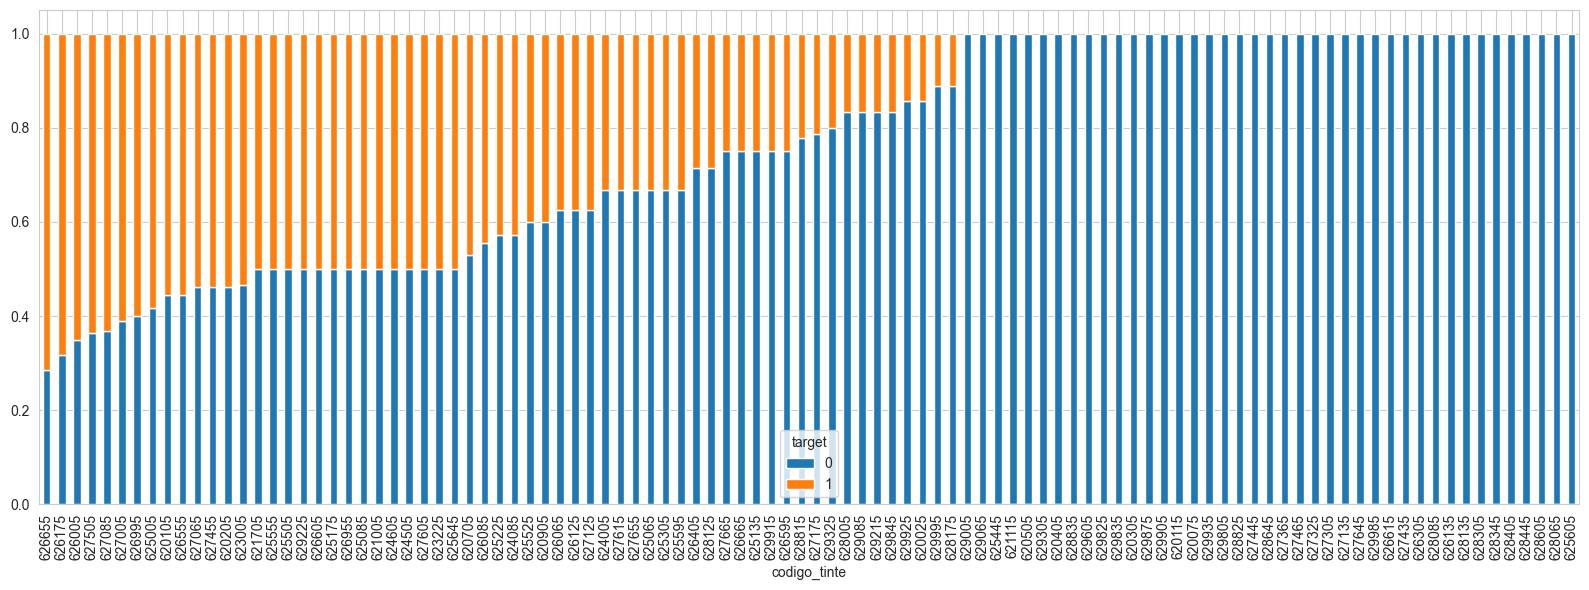

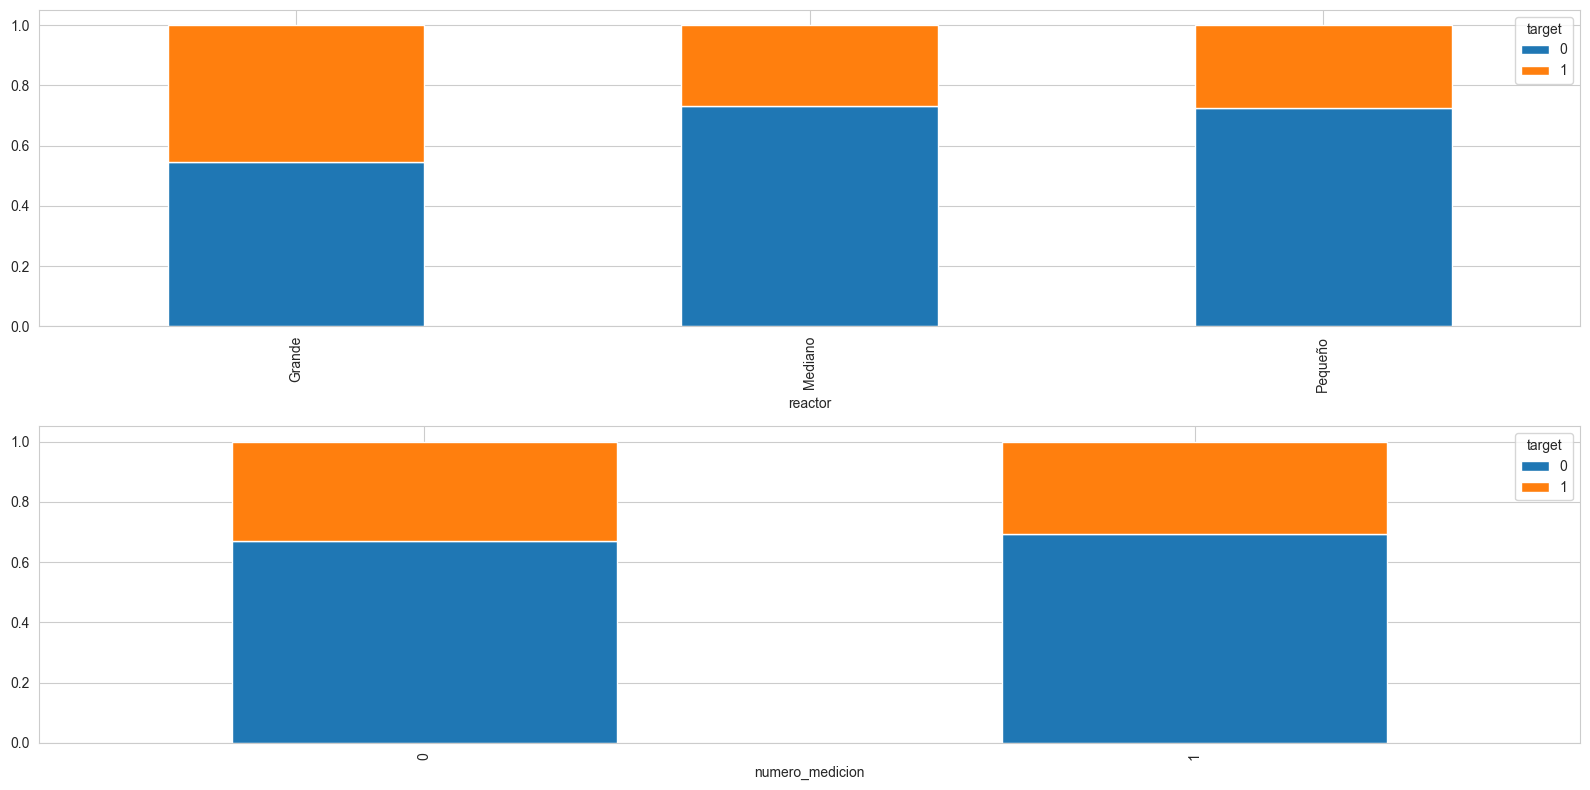

In [ ]:

prop_target0 = df_3[df_3['target'] == 0]['codigo_tinte'].value_counts() / df_3['codigo_tinte'].value_counts()


ordered_categories = prop_target0.sort_values(ascending=True).index


pd.crosstab(df_3['codigo_tinte'], df_3['target']).loc[ordered_categories].apply(lambda r: r/r.sum(), axis=1).plot(kind='bar', stacked=True, figsize=(16,6))

# Display the plot
plt.tight_layout()
plt.show()

columnas_categoricas = ['reactor', 'numero_medicion']


fig, axs = plt.subplots(nrows=len(columnas_categoricas), figsize=(16, 4*len(columnas_categoricas)))

# Create a bar plot for each categorical column
for i, col in enumerate(columnas_categoricas):
    pd.crosstab(df_3[col], df_3['target']).apply(lambda r: r/r.sum(), axis=1).plot(kind='bar', stacked=True, ax=axs[i])

# Display the plot
plt.tight_layout()
plt.show()

- `codigo_tinte`: La distribución de target varía significativamente entre los
diferentes códigos de tinte. Algunos códigos de tinte tienen una proporción mucho mayor de mediciones con target 1, mientras que otros tienen una proporción mayor de mediciones con target 0. Esto sugiere que el código de tinte podría estar relacionado con la variable objetivo.

- `reactor`: La distribución de target también varía entre los diferentes tamaños de reactor. El reactor 'Grande' tiene una proporción más alta de mediciones con target 1, mientras que los reactores 'Mediano' y 'Pequeño' tienen una proporción más alta de mediciones con target 0. Esto sugiere que el tamaño del reactor podría estar relacionado con la variable objetivo.

- `numero_medicion`: Las mediciones posteriores (numero_medicion = 1) tienen una proporción ligeramente mayor de mediciones con target 1 en comparación con las primeras mediciones (numero_medicion = 0). Esto podría sugerir que las mediciones posteriores tienen más probabilidades de tener un resultado de target 1, aunque la diferencia no es muy grande.

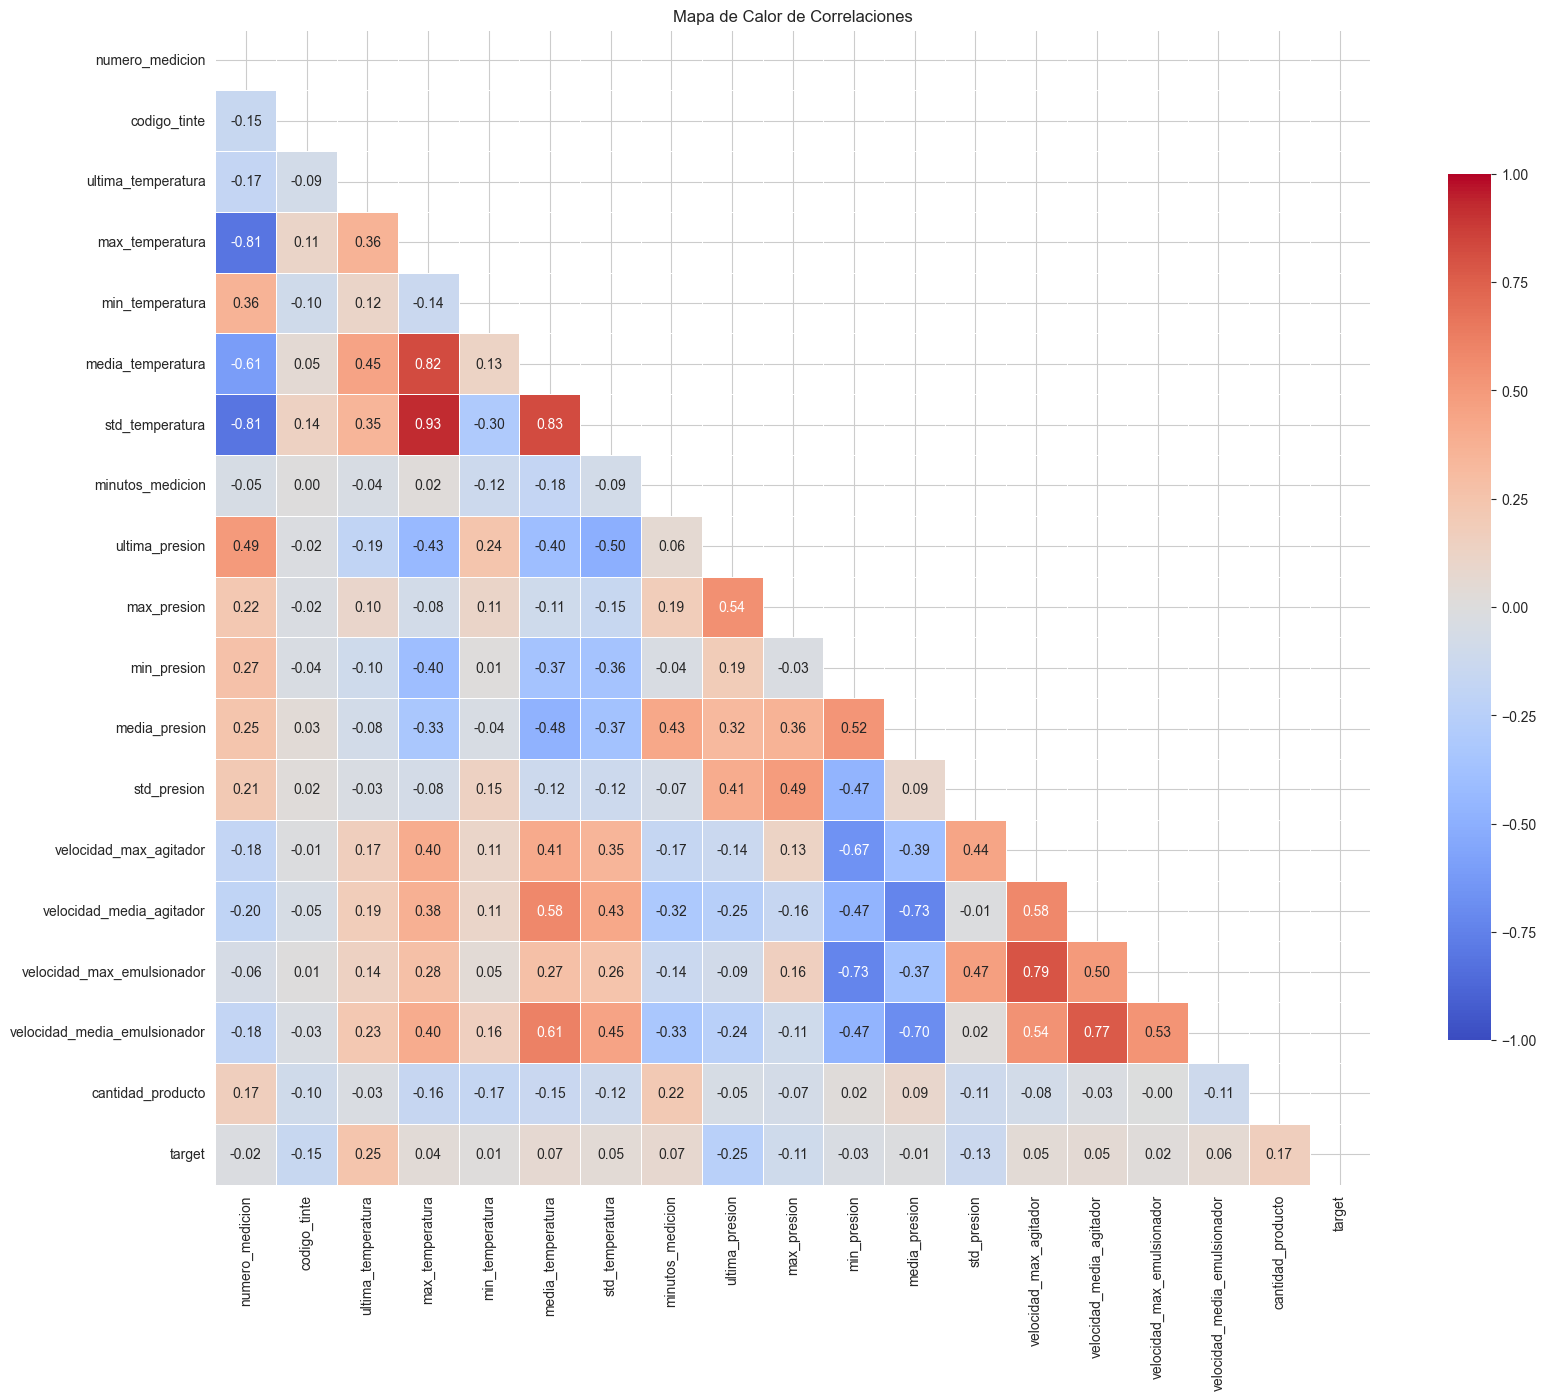

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = df_3.drop('reactor', axis=1).corr()

# Crear una máscara para el triángulo superior
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Configurar el tamaño de la figura
plt.figure(figsize=(20, 15))

# Dibujar el mapa de calor
sns.heatmap(correlation_matrix, mask=mask, cmap="coolwarm", vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f", cbar_kws={"shrink": .75})

# Título del mapa de calor
plt.title("Mapa de Calor de Correlaciones")
plt.show()

- Hay algunas variables que están altamente correlacionadas entre sí, como `max_temperatura`, `min_temperatura`, `media_temperatura`, entre otras. Estas correlaciones altas pueden llevar a multicolinealidad si decidimos usar modelos lineales, por lo que deberíamos tenerlo en cuenta.

In [ ]:
df_3.head()

,numero_medicion,codigo_tinte,ultima_temperatura,max_temperatura,min_temperatura,media_temperatura,std_temperatura,minutos_medicion,ultima_presion,max_presion,min_presion,media_presion,std_presion,velocidad_max_agitador,velocidad_media_agitador,velocidad_max_emulsionador,velocidad_media_emulsionador,cantidad_producto,reactor,target
0,0,621005,41.03009,77.11227,34.114580,51.637106,13.450781,185,-0.666522,0.039497,-0.702691,-0.550277,0.161382,50.0,34.350811,50.0,41.630270,904.8,Mediano,1
1,1,621005,36.66088,59.92477,35.850690,45.883816,7.340516,94,0.313657,0.323061,-0.697627,-0.538969,0.278564,50.0,44.958511,50.0,45.212766,904.8,Mediano,0
2,0,628065,33.79630,77.89352,22.685190,46.425379,17.543515,167,-0.678819,0.074942,-0.702691,-0.516839,0.161908,50.0,44.876048,50.0,41.017964,452.4,Pequeño,0
3,0,628175,32.87037,77.66204,9.982639,43.262272,19.333847,229,0.325232,0.341146,-0.755498,-0.298312,0.280098,50.0,32.756332,50.0,25.279039,2726.0,Grande,0
4,0,629915,60.99538,79.34029,22.337960,41.905680,18.255082,292,-0.318576,0.007668,-0.710648,-0.406006,0.223835,50.0,34.287329,50.0,26.835616,2262.0,Grande,1


#### Test de varios modelos

Voy a dividir el dataset de datos en dos partes, una que tendrá todas las observaciones y la otra que solo tendrá las primeras observaciones.

In [ ]:
df_3B = df_3[df_3['numero_medicion'] == 0]

df_3B.drop(['numero_medicion'], axis=1, inplace=True)

In [ ]:
print(len(df_3))
print(len(df_3B))

721
490


Vamos a probar diferentes modelos de clasificación, previamente vamos a aplicar one hot encoding a las columnas categóricas.

In [ ]:
data_one_hot_3 = pd.get_dummies(df_3, columns=['codigo_tinte', 'reactor'])
data_one_hot_3B = pd.get_dummies(df_3B, columns=['codigo_tinte', 'reactor'])


Realizamos la división de los conjuntos de entrenamiento y test

In [ ]:
# Definir las variables independientes (X) y la variable dependiente (y)
X_3 = data_one_hot_3.drop("target", axis=1)
y_3 = data_one_hot_3["target"]

# Dividir el dataset en conjuntos de entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.3, random_state=42, stratify=y_3)

X_train_3.shape, X_test_3.shape

((504, 122), (217, 122))

In [ ]:
# Definir las variables independientes (X) y la variable dependiente (y)
X_3B = data_one_hot_3B.drop("target", axis=1)
y_3B = data_one_hot_3B["target"]

# Dividir el dataset en conjuntos de entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train_3B, X_test_3B, y_train_3B, y_test_3B = train_test_split(X_3B, y_3B, test_size=0.3, random_state=42, stratify=y_3B)

X_train_3B.shape, X_test_3B.shape

((343, 121), (147, 121))

Realizamos un escalado de las variables:

In [ ]:
# Estandarizamos las columnas numéricas
scaler_3 = StandardScaler()
X_train_scaled_3 = scaler.fit_transform(X_train_3)
X_test_scaled_3 = scaler.transform(X_test_3)

scaler_3B = StandardScaler()
X_train_scaled_3B = scaler.fit_transform(X_train_3B)
X_test_scaled_3B = scaler.transform(X_test_3B)

Aplicamos todos los modelos para tener una primera aproximación de resultados:

In [ ]:
resultado_3 = test_inicial_modelos(X_train_scaled_3, y_train_3, X_test_scaled_3, y_test_3)
resultado_3

,Classifier,Accuracy,Recall,F1 Score,Confusion Matrix
3,RandomForestClassifier,0.788018,0.442857,0.574074,"[[140, 7], [39, 31]]"
0,LogisticRegression,0.764977,0.614286,0.627737,"[[123, 24], [27, 43]]"
1,SVC,0.741935,0.442857,0.525424,"[[130, 17], [39, 31]]"
4,GradientBoostingClassifier,0.741935,0.514286,0.562500,"[[125, 22], [34, 36]]"
2,DecisionTreeClassifier,0.737327,0.628571,0.606897,"[[116, 31], [26, 44]]"
6,XGBClassifier,0.728111,0.457143,0.520325,"[[126, 21], [38, 32]]"
5,KNeighborsClassifier,0.608295,0.571429,0.484848,"[[92, 55], [30, 40]]"


In [ ]:
resultado_3B = test_inicial_modelos(X_train_scaled_3B, y_train_3B, X_test_scaled_3B, y_test_3B)
resultado_3B

,Classifier,Accuracy,Recall,F1 Score,Confusion Matrix
0,LogisticRegression,0.863946,0.795918,0.795918,"[[88, 10], [10, 39]]"
4,GradientBoostingClassifier,0.829932,0.551020,0.683544,"[[95, 3], [22, 27]]"
3,RandomForestClassifier,0.795918,0.408163,0.571429,"[[97, 1], [29, 20]]"
1,SVC,0.789116,0.551020,0.635294,"[[89, 9], [22, 27]]"
5,KNeighborsClassifier,0.761905,0.387755,0.520548,"[[93, 5], [30, 19]]"
6,XGBClassifier,0.761905,0.448980,0.556962,"[[90, 8], [27, 22]]"
2,DecisionTreeClassifier,0.714286,0.530612,0.553191,"[[79, 19], [23, 26]]"


Donde tenemos mejor resultado es con regresíon logística utilizando solo las primeras mediciones.

#### Búsqueda de mejores parámetros en los modelos.

In [ ]:
best_params_3, best_scores_3 = busqueda_mejores_parametros(X_train_scaled_3, y_train_3)
best_params_3B, best_scores_3B = busqueda_mejores_parametros(X_train_scaled_3B, y_train_3B)

Performing grid search for LogisticRegression...


Performing grid search for SVC...
Performing grid search for DecisionTreeClassifier...
Performing grid search for RandomForestClassifier...
Performing grid search for GradientBoostingClassifier...
Performing grid search for KNeighborsClassifier...
Performing grid search for XGBClassifier...
busqueda_mejores_parametros tardó 203.0097873210907 segundos en ejecutarse.
Performing grid search for LogisticRegression...
Performing grid search for SVC...
Performing grid search for DecisionTreeClassifier...
Performing grid search for RandomForestClassifier...
Performing grid search for GradientBoostingClassifier...
Performing grid search for KNeighborsClassifier...
Performing grid search for XGBClassifier...
busqueda_mejores_parametros tardó 130.67821264266968 segundos en ejecutarse.


In [ ]:
results_params_3 = test_modelos_params(X_train_scaled_3, y_train_3, X_test_scaled_3, y_test_3, best_params_3)
results_params_3

,Classifier,Accuracy,F1 Score,Recall,Confusion Matrix
3,RandomForestClassifier,0.774194,0.566372,0.457143,"[[136, 11], [38, 32]]"
0,LogisticRegression,0.760369,0.611940,0.585714,"[[124, 23], [29, 41]]"
1,SVC,0.760369,0.623188,0.614286,"[[122, 25], [27, 43]]"
6,XGBClassifier,0.737327,0.558140,0.514286,"[[124, 23], [34, 36]]"
4,GradientBoostingClassifier,0.728111,0.495726,0.414286,"[[129, 18], [41, 29]]"
5,KNeighborsClassifier,0.723502,0.454545,0.357143,"[[132, 15], [45, 25]]"
2,DecisionTreeClassifier,0.718894,0.573427,0.585714,"[[115, 32], [29, 41]]"


In [ ]:
results_params_3B = test_modelos_params(X_train_scaled_3B, y_train_3B, X_test_scaled_3B, y_test_3B, best_params_3B)
results_params_3B

,Classifier,Accuracy,F1 Score,Recall,Confusion Matrix
0,LogisticRegression,0.850340,0.717949,0.571429,"[[97, 1], [21, 28]]"
1,SVC,0.843537,0.747253,0.693878,"[[90, 8], [15, 34]]"
5,KNeighborsClassifier,0.802721,0.666667,0.591837,"[[89, 9], [20, 29]]"
3,RandomForestClassifier,0.755102,0.470588,0.326531,"[[95, 3], [33, 16]]"
4,GradientBoostingClassifier,0.755102,0.513514,0.387755,"[[92, 6], [30, 19]]"
6,XGBClassifier,0.755102,0.500000,0.367347,"[[93, 5], [31, 18]]"
2,DecisionTreeClassifier,0.727891,0.583333,0.571429,"[[79, 19], [21, 28]]"


La regresión logística sin parámetros es el que mejor resultado obtenemos.

Como hemos podido comprobar, el modelo de regresión logística, con los parámetros por defecto, es el que mejor resultado nos da en esta hipótesis.

Vamos a ver los resultados con más detalle para este caso.

In [ ]:
lr = LogisticRegression()

lr.fit(X_train_scaled_3B, y_train_3B)

y_pred_3B = lr.predict(X_test_scaled_3B)

print('Accuracy: ', accuracy_score(y_test_3B, y_pred_3B))
print('F1 Score: ', f1_score(y_test_3B, y_pred_3B, average='weighted'))

Accuracy:  0.8639455782312925
F1 Score:  0.8639455782312925


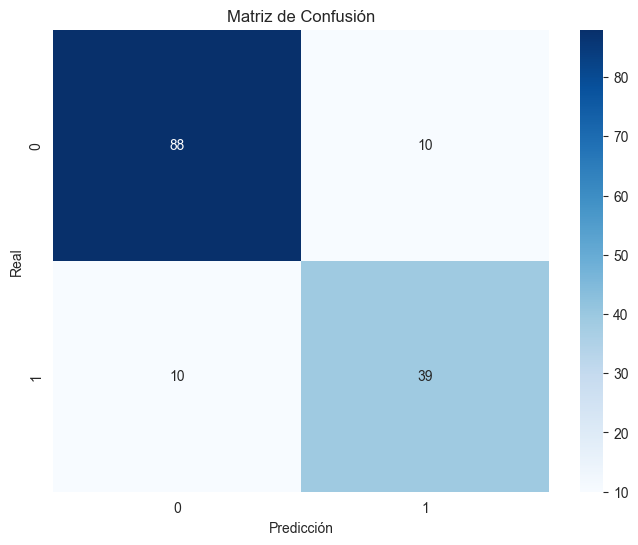

In [ ]:
# Mostramos la matriz de confusión
matriz_confusion(y_test_3B, y_pred_3B)

Curiosamente, vemos que los resultados del Accuracy son iguales a los que obtenemos en la hipótesis 1, pero en este caso, tenemos una sensibilidad mucho mayor, lo que nos indica que tenemos menos falsos negativos.

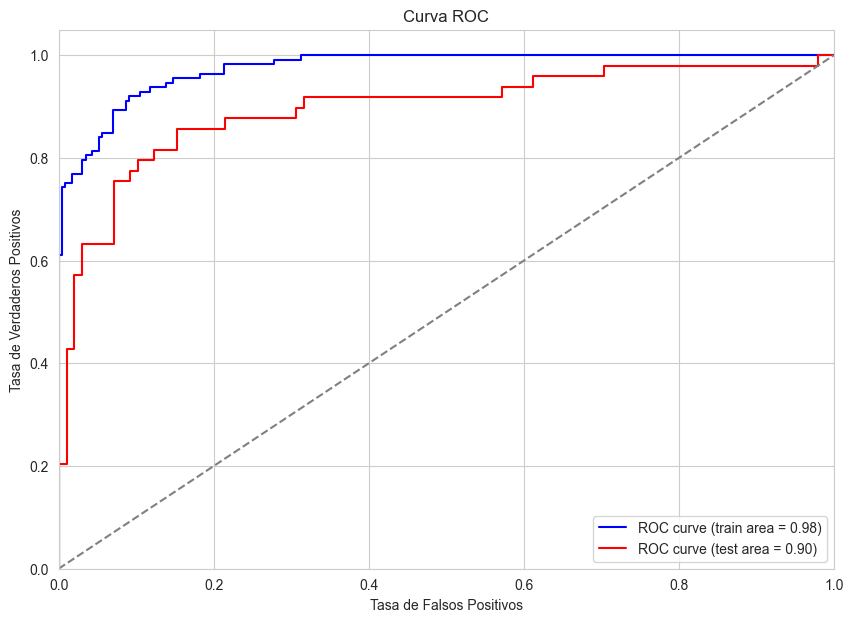

In [ ]:
# Dibujamos la curva ROC
curva_roc(X_train_scaled_3B, y_train_3B, X_test_scaled_3B, y_test_3B, lr)

En este caso, podemos ver que hay un sobreajuste en el modelo, ya que el resultado en el conjunto de entrenamiento es mucho mejor que en el conjunto de test. Por lo que no lo podemos dar por bueno.

Como los resultados anteriores son bastante peores que en la hipótesis 1, podemos descartar esta hipótesis, en base a los resultados obtenidos, por lo que hemos de focalizar los esfuerzos en buscar otra aproximación.

Vamos a comprobar con los mejores parámetros:

Accuracy:  0.7741935483870968
F1 Score:  0.7567132044362508


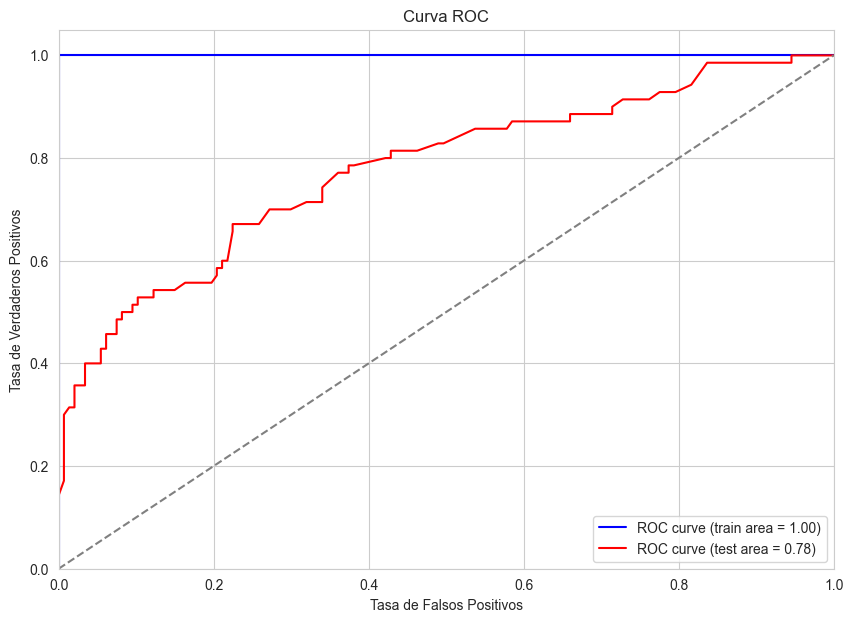

In [ ]:
rf = RandomForestClassifier(**best_params_3['RandomForestClassifier'], random_state=42)

rf.fit(X_train_scaled_3, y_train_3)

y_pred_3 = rf.predict(X_test_scaled_3)

print('Accuracy: ', accuracy_score(y_test_3, y_pred_3))
print('F1 Score: ', f1_score(y_test_3, y_pred_3, average='weighted'))

curva_roc(X_train_scaled_3, y_train_3, X_test_scaled_3, y_test_3, rf)

- Utilizando Random Forest, vemos un caso extremo de sobreajuste, ya que para el conjunto de training el resultado es perfecto, mientras que en el de test, es resultado es mucho menor, por lo que no podemos dar por buena esta hipótesis.

Accuracy:  0.8503401360544217
F1 Score:  0.8380816714150047


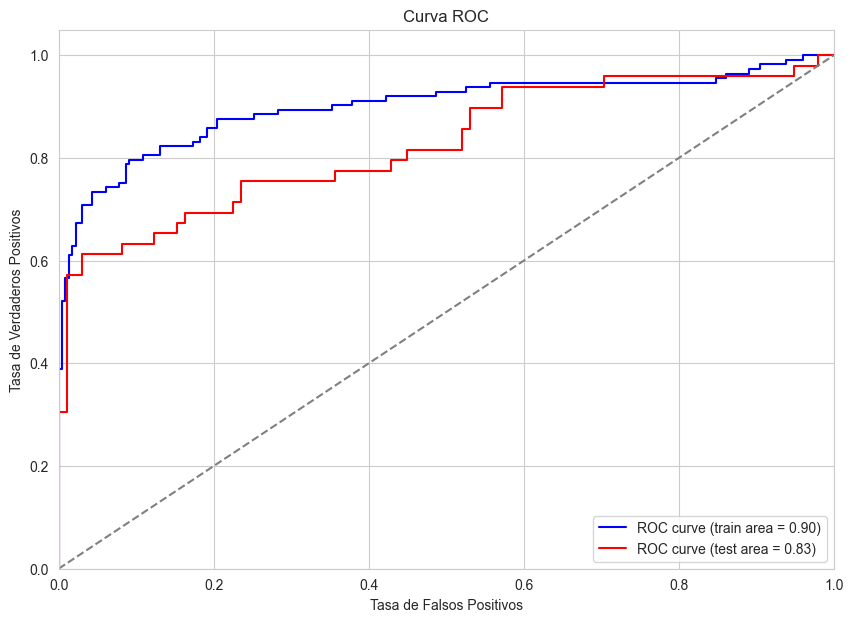

In [ ]:
lr = LogisticRegression(**best_params_3B['LogisticRegression'], random_state=42)

lr.fit(X_train_scaled_3B, y_train_3B)

y_pred_3B = lr.predict(X_test_scaled_3B)

print('Accuracy: ', accuracy_score(y_test_3B, y_pred_3B))
print('F1 Score: ', f1_score(y_test_3B, y_pred_3B, average='weighted'))

curva_roc(X_train_scaled_3B, y_train_3B, X_test_scaled_3B, y_test_3B, lr)

- En el caso de la regresión logística con la búsqueda de parámetros, vemos que seguimos teniendo sobreajuste, por lo que tampoco podemos dar por bueno el resultado.

## Hipótesis 4: Sensores y relación de proporción de componentes

Como hemos visto que los mejores resultados los obtenemos utilizando proporción de componentes + primera medición, vamos a añadir a esta hipótesis los datos de sensores para ver si mejoramos el resultado.

In [ ]:
df_4 = df_3B.copy()

In [ ]:
# Convertimos la columna codigo_tinte a object para poder enlazar con los componentes
df_4['codigo_tinte'] = df_4['codigo_tinte'].astype(str)

# Cruzamos con la tabla de componentes
df_hip_4 = pd.merge(df_4, df_componentes, left_on='codigo_tinte', right_on='material', how='left')

In [ ]:
df_hip_4.head()

,codigo_tinte,ultima_temperatura,max_temperatura,min_temperatura,media_temperatura,std_temperatura,minutos_medicion,ultima_presion,max_presion,min_presion,media_presion,std_presion,velocidad_max_agitador,velocidad_media_agitador,velocidad_max_emulsionador,velocidad_media_emulsionador,cantidad_producto,reactor,target,material,*z6*dabeersen-503_/_dissolvine_d-40,*z6_colorante_ptd,*z6_vibracolor_citrus_yellow,acido_ascorbico,agua_desionizada,amoniaco_25%,aq-save,arginine,arianor_cherry_red/vibracolor_ruby_red,astrophos_hc2,azul_ultramar_b_6554,cera_de_abejas-beewax,chematek-code-00302-jacorol_ahp,cire_de_lanol/sinnowax_ao,colorante_2a3hp,genencare_osms_ba/betafin_bp,h.c._yellow_2,h.c._yellow_4,jarocol_mbb,lowacryl_orange-31,merquat_280/_safiquat-22,monoetanolamina_99_%_purete,nafol_16-18/lanette_o,natrlquest_e_30,perfume_bamboo_lotus_flower_2048692,perfume_cosmetic_6044p,perfume_xanadu,propilenglicol,rodol_24dape/chematek_00326,rodol_2_mr/chematek_code_00102,rodol_6amc/chematek_00269,rodol_6cp/chematek-00235,rodol_9r,rodol_blfx/-bondecolor_blfx,rodol_eg_/jarocol_map,rodol_ern_/colorex_1_nap,rodol_gray_hed_/_jarocol_bhp,rodol_p_base_(ot),rodol_paoc/chematek-00216,rodol_paox/colorex_paox,rodol_pmp/jarocol_pmp,rodol_rs_/jarocol_rl,rodol_xdat,silkrom_wa_40,sodio_sulfito_anhidro,structure_zea_starch,transcutol_cg,utmf_ceramide_iii_silicon_free,vaselina_filante_nz41-em
0,621005,41.03009,77.11227,34.114580,51.637106,13.450781,185,-0.666522,0.039497,-0.702691,-0.550277,0.161382,50.0,34.350811,50.0,41.630270,904.8,Mediano,1,621005,0.0,0.0,0.0,4.0,501.535,64.965,1,2,0.0,30,0.00,0,0.0,180,0,0,0.0,0.0,13.2,0.0,25,0,20,3,8,0.0,0.0,0,4.2,0.0,0.0,0.0,0.0,25.20,0.90,1.5,9.50,0.00,0.00,0.0,2.5,3.50,0,10,10.0,30,50,0.0,0
1,628065,33.79630,77.89352,22.685190,46.425379,17.543515,167,-0.678819,0.074942,-0.702691,-0.516839,0.161908,50.0,44.876048,50.0,41.017964,452.4,Pequeño,0,628065,0.0,0.0,0.0,2.0,613.188,71.862,1,2,0.0,30,0.00,0,0.0,150,0,0,0.0,0.0,0.0,0.0,25,0,20,3,8,0.0,0.0,0,0.2,3.8,0.0,0.0,0.0,4.20,0.25,0.0,0.00,1.50,0.00,0.0,1.0,0.00,0,10,8.0,30,15,0.0,0
2,628175,32.87037,77.66204,9.982639,43.262272,19.333847,229,0.325232,0.341146,-0.755498,-0.298312,0.280098,50.0,32.756332,50.0,25.279039,2726.0,Grande,0,628175,0.0,0.0,0.0,4.0,613.258,71.862,1,2,0.0,30,0.00,0,0.0,150,0,0,0.0,0.0,0.0,0.0,25,0,20,3,8,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.95,0.58,0.0,4.25,0.64,0.00,0.0,0.0,4.46,0,10,5.0,30,15,0.0,0
3,629915,60.99538,79.34029,22.337960,41.905680,18.255082,292,-0.318576,0.007668,-0.710648,-0.406006,0.223835,50.0,34.287329,50.0,26.835616,2262.0,Grande,1,629915,0.0,0.0,0.0,3.0,528.232,100.448,1,2,0.0,0,0.60,0,0.0,160,0,40,0.0,0.0,0.0,0.0,25,40,20,3,0,0.0,12.5,0,0.0,0.0,0.0,0.0,0.0,0.48,0.20,0.0,1.60,0.24,0.00,0.0,0.0,1.70,0,10,4.0,30,15,1.0,0
4,629925,34.08565,81.01852,26.851850,50.329801,15.793862,191,-0.652054,0.039497,-0.725116,-0.506174,0.193704,50.0,41.108377,50.0,48.167539,452.4,Mediano,0,629925,0.0,0.0,0.0,1.5,535.082,100.448,1,2,0.0,0,0.35,0,0.0,160,0,40,0.0,0.0,0.0,0.0,25,40,20,3,0,0.0,12.5,0,0.0,0.0,0.0,0.0,0.0,0.00,0.10,0.0,0.21,0.00,0.21,0.0,0.0,0.10,0,10,2.5,30,15,1.0,0


In [ ]:
df_hip_4.drop(['codigo_tinte'], inplace=True, axis=1)
df_hip_4.head()

,ultima_temperatura,max_temperatura,min_temperatura,media_temperatura,std_temperatura,minutos_medicion,ultima_presion,max_presion,min_presion,media_presion,std_presion,velocidad_max_agitador,velocidad_media_agitador,velocidad_max_emulsionador,velocidad_media_emulsionador,cantidad_producto,reactor,target,material,*z6*dabeersen-503_/_dissolvine_d-40,*z6_colorante_ptd,*z6_vibracolor_citrus_yellow,acido_ascorbico,agua_desionizada,amoniaco_25%,aq-save,arginine,arianor_cherry_red/vibracolor_ruby_red,astrophos_hc2,azul_ultramar_b_6554,cera_de_abejas-beewax,chematek-code-00302-jacorol_ahp,cire_de_lanol/sinnowax_ao,colorante_2a3hp,genencare_osms_ba/betafin_bp,h.c._yellow_2,h.c._yellow_4,jarocol_mbb,lowacryl_orange-31,merquat_280/_safiquat-22,monoetanolamina_99_%_purete,nafol_16-18/lanette_o,natrlquest_e_30,perfume_bamboo_lotus_flower_2048692,perfume_cosmetic_6044p,perfume_xanadu,propilenglicol,rodol_24dape/chematek_00326,rodol_2_mr/chematek_code_00102,rodol_6amc/chematek_00269,rodol_6cp/chematek-00235,rodol_9r,rodol_blfx/-bondecolor_blfx,rodol_eg_/jarocol_map,rodol_ern_/colorex_1_nap,rodol_gray_hed_/_jarocol_bhp,rodol_p_base_(ot),rodol_paoc/chematek-00216,rodol_paox/colorex_paox,rodol_pmp/jarocol_pmp,rodol_rs_/jarocol_rl,rodol_xdat,silkrom_wa_40,sodio_sulfito_anhidro,structure_zea_starch,transcutol_cg,utmf_ceramide_iii_silicon_free,vaselina_filante_nz41-em
0,41.03009,77.11227,34.114580,51.637106,13.450781,185,-0.666522,0.039497,-0.702691,-0.550277,0.161382,50.0,34.350811,50.0,41.630270,904.8,Mediano,1,621005,0.0,0.0,0.0,4.0,501.535,64.965,1,2,0.0,30,0.00,0,0.0,180,0,0,0.0,0.0,13.2,0.0,25,0,20,3,8,0.0,0.0,0,4.2,0.0,0.0,0.0,0.0,25.20,0.90,1.5,9.50,0.00,0.00,0.0,2.5,3.50,0,10,10.0,30,50,0.0,0
1,33.79630,77.89352,22.685190,46.425379,17.543515,167,-0.678819,0.074942,-0.702691,-0.516839,0.161908,50.0,44.876048,50.0,41.017964,452.4,Pequeño,0,628065,0.0,0.0,0.0,2.0,613.188,71.862,1,2,0.0,30,0.00,0,0.0,150,0,0,0.0,0.0,0.0,0.0,25,0,20,3,8,0.0,0.0,0,0.2,3.8,0.0,0.0,0.0,4.20,0.25,0.0,0.00,1.50,0.00,0.0,1.0,0.00,0,10,8.0,30,15,0.0,0
2,32.87037,77.66204,9.982639,43.262272,19.333847,229,0.325232,0.341146,-0.755498,-0.298312,0.280098,50.0,32.756332,50.0,25.279039,2726.0,Grande,0,628175,0.0,0.0,0.0,4.0,613.258,71.862,1,2,0.0,30,0.00,0,0.0,150,0,0,0.0,0.0,0.0,0.0,25,0,20,3,8,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.95,0.58,0.0,4.25,0.64,0.00,0.0,0.0,4.46,0,10,5.0,30,15,0.0,0
3,60.99538,79.34029,22.337960,41.905680,18.255082,292,-0.318576,0.007668,-0.710648,-0.406006,0.223835,50.0,34.287329,50.0,26.835616,2262.0,Grande,1,629915,0.0,0.0,0.0,3.0,528.232,100.448,1,2,0.0,0,0.60,0,0.0,160,0,40,0.0,0.0,0.0,0.0,25,40,20,3,0,0.0,12.5,0,0.0,0.0,0.0,0.0,0.0,0.48,0.20,0.0,1.60,0.24,0.00,0.0,0.0,1.70,0,10,4.0,30,15,1.0,0
4,34.08565,81.01852,26.851850,50.329801,15.793862,191,-0.652054,0.039497,-0.725116,-0.506174,0.193704,50.0,41.108377,50.0,48.167539,452.4,Mediano,0,629925,0.0,0.0,0.0,1.5,535.082,100.448,1,2,0.0,0,0.35,0,0.0,160,0,40,0.0,0.0,0.0,0.0,25,40,20,3,0,0.0,12.5,0,0.0,0.0,0.0,0.0,0.0,0.00,0.10,0.0,0.21,0.00,0.21,0.0,0.0,0.10,0,10,2.5,30,15,1.0,0


In [ ]:
data_one_hot_4 = pd.get_dummies(df_3B, columns=['reactor'])

In [ ]:
# Definir las variables independientes (X) y la variable dependiente (y)
X_4 = data_one_hot_4.drop("target", axis=1)
y_4 = data_one_hot_4["target"]

# Dividir el dataset en conjuntos de entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, test_size=0.3, random_state=42, stratify=y_4)

X_train_4.shape, X_test_4.shape


# Estandarizamos las columnas numéricas
scaler_4 = StandardScaler()
X_train_scaled_4 = scaler.fit_transform(X_train_4)
X_test_scaled_4 = scaler.transform(X_test_4)

In [ ]:
resultado_4 = test_inicial_modelos(X_train_scaled_4, y_train_4, X_test_scaled_4, y_test_4)

In [ ]:
resultado_4

,Classifier,Accuracy,Recall,F1 Score,Confusion Matrix
3,RandomForestClassifier,0.829932,0.591837,0.698795,"[[93, 5], [20, 29]]"
6,XGBClassifier,0.829932,0.673469,0.725275,"[[89, 9], [16, 33]]"
4,GradientBoostingClassifier,0.823129,0.673469,0.717391,"[[88, 10], [16, 33]]"
1,SVC,0.816327,0.530612,0.658228,"[[94, 4], [23, 26]]"
5,KNeighborsClassifier,0.809524,0.571429,0.666667,"[[91, 7], [21, 28]]"
0,LogisticRegression,0.782313,0.530612,0.619048,"[[89, 9], [23, 26]]"
2,DecisionTreeClassifier,0.741497,0.612245,0.612245,"[[79, 19], [19, 30]]"


In [ ]:
best_params_4, best_scores_4 = busqueda_mejores_parametros(X_train_scaled_4, y_train_4)

Performing grid search for LogisticRegression...


Performing grid search for SVC...
Performing grid search for DecisionTreeClassifier...
Performing grid search for RandomForestClassifier...
Performing grid search for GradientBoostingClassifier...
Performing grid search for KNeighborsClassifier...
Performing grid search for XGBClassifier...
busqueda_mejores_parametros tardó 131.77040934562683 segundos en ejecutarse.


In [ ]:
results_params_4 = test_modelos_params(X_train_scaled_4, y_train_4, X_test_scaled_4, y_test_4, best_params_4)
results_params_4

,Classifier,Accuracy,F1 Score,Recall,Confusion Matrix
3,RandomForestClassifier,0.829932,0.698795,0.591837,"[[93, 5], [20, 29]]"
4,GradientBoostingClassifier,0.829932,0.719101,0.653061,"[[90, 8], [17, 32]]"
1,SVC,0.823129,0.682927,0.571429,"[[93, 5], [21, 28]]"
2,DecisionTreeClassifier,0.816327,0.721649,0.714286,"[[85, 13], [14, 35]]"
5,KNeighborsClassifier,0.795918,0.642857,0.551020,"[[90, 8], [22, 27]]"
6,XGBClassifier,0.789116,0.673684,0.653061,"[[84, 14], [17, 32]]"
0,LogisticRegression,0.775510,0.602410,0.510204,"[[89, 9], [24, 25]]"


Accuracy:  0.8299319727891157
F1 Score:  0.8206094520261139


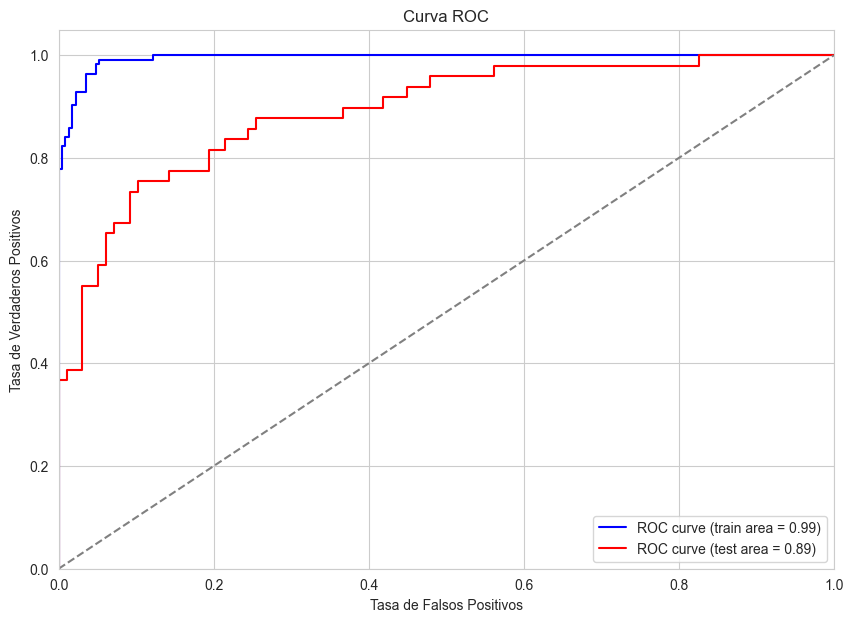

In [ ]:
# Vamos a comprobar los resultados con RandomForest
rf = RandomForestClassifier(**best_params_4['RandomForestClassifier'], random_state=42)

rf.fit(X_train_scaled_4, y_train_4)

y_pred_4 = rf.predict(X_test_scaled_4)

print('Accuracy: ', accuracy_score(y_test_4, y_pred_4))
print('F1 Score: ', f1_score(y_test_4, y_pred_4, average='weighted'))

curva_roc(X_train_scaled_4, y_train_4, X_test_scaled_4, y_test_4, rf)

Podemos observar que también tenemos un sobreajuste en este caso, por lo que no podemos dar por bueno este modelo.

## Conclusiones

- La hipótesis que mejor resultado ha obtenido es la primera, donde tenemos en cuenta la proporción de componentes para el tinte que se va a producir, el reactor donde se va a producir, y la cantidad total de producto.
- La adición del campo calculado de `grado de llenado`, mejora de forma significativa la predicción.
- La diferencia de resultado entre la hipótesis con proporción de componentes y la cantidad total de compomentes nos indica que el factor más importante es la relación de componentes y no cuanta cantidad total de cada producto.
- Las hipótesis en las que utilizamos los sensores son significativamente peores que las hipótesis en que no las utilizamos, vemos que provocan un sobreajuste en los modelos.
- Hemos comprobado que solo podemos trabajar con las primeras mediciones, que son las que siguen una misma guía de proceso que es inalterado, el proceso anterior de producción anterior a segundas mediciones no sigue una guía, si no que se trata más bien de la maestría del técnico según su experiencia y como ve la consistencia del tinte en el momento de la medición.
- Una de las razones por las que los datos de los sensores dan peor resultado, es que entre que se extrae el producto para medir la viscosidad, y el momento en que se realiza la medición, hay un lapso de tiempo que puede variar entre 5 minutos aproximadamente, o más tiempo en los casos que visualmente el técnico de producción de por buena la viscosidad. Esto hace que el momento en que se introduce la medición de la viscosidad, no coincide con el momento en que se ha extraido el producto, por lo tanto los datos de los sensores son diferentes a la realidad. Se tendría que cambiar el proceso de introducción de viscosidad de forma que se apunte la hora en que se extrae el producto, y no cuando se hace la medición.
- De todas maneras, el éxito de las aproximaciones que hemos hecho, es que la mejor hipótesis sea la que es previa al proceso de producción, que era el objetivo de la empresa de tintes, ya que cuando se produce el tinte, tienen poco margen de maniobra, mientras que si se les da una predicción previa al proceso de producción, pueden estar atentos y vigilar de forma más estrecha aquellos que tengan más probabilidades de salir mal.